# Adaptive Quadtree Matching Pursuit (AQMP) Optimization

### Steps to Follow:

1. **Convert Image Format**  
   - Transform the downloaded images from `.tiff` format to `.png`.


2. **Optimize Adaptive Quadtree Matching Pursuit (AQMP)**  
   - Utilize **Optuna** with the **Tree-structured Parzen Estimator (TPE)** search algorithm for hyperparameter optimization.  
   - **Image Sources**:  
     - The images are sourced from [USC-SIPI Image Database](https://sipi.usc.edu/database/).  
     - Additional context: Images from the same database were used in [this study](https://www.tandfonline.com/doi/epdf/10.1080/09500340.2016.1270881?needAccess=true) to explore Lenna variants.


3. **Compare Search Methods**
   - Analyze the effectiveness of the TPE-based optimization against a **Random Search** strategy for hyperparameter tuning.


4. **Compress with MP and Fixed Block Size**  
   - Compare the AQMP approach with a traditional fixed block size method to assess the advantages of adaptivity.

5. **Evaluate Against Quadtree compression with no Matching Pursuit**  

6. **Evaluate Against JPEG**  


# 1. Initial Settings

In [21]:
import sys
import os
import numpy as np
from datetime import datetime
import time
import pickle
import pandas as pd
from PIL import Image

sys.path.append(os.path.abspath(os.path.join('..')))

from aqmp import ImageCompressor

import warnings
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
                
import plotly
from plotly.io import show
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler

In [41]:
def jpeg_compress_and_evaluate(image_path, output_path, quality):
    # Function to compress an image and calculate SSIM and compression rate
    
    # Load the original image
    original_img = Image.open(image_path)
    
    # Save the compressed image
    compressed_image_path = f"{output_path}_q{quality}.jpg"
    original_img.save(compressed_image_path, "JPEG", quality=quality)
    
    # Compute SSIM
    ssim_value = calculate_ssim(image_path, compressed_image_path)    
    
    # Compute compression rate
    original_size = os.path.getsize(image_path)
    compressed_size = os.path.getsize(compressed_image_path)
    compression_rate = original_size / compressed_size

    return ssim_value, compression_rate

def calculate_ssim(image_path1, image_path2):
    """
    Calculate SSIM dynamically based on whether the images are grayscale or multichannel.
    
    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
        
    Returns:
        float: SSIM index.
    """
    # Load images
    image1 = img_as_float(io.imread(image_path1))
    image2 = img_as_float(io.imread(image_path2))
    
    # Determine if the images are multichannel (check number of dimensions)
    if image1.ndim == 3 and image1.shape[-1] in [3, 4]:  # RGB or RGBA
        ssim_index = ssim(image1, image2, data_range=image1.max() - image1.min(), channel_axis=2)
    else:  # Grayscale
        ssim_index = ssim(image1, image2, data_range=image1.max() - image1.min())
    
    return ssim_index

# Function to get all image file names in the folder
def get_images_from_folder(folder_path):
    supported_formats = (".png",) #".jpg", ".jpeg", ".bmp", ".tiff")
    return [f[:-4] for f in os.listdir(folder_path) if f.lower().endswith(supported_formats)]

def save_and_show_plot(fig, file_name):
    """Save and display the plot."""
    plt.ylim(0, 1) 
    fig.savefig(file_name, dpi=300)
    print(f"{file_name} saved")
    #plt.show()

def plot_compression_vs_ssim(compression_rates, ssim_values, plot_name, log_xscale):
    """Plot compression rate vs SSIM for all trials."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(compression_rates, ssim_values, "o", label="All Trials")
    ax.set_xlabel('Compression Rate')
    ax.set_ylabel('SSIM')
    if log_xscale:
        ax.set_xscale("log")
    ax.legend()
    ax.grid(True)
    save_and_show_plot(fig, f"{plot_name}_compression_vs_ssim.png")

def plot_pareto_front(compression_rates, ssim_values, pareto_compression, pareto_ssim, plot_name, image_name):
    """Plot Pareto front and all trials."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(compression_rates, ssim_values, color="grey", label="All Trials")
    ax.plot(pareto_compression, pareto_ssim, 'o--', color="red", label="Pareto Front", markersize=6)
    ax.set_xlabel("Compression Rate")
    ax.set_ylabel("SSIM")
    ax.set_xscale("log")
    ax.legend()
    ax.grid(True)
    save_and_show_plot(fig, f"{plot_name}_pareto_front.png")

def plot_results(study, plot_name="test", log_xscale=False, image_name="image"):
    """Main function to plot results from the study."""
    plt.rcParams['font.size'] = 18

    # Collect data from trials
    compression_rates = [trial.user_attrs["compression_rate"] for trial in study.trials]
    ssim_values = [trial.user_attrs["ssim"] for trial in study.trials]

    plot_compression_vs_ssim(compression_rates, ssim_values, plot_name, log_xscale)

    # Extract Pareto front data
    pareto_front = sorted(study.best_trials, key=lambda t: t.values[0])  # Sort by compression or another objective
    pareto_compression = [trial.values[0] for trial in pareto_front]
    pareto_ssim = [trial.values[1] for trial in pareto_front]
    
    print("Results for image:", image_name)

    plot_pareto_front(compression_rates, ssim_values, pareto_compression, pareto_ssim, plot_name, image_name)

In [42]:
def convert_tiff_to_png(folder_path):
    # List all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.tiff'):
            # Construct full file paths
            tiff_path = os.path.join(folder_path, filename)
            png_filename = filename.rsplit('.', 1)[0] + '.png'
            png_path = os.path.join(folder_path, png_filename)
            
            try:
                # Open and convert the TIFF to PNG
                with Image.open(tiff_path) as img:
                    img.save(png_path, format='PNG')
                print(f"Converted: {filename} -> {png_filename}")
            except Exception as e:
                print(f"Failed to convert {filename}: {e}")

# 2. AQMP with TPE Search

- min_sparcity: porcentaje máximo de coeficientes diferentes de cero permitidos en un cuadrante. Si no se cumple, se particiona en cuatro nuevos cuadrantes.
- max_error: ('tol' argument of OMP) Maximum squared norm of the residual.

In [3]:
def objective(trial):
    print("image name: ", image_name)
    min_sparcity = trial.suggest_float('min_sparcity', 0.01, 1)
    exponent_min_n = trial.suggest_int('exponent_min_n', 2, 7)
    exponent_max_n = trial.suggest_int('exponent_max_n', exponent_min_n, 7)
    max_error = trial.suggest_float('max_error', 0.001, 1000, log = True)
    exponent_a_cols = trial.suggest_int("exponent_a_cols", 1, 8)

    a_cols = 2**exponent_a_cols
    min_n = 2**exponent_min_n
    max_n = 2**exponent_max_n
    print(max_n, min_n)
    assert max_n >= min_n

    folder_path = "../images/Color/512x512/"
    input_image_path = folder_path+image_name+".png"
    fif_image_path ="../compressions/"+image_name+".fif"
    output_image_path = "../compressions/"+image_name+"_reconstructed.png"
    
    # ENCODE
    start_time = time.time()    
    newCodec = ImageCompressor(min_sparcity = min_sparcity,
                               min_n = min_n,
                               max_n = max_n,
                               max_error = max_error,
                               a_cols = a_cols,
                               apply_deflate=True
                              )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        newCodec.encode(input_file=input_image_path,
                        output_file=fif_image_path)

    # DECODE
    newCodec.decode(input_file=fif_image_path,
                    output_file=output_image_path)
    end_time = time.time()
    execution_time = end_time - start_time
    print("execution_time", execution_time)

    # CALCULATE SSIM
    ssim_index = calculate_ssim(input_image_path, output_image_path)
    print(f"SSIM Index : {ssim_index}\n")

    # COMPRESSION RATE
    image_size = os.path.getsize(input_image_path)
    compressed_image_size = os.path.getsize(output_image_path)
    compression_rate = image_size / compressed_image_size

    # Store additional information in trial attributes
    trial.set_user_attr("execution_time", execution_time)
    trial.set_user_attr("ssim", ssim_index)
    trial.set_user_attr("compression_rate", compression_rate)

    return compression_rate, ssim_index

In [4]:
# Get all image names in the folder
folder_path = "../images/Color/512x512/"
test_images = get_images_from_folder(folder_path)
test_images

['house', '4.2.01', '4.2.05', '4.2.06', '4.2.03', '4.2.07']

[I 2024-12-11 08:45:34,286] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:house_time:2024-12-11_08-45-34


image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 08:45:35,398] Trial 0 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.0221564769744873
SSIM Index : 0.44354249646524163

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33450
DEFLATE applied. Bytes to write: 30977
File saved.


[I 2024-12-11 08:45:37,649] Trial 1 finished with values: [6.002969688248146, 0.4844573536378098] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.1396169662475586
SSIM Index : 0.4844573536378098

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61192
File saved.


[I 2024-12-11 08:45:40,935] Trial 2 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.1871352195739746
SSIM Index : 0.5288257880168918

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262622
DEFLATE applied. Bytes to write: 249937
File saved.


[I 2024-12-11 08:45:46,561] Trial 3 finished with values: [2.314639104533325, 0.6313527862924693] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.530135869979858
SSIM Index : 0.6313527862924693

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 08:45:53,387] Trial 4 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.728682518005371
SSIM Index : 0.49730753986500015

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 08:45:54,739] Trial 5 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2550272941589355
SSIM Index : 0.4183935493640571

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136242
DEFLATE applied. Bytes to write: 126352
File saved.


[I 2024-12-11 08:45:58,720] Trial 6 finished with values: [2.8090148329078746, 0.5756064168148192] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.8777477741241455
SSIM Index : 0.5756064168148192

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 08:46:00,915] Trial 7 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.0759754180908203
SSIM Index : 0.4269487362670104

image name:  house
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15329
File saved.


[I 2024-12-11 08:46:05,543] Trial 8 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.512666463851929
SSIM Index : 0.4561742804428477

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12409
File saved.


[I 2024-12-11 08:46:06,595] Trial 9 finished with values: [8.443636832032976, 0.43889093507704774] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9572584629058838
SSIM Index : 0.43889093507704774

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 08:46:08,177] Trial 10 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4592697620391846
SSIM Index : 0.4223813698721153

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:46:12,110] Trial 11 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.6540337852300198, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 13.801133792651175, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.799618721008301
SSIM Index : 0.5152246162122982

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:46:15,868] Trial 12 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.648380897624627, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 11.265094699672694, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.6523399353027344
SSIM Index : 0.5152246162122982

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2278360
DEFLATE applied. Bytes to write: 1938170
File saved.
Output file saved to: ../compressions/house_reconstructed.png
execution_time 37.71792769432068


[I 2024-12-11 08:46:53,891] Trial 13 finished with values: [1.0040700129759015, 0.95325882245886] and parameters: {'min_sparcity': 0.7328052947526249, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 14.856899917749182, 'exponent_a_cols': 4}.


SSIM Index : 0.95325882245886

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14975
File saved.


[I 2024-12-11 08:46:56,066] Trial 14 finished with values: [72.93927833412812, 0.4455027790495125] and parameters: {'min_sparcity': 0.9672790677104821, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 9.016913093349267, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9981536865234375
SSIM Index : 0.4455027790495125

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14975
File saved.


[I 2024-12-11 08:46:57,646] Trial 15 finished with values: [72.93927833412812, 0.4455027790495125] and parameters: {'min_sparcity': 0.5428137939383395, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.4589273872556814, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4704930782318115
SSIM Index : 0.4455027790495125

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67595
DEFLATE applied. Bytes to write: 50196
File saved.


[I 2024-12-11 08:46:59,450] Trial 16 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.8354670312699582, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 51.0247137577554, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.6938159465789795
SSIM Index : 0.5108357642273367

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 08:47:01,329] Trial 17 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.5885976913772493, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.1734014559188837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.768122673034668
SSIM Index : 0.5108357642273367

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:47:05,386] Trial 18 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.753134072198733, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.05338853455964749, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.951638698577881
SSIM Index : 0.5152246162122982

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 08:47:06,935] Trial 19 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.9143405854948613, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 54.12197110510759, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4150595664978027
SSIM Index : 0.41313519521080644

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 256960
DEFLATE applied. Bytes to write: 231037
File saved.


[I 2024-12-11 08:47:10,227] Trial 20 finished with values: [2.1010215248238318, 0.6669918155553765] and parameters: {'min_sparcity': 0.3199114608238461, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 700.127363180912, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.171485185623169
SSIM Index : 0.6669918155553765

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14975
File saved.


[I 2024-12-11 08:47:11,784] Trial 21 finished with values: [72.93927833412812, 0.4455027790495125] and parameters: {'min_sparcity': 0.3620412166092022, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 5.391740933886612, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4506607055664062
SSIM Index : 0.4455027790495125

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 215887
DEFLATE applied. Bytes to write: 141752
File saved.


[I 2024-12-11 08:47:16,196] Trial 22 finished with values: [2.656614020055117, 0.6353817865926857] and parameters: {'min_sparcity': 0.7822987092159209, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 941.4896550015591, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.300364971160889
SSIM Index : 0.6353817865926857

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 253412
DEFLATE applied. Bytes to write: 177826
File saved.


[I 2024-12-11 08:47:21,500] Trial 23 finished with values: [2.454694755312092, 0.642087077515828] and parameters: {'min_sparcity': 0.7822494148107804, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 53.553084529998564, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.158904552459717
SSIM Index : 0.642087077515828

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:47:26,224] Trial 24 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.9143252488692779, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.26797459722222, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.542007684707642
SSIM Index : 0.5152246162122982

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194111
File saved.


[I 2024-12-11 08:47:34,175] Trial 25 finished with values: [2.4404124961441505, 0.6424043089905679] and parameters: {'min_sparcity': 0.6451357750455458, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.03280775604364039, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.767306566238403
SSIM Index : 0.6424043089905679

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:47:35,090] Trial 26 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.9376794407192611, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 30.288837934994927, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7506084442138672
SSIM Index : 0.40929424793432573

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8886
File saved.


[I 2024-12-11 08:47:36,978] Trial 27 finished with values: [15.531444624966152, 0.42035452275086427] and parameters: {'min_sparcity': 0.9214013997855072, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 24.38573502289511, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.737640380859375
SSIM Index : 0.42035452275086427

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 08:47:38,532] Trial 28 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.010689982769253314, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 4.759194867746759, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.403132438659668
SSIM Index : 0.41313519521080644

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 08:47:47,454] Trial 29 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5256369793521802, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 111.35711655200124, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.737986087799072
SSIM Index : 0.5675348915884081

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 08:47:49,102] Trial 30 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.9976746017188936, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 5.938229828020694, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4837892055511475
SSIM Index : 0.41313519521080644

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:47:50,114] Trial 31 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.7982447856796707, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.5187851523753325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8907194137573242
SSIM Index : 0.40929424793432573

image name:  house
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 08:47:52,462] Trial 32 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.8867445983423161, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.009746156636912438, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.1280319690704346
SSIM Index : 0.41816453386574115

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:47:53,465] Trial 33 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.8287462811416659, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 668.4637596978636, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8293013572692871
SSIM Index : 0.40929424793432573

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:47:54,485] Trial 34 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.6854460585356109, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.12502920009781057, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9031295776367188
SSIM Index : 0.42597597508254315

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:47:55,447] Trial 35 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.47425020373793864, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.09479972196403141, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8491334915161133
SSIM Index : 0.42597597508254315

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 08:47:57,084] Trial 36 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.7014706616303337, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.01124002463124174, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.473625659942627
SSIM Index : 0.4183935493640571

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:47:58,630] Trial 37 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.5898868485307259, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.001084192201804563, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3759069442749023
SSIM Index : 0.41793878593112205

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 08:48:02,376] Trial 38 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.5795450347580295, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0036289719394249965, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.609140396118164
SSIM Index : 0.4537034094553627

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 08:48:04,758] Trial 39 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.4581556324191862, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.007531238955769618, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.234943389892578
SSIM Index : 0.4269487362670104

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7689
File saved.


[I 2024-12-11 08:48:08,106] Trial 40 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.2042070490897802, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0014453670370566808, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.1846961975097656
SSIM Index : 0.4537034094553627

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:48:09,916] Trial 41 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.6032447082738528, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13923449653408762, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.5970358848571777
SSIM Index : 0.4096390252283048

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 772307
File saved.


[I 2024-12-11 08:48:28,535] Trial 42 finished with values: [1.3362911492672926, 0.8287303553598457] and parameters: {'min_sparcity': 0.70183885555287, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0011362997157739238, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 18.47946858406067
SSIM Index : 0.8287303553598457

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:48:30,112] Trial 43 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.6110646284951138, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.023513800924938832, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4371938705444336
SSIM Index : 0.41793878593112205

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:48:31,589] Trial 44 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.3988697976372801, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0034879346029239007, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3266832828521729
SSIM Index : 0.41793878593112205

image name:  house
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12408
File saved.


[I 2024-12-11 08:48:32,746] Trial 45 finished with values: [8.443636832032976, 0.43889093507704774] and parameters: {'min_sparcity': 0.5011622082812944, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.3087353721150797, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9979546070098877
SSIM Index : 0.43889093507704774

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262622
DEFLATE applied. Bytes to write: 249937
File saved.


[I 2024-12-11 08:48:40,799] Trial 46 finished with values: [2.314639104533325, 0.6313527862924693] and parameters: {'min_sparcity': 0.5533786224156116, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.07197625800280699, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.909910440444946
SSIM Index : 0.6313527862924693

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:48:42,495] Trial 47 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.6311587139890614, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.01622237612425506, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.527646541595459
SSIM Index : 0.41793878593112205

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 772307
File saved.


[I 2024-12-11 08:49:01,292] Trial 48 finished with values: [1.3362911492672926, 0.8287303553598457] and parameters: {'min_sparcity': 0.6789677550550378, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.006184701978388875, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 18.670251607894897
SSIM Index : 0.8287303553598457

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14975
File saved.


[I 2024-12-11 08:49:03,205] Trial 49 finished with values: [72.93927833412812, 0.4455027790495125] and parameters: {'min_sparcity': 0.5006055444365225, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.1520077712353856, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7699520587921143
SSIM Index : 0.4455027790495125

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 08:49:04,460] Trial 50 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.412354565107362, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0021822759563690903, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.1270685195922852
SSIM Index : 0.44354249646524163

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 772307
File saved.


[I 2024-12-11 08:49:22,635] Trial 51 finished with values: [1.3362911492672926, 0.8287303553598457] and parameters: {'min_sparcity': 0.7122270588830393, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0010588257646582974, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 18.048402070999146
SSIM Index : 0.8287303553598457

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:49:26,602] Trial 52 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.650532669882808, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0017267832349383008, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.8477582931518555
SSIM Index : 0.5152246162122982

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:49:27,948] Trial 53 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.7587008878700128, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0010902645656428085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2180848121643066
SSIM Index : 0.41793878593112205

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 08:49:29,861] Trial 54 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.5546583448975431, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.004651710101159575, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7739980220794678
SSIM Index : 0.5108357642273367

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 08:49:37,035] Trial 55 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.14890778413216277, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.002307866310315296, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.0399489402771
SSIM Index : 0.5675348915884081

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:49:38,102] Trial 56 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.014312342635011077, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 405.8645678527362, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9424107074737549
SSIM Index : 0.42597597508254315

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:49:39,474] Trial 57 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.6752883924214872, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.002681247603559229, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2455353736877441
SSIM Index : 0.4096390252283048

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:49:40,554] Trial 58 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.2796618533674746, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 108.75347167707605, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9372813701629639
SSIM Index : 0.42597597508254315

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 08:49:42,395] Trial 59 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.8066130302650031, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 2.094522464502848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7167763710021973
SSIM Index : 0.5108357642273367

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:49:43,803] Trial 60 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.7476702051120705, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 132.82354592727913, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.273763656616211
SSIM Index : 0.41793878593112205

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61193
File saved.


[I 2024-12-11 08:49:47,795] Trial 61 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.563072825766359, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 16.872486775323104, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.831570625305176
SSIM Index : 0.5288257880168918

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29921
File saved.


[I 2024-12-11 08:49:56,295] Trial 62 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.6177413345726717, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0010003923239562979, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.35596776008606
SSIM Index : 0.49730753986500015

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:49:57,184] Trial 63 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.5404988623885293, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 8.335558501556822, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7668781280517578
SSIM Index : 0.40929424793432573

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 08:49:58,898] Trial 64 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.5261433752191725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 115.07776153357763, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.582636833190918
SSIM Index : 0.4223813698721153

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:50:00,363] Trial 65 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.6712715244059586, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004491094363694834, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.310441493988037
SSIM Index : 0.4096390252283048

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:50:01,270] Trial 66 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.9653790909714395, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 33.361109163747855, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7731654644012451
SSIM Index : 0.40929424793432573

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 772307
File saved.


[I 2024-12-11 08:50:18,685] Trial 67 finished with values: [1.3362911492672926, 0.8287303553598457] and parameters: {'min_sparcity': 0.70293926055023, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.7112923886109779, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 17.295434713363647
SSIM Index : 0.8287303553598457

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:50:19,736] Trial 68 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.5807669093538462, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0016272255946317997, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9378774166107178
SSIM Index : 0.42597597508254315

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311265
DEFLATE applied. Bytes to write: 282973
File saved.


[I 2024-12-11 08:50:23,432] Trial 69 finished with values: [1.9876933606525422, 0.6691743027151494] and parameters: {'min_sparcity': 0.866924945036599, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.7347260067293067, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.578917980194092
SSIM Index : 0.6691743027151494

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 08:50:24,944] Trial 70 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.4137133553743684, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.668242277326842, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3822176456451416
SSIM Index : 0.4183935493640571

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7689
File saved.


[I 2024-12-11 08:50:27,999] Trial 71 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.3394532941257122, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0016036594489487884, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.8945484161376953
SSIM Index : 0.4537034094553627

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:50:29,041] Trial 72 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.6429391240033469, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 3.1997557333970335, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9109127521514893
SSIM Index : 0.42597597508254315

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:50:30,367] Trial 73 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.5943505256231583, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 71.62767141503873, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.1943566799163818
SSIM Index : 0.41793878593112205

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194111
File saved.


[I 2024-12-11 08:50:35,324] Trial 74 finished with values: [2.4404124961441505, 0.6424043089905679] and parameters: {'min_sparcity': 0.7296232055716648, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.036770306398056625, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.818931579589844
SSIM Index : 0.6424043089905679

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:50:36,712] Trial 75 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.06192848744866941, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 21.189328930026868, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2469995021820068
SSIM Index : 0.41793878593112205

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:50:37,567] Trial 76 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.5192642017436495, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.2691074314072579, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7243978977203369
SSIM Index : 0.40929424793432573

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77387
DEFLATE applied. Bytes to write: 70427
File saved.


[I 2024-12-11 08:50:40,537] Trial 77 finished with values: [4.394168063203256, 0.5244802264668693] and parameters: {'min_sparcity': 0.47554101094331747, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 9.871139758851092, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.8296396732330322
SSIM Index : 0.5244802264668693

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29921
File saved.


[I 2024-12-11 08:50:48,942] Trial 78 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.6112957002968284, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0031854374888889096, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.255591630935669
SSIM Index : 0.49730753986500015

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 08:50:50,467] Trial 79 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.7715522962567866, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 696.884891248159, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3885993957519531
SSIM Index : 0.41313519521080644

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 08:50:52,624] Trial 80 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.6588863426384091, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.012534055442802464, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.018245220184326
SSIM Index : 0.5108357642273367

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:50:57,341] Trial 81 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.6974911433236091, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 15.85882046272091, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.574037075042725
SSIM Index : 0.5152246162122982

image name:  house
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8886
File saved.


[I 2024-12-11 08:50:59,543] Trial 82 finished with values: [15.531444624966152, 0.42035452275086427] and parameters: {'min_sparcity': 0.5777738222569909, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 38.26954307068931, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.047913074493408
SSIM Index : 0.42035452275086427

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:51:00,568] Trial 83 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.7327784638498843, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.002079390214447332, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8640296459197998
SSIM Index : 0.40929424793432573

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:51:01,935] Trial 84 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.6259987490911496, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.005760638951512751, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2291433811187744
SSIM Index : 0.41793878593112205

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 4096245
DEFLATE applied. Bytes to write: 3549420
File saved.


[I 2024-12-11 08:51:43,180] Trial 85 finished with values: [0.9859836178295773, 0.9977308613312098] and parameters: {'min_sparcity': 0.20098761860272324, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0013250069581540957, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 41.081828117370605
SSIM Index : 0.9977308613312098

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:51:45,089] Trial 86 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.20780641068760675, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.4977530539797951, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7079401016235352
SSIM Index : 0.4096390252283048

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55754
File saved.


[I 2024-12-11 08:51:50,807] Trial 87 finished with values: [27.20465998695678, 0.5152246162122982] and parameters: {'min_sparcity': 0.8192637531229897, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.001471757304970855, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.587108850479126
SSIM Index : 0.5152246162122982

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 64315
DEFLATE applied. Bytes to write: 47101
File saved.


[I 2024-12-11 08:51:52,705] Trial 88 finished with values: [4.445465994962217, 0.510575369674672] and parameters: {'min_sparcity': 0.8867588212681259, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 328.61543619359435, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7625398635864258
SSIM Index : 0.510575369674672

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 241957
DEFLATE applied. Bytes to write: 229756
File saved.


[I 2024-12-11 08:51:59,075] Trial 89 finished with values: [2.3679115299071642, 0.6309116070663399] and parameters: {'min_sparcity': 0.48713494833215704, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 933.8424641253399, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.224050760269165
SSIM Index : 0.6309116070663399

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 08:51:59,993] Trial 90 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.5236858544684158, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.007539962046841801, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7921333312988281
SSIM Index : 0.40929424793432573

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77387
DEFLATE applied. Bytes to write: 70427
File saved.


[I 2024-12-11 08:52:03,191] Trial 91 finished with values: [4.394168063203256, 0.5244802264668693] and parameters: {'min_sparcity': 0.46748145385503737, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.001161907871520785, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.047349214553833
SSIM Index : 0.5244802264668693

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 08:52:04,640] Trial 92 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.9492203157205795, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.908980597878061, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.304856777191162
SSIM Index : 0.41793878593112205

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:52:06,137] Trial 93 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.27815253731113715, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 7.807301164885667, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3491177558898926
SSIM Index : 0.4096390252283048

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7689
File saved.


[I 2024-12-11 08:52:09,331] Trial 94 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.14729175246408413, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 156.79185744569372, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.0366220474243164
SSIM Index : 0.4537034094553627

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 08:52:10,455] Trial 95 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.3127797988047199, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0027904766145787577, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9889631271362305
SSIM Index : 0.42597597508254315

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98335
DEFLATE applied. Bytes to write: 78325
File saved.


[I 2024-12-11 08:52:12,697] Trial 96 finished with values: [3.884241623918601, 0.5519899931960078] and parameters: {'min_sparcity': 0.5643735280297407, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.164143991769166, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.1127824783325195
SSIM Index : 0.5519899931960078

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2061620
DEFLATE applied. Bytes to write: 1726858
File saved.


[I 2024-12-11 08:52:36,190] Trial 97 finished with values: [1.093111786075874, 0.9474002353194412] and parameters: {'min_sparcity': 0.6857549907326903, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.004004599272058185, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 23.36317801475525
SSIM Index : 0.9474002353194412

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98335
DEFLATE applied. Bytes to write: 78325
File saved.


[I 2024-12-11 08:52:38,243] Trial 98 finished with values: [3.884241623918601, 0.5519899931960078] and parameters: {'min_sparcity': 0.4441844028220321, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.440476249270797, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.934880256652832
SSIM Index : 0.5519899931960078

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 08:52:39,888] Trial 99 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.562240606051477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.16281473902177115, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.5092918872833252
SSIM Index : 0.41816453386574115

../images/results/TPE_house_compression_vs_ssim.png saved


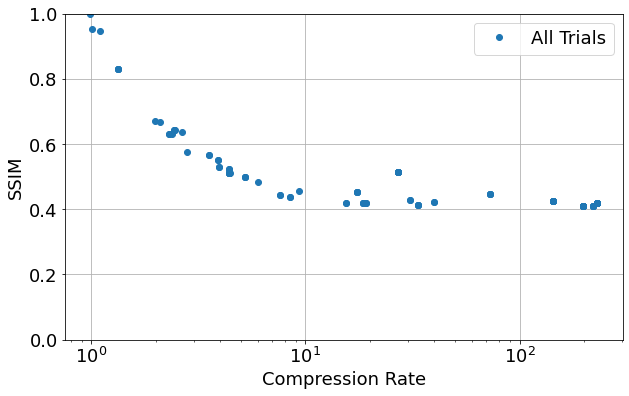

Results for image: image
../images/results/TPE_house_pareto_front.png saved


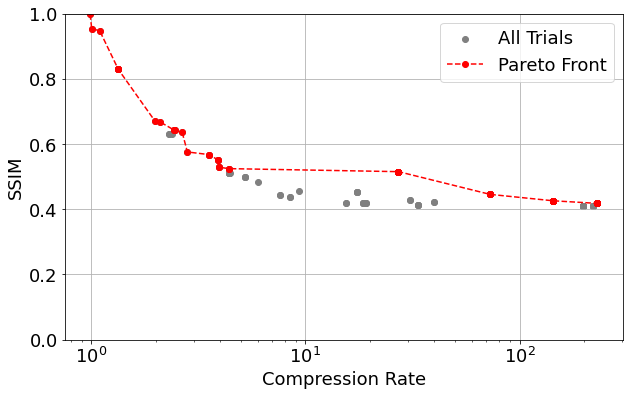

[I 2024-12-11 08:52:40,919] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:4.2.01_time:2024-12-11_08-52-40


image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28122
DEFLATE applied. Bytes to write: 23389
File saved.


[I 2024-12-11 08:52:42,052] Trial 0 finished with values: [8.522780222624903, 0.6489549944312978] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0458741188049316
SSIM Index : 0.6489549944312978

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31176
File saved.


[I 2024-12-11 08:52:45,364] Trial 1 finished with values: [5.355083562627919, 0.5894109980161297] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.160062551498413
SSIM Index : 0.5894109980161297

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 08:52:48,982] Trial 2 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.5060343742370605
SSIM Index : 0.6697764050963556

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262647
DEFLATE applied. Bytes to write: 249907
File saved.


[I 2024-12-11 08:52:57,170] Trial 3 finished with values: [2.241396525705468, 0.7632066746406766] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.060758590698242
SSIM Index : 0.7632066746406766

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 08:53:07,065] Trial 4 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 9.785800218582153
SSIM Index : 0.6626479796518644

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4929
File saved.


[I 2024-12-11 08:53:08,877] Trial 5 finished with values: [18.456600953003832, 0.6228291759344704] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.6926798820495605
SSIM Index : 0.6228291759344704

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136282
DEFLATE applied. Bytes to write: 126299
File saved.


[I 2024-12-11 08:53:13,528] Trial 6 finished with values: [2.635443696593312, 0.715272543937196] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.533514976501465
SSIM Index : 0.715272543937196

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4552
DEFLATE applied. Bytes to write: 4159
File saved.


[I 2024-12-11 08:53:15,616] Trial 7 finished with values: [21.49989116238572, 0.6071503033540541] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9791481494903564
SSIM Index : 0.6071503033540541

image name:  4.2.01
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 08:53:20,385] Trial 8 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.633044004440308
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 08:53:21,508] Trial 9 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0352020263671875
SSIM Index : 0.6504376234947409

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 08:53:22,314] Trial 10 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.5460650465732574, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 9.710150883703287, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7039377689361572
SSIM Index : 0.6306026614046821

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 08:53:23,700] Trial 11 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.6416128848911435, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 13.800909892716907, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.259138584136963
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 08:53:25,454] Trial 12 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.6417604380009114, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 11.379862085234848, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.6210784912109375
SSIM Index : 0.6774326952134292

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 08:53:27,138] Trial 13 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.6425108562733248, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 11.143432919527932, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5720131397247314
SSIM Index : 0.6774326952134292

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 08:53:28,637] Trial 14 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.7234827702831506, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.67005516791073, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3750872611999512
SSIM Index : 0.6046521569314206

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 989615
DEFLATE applied. Bytes to write: 685144
File saved.


[I 2024-12-11 08:53:45,533] Trial 15 finished with values: [1.3609579155141114, 0.8778583629945856] and parameters: {'min_sparcity': 0.5675452028308603, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 32.21146576240811, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 16.770936250686646
SSIM Index : 0.8778583629945856

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 08:53:46,967] Trial 16 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.7939973491766084, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.591080911563507, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3088335990905762
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 175160
DEFLATE applied. Bytes to write: 151740
File saved.


[I 2024-12-11 08:53:49,709] Trial 17 finished with values: [2.4090659642190757, 0.7073286420573649] and parameters: {'min_sparcity': 0.3756217653366024, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 47.09435713844267, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.601156234741211
SSIM Index : 0.7073286420573649

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:53:51,079] Trial 18 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.9590086785904091, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.723009395705977, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2442824840545654
SSIM Index : 0.6356385237265485

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175160
DEFLATE applied. Bytes to write: 151741
File saved.


[I 2024-12-11 08:53:53,936] Trial 19 finished with values: [2.4090659642190757, 0.7073286420573649] and parameters: {'min_sparcity': 0.5923243044978939, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.025693884064244592, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.7194337844848633
SSIM Index : 0.7073286420573649

image name:  4.2.01
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 08:53:55,296] Trial 20 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.7467107118344587, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 700.127363180912, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2166764736175537
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50052
File saved.


[I 2024-12-11 08:53:57,152] Trial 21 finished with values: [5.275920089738796, 0.7008934646623062] and parameters: {'min_sparcity': 0.8887579075912415, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.0842245925519176, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7259869575500488
SSIM Index : 0.7008934646623062

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 08:53:58,548] Trial 22 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.48548337402156433, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.0731790678117976, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2675800323486328
SSIM Index : 0.6356385237265485

image name:  4.2.01
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 08:53:59,386] Trial 23 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.02398573724563774, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 63.92629961194017, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7123081684112549
SSIM Index : 0.6306026614046821

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 586
File saved.


[I 2024-12-11 08:54:00,784] Trial 24 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.9711683640756736, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 6.532109768756257, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.263770341873169
SSIM Index : 0.6356385237265485

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4929
File saved.


[I 2024-12-11 08:54:02,376] Trial 25 finished with values: [18.456600953003832, 0.6228291759344704] and parameters: {'min_sparcity': 0.6555669115667839, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 81.96001135952743, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4387438297271729
SSIM Index : 0.6228291759344704

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 08:54:03,883] Trial 26 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.7750525347339612, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.40665984543879874, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.35536527633667
SSIM Index : 0.6347237508901792

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193990
File saved.


[I 2024-12-11 08:54:09,139] Trial 27 finished with values: [2.6225331731375583, 0.78144170880021] and parameters: {'min_sparcity': 0.26324446710284344, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.07655112578268525, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 5.120181322097778
SSIM Index : 0.78144170880021

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 08:54:13,222] Trial 28 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.35367356031948155, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 26.63495471131879, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.968740701675415
SSIM Index : 0.728367036695691

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 08:54:14,792] Trial 29 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.5168861961678861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.006828228878250116, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4437000751495361
SSIM Index : 0.6046521569314206

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10220
DEFLATE applied. Bytes to write: 8839
File saved.


[I 2024-12-11 08:54:16,729] Trial 30 finished with values: [13.12433976680065, 0.6137336785092552] and parameters: {'min_sparcity': 0.3373689091287583, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 20.207965368920735, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7429332733154297
SSIM Index : 0.6137336785092552

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:54:17,845] Trial 31 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.6174235948311786, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.7814260592423703, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9896364212036133
SSIM Index : 0.6423701532399569

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:54:18,966] Trial 32 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.6107673468486087, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.6762779091891575, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9990262985229492
SSIM Index : 0.6423701532399569

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 08:54:19,888] Trial 33 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.6894842490594798, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 105.01083720580236, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7953252792358398
SSIM Index : 0.6306026614046821

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77522
DEFLATE applied. Bytes to write: 70402
File saved.


[I 2024-12-11 08:54:23,246] Trial 34 finished with values: [4.076288149233404, 0.6697171454130536] and parameters: {'min_sparcity': 0.433675056250214, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.094246032501113, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.2035579681396484
SSIM Index : 0.6697171454130536

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 08:54:24,813] Trial 35 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.855792878961754, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 24.865831552319392, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4157586097717285
SSIM Index : 0.6210865534424851

image name:  4.2.01
8 4
processed_blocks: 43761
bytes_written (without DEFLATE): 3429023
DEFLATE applied. Bytes to write: 3006181
File saved.


[I 2024-12-11 08:56:44,391] Trial 36 finished with values: [0.9836841908698196, 0.9929357444859708] and parameters: {'min_sparcity': 0.5274430135633651, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0739560197822764, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 139.42302346229553
SSIM Index : 0.9929357444859708

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 08:56:48,965] Trial 37 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.8148691086294975, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 139.96564162948445, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.443110227584839
SSIM Index : 0.728367036695691

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 08:56:51,984] Trial 38 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.6999361245330585, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 4.742457792750336, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.8657941818237305
SSIM Index : 0.5768626426872626

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 08:56:53,793] Trial 39 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.34332672393657204, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 686.8270428579676, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.6040935516357422
SSIM Index : 0.6046521569314206

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 08:57:00,398] Trial 40 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.6295603818353898, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.5789691214138467, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.422106504440308
SSIM Index : 0.6697764050963556

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268542
DEFLATE applied. Bytes to write: 192444
File saved.


[I 2024-12-11 08:57:06,618] Trial 41 finished with values: [2.6243100161411386, 0.7814025538788072] and parameters: {'min_sparcity': 0.23047012571935382, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 37.24201612979864, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.073332071304321
SSIM Index : 0.7814025538788072

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 08:57:11,502] Trial 42 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.14332258109139417, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 18.297411994261946, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.696668863296509
SSIM Index : 0.728367036695691

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 960255
DEFLATE applied. Bytes to write: 657284
File saved.


[I 2024-12-11 08:57:29,348] Trial 43 finished with values: [1.3477679454727807, 0.8743032887465385] and parameters: {'min_sparcity': 0.4357275840717866, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 39.340780860161175, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 17.677531480789185
SSIM Index : 0.8743032887465385

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:57:30,549] Trial 44 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.5793432152021384, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.851269835342159, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0963773727416992
SSIM Index : 0.6423701532399569

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 136282
DEFLATE applied. Bytes to write: 126299
File saved.


[I 2024-12-11 08:57:35,187] Trial 45 finished with values: [2.635443696593312, 0.715272543937196] and parameters: {'min_sparcity': 0.48109891521771264, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.001559042619330889, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.492002964019775
SSIM Index : 0.715272543937196

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 08:57:36,799] Trial 46 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.169254807974013, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 8.959191337846887, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4560868740081787
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67480
DEFLATE applied. Bytes to write: 49957
File saved.


[I 2024-12-11 08:57:38,835] Trial 47 finished with values: [5.278246115616358, 0.7008910343127205] and parameters: {'min_sparcity': 0.754928594544183, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 260.94000070131466, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9031314849853516
SSIM Index : 0.7008910343127205

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29933
File saved.


[I 2024-12-11 08:57:48,275] Trial 48 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8961828064257906, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.006184701978388875, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 9.30885648727417
SSIM Index : 0.6626479796518644

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:57:49,251] Trial 49 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.6999258007643723, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.16321942490882546, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.8660678863525391
SSIM Index : 0.6423701532399569

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78090
File saved.


[I 2024-12-11 08:57:51,501] Trial 50 finished with values: [4.1688069135072965, 0.7205591899140703] and parameters: {'min_sparcity': 0.5586527469319582, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 10.0583973723373, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.122389793395996
SSIM Index : 0.7205591899140703

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 08:57:55,488] Trial 51 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.20295025643717834, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 2.064360401473582, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.8705639839172363
SSIM Index : 0.728367036695691

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 981595
DEFLATE applied. Bytes to write: 677456
File saved.


[I 2024-12-11 08:58:12,777] Trial 52 finished with values: [1.3571011465983334, 0.8769493085106435] and parameters: {'min_sparcity': 0.2967634364551557, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 34.05346484955328, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 17.16004753112793
SSIM Index : 0.8769493085106435

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 08:58:14,472] Trial 53 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.39032003677251365, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 15.696416144873732, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.572960376739502
SSIM Index : 0.6774326952134292

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50052
File saved.


[I 2024-12-11 08:58:16,372] Trial 54 finished with values: [5.275920089738796, 0.7008934646623062] and parameters: {'min_sparcity': 0.04697054261854072, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.501017902919187, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7794740200042725
SSIM Index : 0.7008934646623062

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 08:58:20,097] Trial 55 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.24777012641068236, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 123.1422673036616, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.620962381362915
SSIM Index : 0.728367036695691

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 08:58:21,144] Trial 56 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.3073453703876905, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 6.329393645963364, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9372234344482422
SSIM Index : 0.6504376234947409

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 08:58:22,743] Trial 57 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.9437517630700104, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 63.248003469188546, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4904606342315674
SSIM Index : 0.6774326952134292

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081360
DEFLATE applied. Bytes to write: 772258
File saved.


[I 2024-12-11 08:58:40,984] Trial 58 finished with values: [1.417222676595928, 0.8836459098280085] and parameters: {'min_sparcity': 0.4696529052363302, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.2645659823743205, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 18.107584476470947
SSIM Index : 0.8836459098280085

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 08:58:42,925] Trial 59 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.2184850377646742, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 13.735252197147966, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.8112854957580566
SSIM Index : 0.6774326952134292

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 08:58:44,445] Trial 60 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.10326304541562947, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 27.392704948834055, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3766298294067383
SSIM Index : 0.6210865534424851

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 08:58:58,245] Trial 61 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.47376839199870746, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.957010989840851, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 13.668254375457764
SSIM Index : 0.8313794911259887

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 08:59:12,817] Trial 62 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.48534880811915926, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.752740178376342, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.448347806930542
SSIM Index : 0.8313794911259887

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 08:59:27,709] Trial 63 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.42031945706401114, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.2945025252572302, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.781893968582153
SSIM Index : 0.8313794911259887

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 08:59:41,893] Trial 64 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.4672518429393057, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.2243189003646977, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.072612762451172
SSIM Index : 0.8313794911259887

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193990
File saved.


[I 2024-12-11 08:59:47,150] Trial 65 finished with values: [2.6225331731375583, 0.78144170880021] and parameters: {'min_sparcity': 0.369748952068907, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.22200673941344984, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 5.130845069885254
SSIM Index : 0.78144170880021

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:59:48,339] Trial 66 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.6573580744654788, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.91531093809688, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0454516410827637
SSIM Index : 0.6423701532399569

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 08:59:49,211] Trial 67 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.6042738553152032, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 2.998927489996782, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.763185977935791
SSIM Index : 0.6306026614046821

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50052
File saved.


[I 2024-12-11 08:59:51,246] Trial 68 finished with values: [5.275920089738796, 0.7008934646623062] and parameters: {'min_sparcity': 0.5126696715316742, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 5.17154013048363, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9066898822784424
SSIM Index : 0.7008934646623062

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 08:59:56,532] Trial 69 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.9983037105700563, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 12.16494191624144, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 5.141005754470825
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 08:59:57,621] Trial 70 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.5435441488154966, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.5451649532199678, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9682962894439697
SSIM Index : 0.6423701532399569

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 09:00:01,873] Trial 71 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.5354434665487421, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.013078348192858446, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.125216245651245
SSIM Index : 0.728367036695691

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 09:00:02,732] Trial 72 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.3587282156137019, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.09396548363207927, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7442972660064697
SSIM Index : 0.6306026614046821

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 09:00:16,939] Trial 73 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.8110883373889434, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 58.85808467849636, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.091171741485596
SSIM Index : 0.8313794911259887

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 09:00:18,296] Trial 74 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.40800895174828533, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 23.265119926350078, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.228851079940796
SSIM Index : 0.6504376234947409

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311320
DEFLATE applied. Bytes to write: 282664
File saved.


[I 2024-12-11 09:00:22,355] Trial 75 finished with values: [1.9778427465782913, 0.7963017515995175] and parameters: {'min_sparcity': 0.7244749156911251, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.7023086101695113, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.937753915786743
SSIM Index : 0.7963017515995175

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 09:00:23,235] Trial 76 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.4598913639949442, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 420.9997058300698, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7699308395385742
SSIM Index : 0.6306026614046821

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 09:00:24,344] Trial 77 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.6279538618567474, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 176.42337184584594, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9958846569061279
SSIM Index : 0.6504376234947409

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 776977
DEFLATE applied. Bytes to write: 682252
File saved.


[I 2024-12-11 09:00:32,635] Trial 78 finished with values: [1.5339177835411781, 0.8628166255066197] and parameters: {'min_sparcity': 0.32384001697664827, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.027505744238320504, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.171358823776245
SSIM Index : 0.8628166255066197

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29933
File saved.


[I 2024-12-11 09:00:40,975] Trial 79 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.5892618074122118, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.04818703128788925, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.215736150741577
SSIM Index : 0.6626479796518644

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 09:00:42,856] Trial 80 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.667856446368264, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.9165875397787017, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7486484050750732
SSIM Index : 0.6774326952134292

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 693537
DEFLATE applied. Bytes to write: 604863
File saved.


[I 2024-12-11 09:00:51,114] Trial 81 finished with values: [1.5488249015034203, 0.8616939249645009] and parameters: {'min_sparcity': 0.3255357943833749, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 82.64806093826837, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.122593879699707
SSIM Index : 0.8616939249645009

image name:  4.2.01
8 4
processed_blocks: 34503
bytes_written (without DEFLATE): 866077
DEFLATE applied. Bytes to write: 663944
File saved.


[I 2024-12-11 09:01:13,227] Trial 82 finished with values: [1.1134559289790742, 0.9313842957800925] and parameters: {'min_sparcity': 0.2802812071144855, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 86.12874341108049, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 21.979693174362183
SSIM Index : 0.9313842957800925

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 09:01:16,206] Trial 83 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.5229887515576167, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 17.01796698594819, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.842435359954834
SSIM Index : 0.5768626426872626

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 204124
File saved.


[I 2024-12-11 09:01:30,679] Trial 84 finished with values: [9.39530570022116, 0.8313794911259887] and parameters: {'min_sparcity': 0.8919454618917577, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 8.096480391831504, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.332370519638062
SSIM Index : 0.8313794911259887

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 09:01:31,877] Trial 85 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.4441755944250456, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 47.39454920049475, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.076998233795166
SSIM Index : 0.6504376234947409

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 09:01:32,721] Trial 86 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.2888091110094287, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.31772656071081185, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7323694229125977
SSIM Index : 0.6306026614046821

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 09:01:33,717] Trial 87 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.7318370659949671, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 4.284318947783545, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.8749587535858154
SSIM Index : 0.6423701532399569

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 09:01:35,298] Trial 88 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.7757641417208777, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 23.12537404005864, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4488937854766846
SSIM Index : 0.6356385237265485

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 09:01:37,221] Trial 89 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.5635535554148765, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.560938458904485, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7867963314056396
SSIM Index : 0.6774326952134292

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270312
DEFLATE applied. Bytes to write: 193966
File saved.


[I 2024-12-11 09:01:42,336] Trial 90 finished with values: [2.6226550364440198, 0.7814411864170806] and parameters: {'min_sparcity': 0.9225290415099807, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 10.248843561937038, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.996335744857788
SSIM Index : 0.7814411864170806

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 670982
DEFLATE applied. Bytes to write: 583471
File saved.


[I 2024-12-11 09:01:50,570] Trial 91 finished with values: [1.5525436783325606, 0.8611362701999447] and parameters: {'min_sparcity': 0.837042096742227, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 93.6482406694654, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.111132144927979
SSIM Index : 0.8611362701999447

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 09:01:51,727] Trial 92 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.4982357437927044, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.7515024060347955, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0191152095794678
SSIM Index : 0.6423701532399569

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 18540
DEFLATE applied. Bytes to write: 16842
File saved.


[I 2024-12-11 09:01:54,044] Trial 93 finished with values: [7.907966373098478, 0.6095810985031535] and parameters: {'min_sparcity': 0.6842459775762121, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 6.536932426395598, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.1166625022888184
SSIM Index : 0.6095810985031535

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 09:01:58,945] Trial 94 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.5770581233029466, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 34.77239362405466, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.740718126296997
SSIM Index : 0.5231643192615097

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 55350
File saved.


[I 2024-12-11 09:02:03,342] Trial 95 finished with values: [26.812487275195114, 0.728367036695691] and parameters: {'min_sparcity': 0.6203565882790576, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 14.224111540312508, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.264908790588379
SSIM Index : 0.728367036695691

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 09:02:04,779] Trial 96 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.4012730510636612, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 998.3365528300703, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2999749183654785
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78090
File saved.


[I 2024-12-11 09:02:06,995] Trial 97 finished with values: [4.1688069135072965, 0.7205591899140703] and parameters: {'min_sparcity': 0.8270595417648741, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.004384061360755133, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.0660440921783447
SSIM Index : 0.7205591899140703

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 09:02:08,017] Trial 98 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.7074703967778501, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.015331794975538163, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.8978490829467773
SSIM Index : 0.6423701532399569

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14938
File saved.


[I 2024-12-11 09:02:09,737] Trial 99 finished with values: [68.12933264355924, 0.6774326952134292] and parameters: {'min_sparcity': 0.6386061188211514, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 45.4766475600657, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5954015254974365
SSIM Index : 0.6774326952134292

../images/results/TPE_4.2.01_compression_vs_ssim.png saved


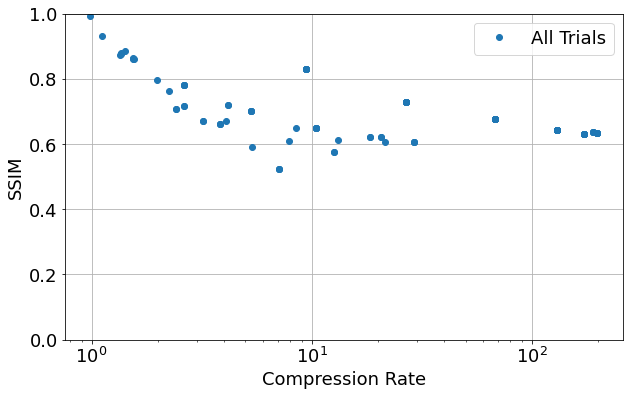

Results for image: image
../images/results/TPE_4.2.01_pareto_front.png saved


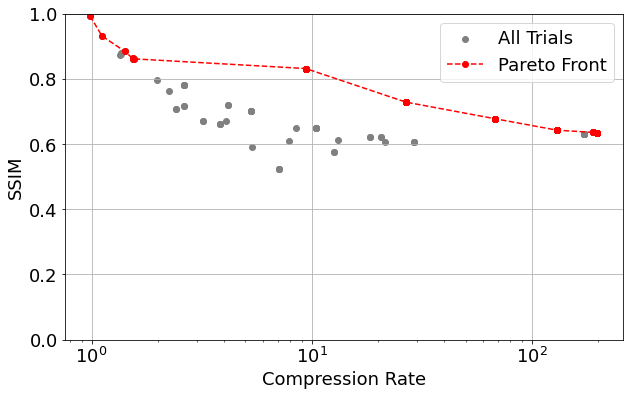

[I 2024-12-11 09:02:10,899] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:4.2.05_time:2024-12-11_09-02-10


image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 27512
DEFLATE applied. Bytes to write: 22908
File saved.


[I 2024-12-11 09:02:12,110] Trial 0 finished with values: [8.65804765255856, 0.5688071873687938] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.124898910522461
SSIM Index : 0.5688071873687938

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33535
DEFLATE applied. Bytes to write: 31148
File saved.


[I 2024-12-11 09:02:15,075] Trial 1 finished with values: [6.242052620134812, 0.5617518141388579] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.8147754669189453
SSIM Index : 0.5617518141388579

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61139
File saved.


[I 2024-12-11 09:02:19,110] Trial 2 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.9239578247070312
SSIM Index : 0.6087622486063672

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262657
DEFLATE applied. Bytes to write: 250197
File saved.


[I 2024-12-11 09:02:26,695] Trial 3 finished with values: [2.3489161148143705, 0.6990703605021341] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.476106405258179
SSIM Index : 0.6990703605021341

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 09:02:34,900] Trial 4 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 8.09743070602417
SSIM Index : 0.5862839738572689

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4960
File saved.


[I 2024-12-11 09:02:36,684] Trial 5 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6627991199493408
SSIM Index : 0.5459570210290938

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136352
DEFLATE applied. Bytes to write: 126650
File saved.


[I 2024-12-11 09:02:41,070] Trial 6 finished with values: [2.856286233566378, 0.6486337178097701] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.2417566776275635
SSIM Index : 0.6486337178097701

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 09:02:43,397] Trial 7 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.223754644393921
SSIM Index : 0.5417003053903997

image name:  4.2.05
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15327
File saved.


[I 2024-12-11 09:02:48,502] Trial 8 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.997894287109375
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16907
DEFLATE applied. Bytes to write: 12443
File saved.


[I 2024-12-11 09:02:49,653] Trial 9 finished with values: [9.234570019300879, 0.5602533489303304] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0641884803771973
SSIM Index : 0.5602533489303304

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 09:02:51,491] Trial 10 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.7170665264129639
SSIM Index : 0.528652460992648

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 09:02:53,437] Trial 11 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.9604047206889855, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.8164567947387695
SSIM Index : 0.528652460992648

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:02:55,337] Trial 12 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.711789850865905, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 11.119503402424064, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.7430152893066406
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 588
File saved.


[I 2024-12-11 09:02:56,950] Trial 13 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.6901390718388066, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.066781891213754, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4268159866333008
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:02:58,531] Trial 14 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.7144843823456071, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.759510632393621, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4448480606079102
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:03:00,254] Trial 15 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.5859325103345451, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.17850468794869587, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5228254795074463
SSIM Index : 0.5577680818614107

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1272715
DEFLATE applied. Bytes to write: 959102
File saved.


[I 2024-12-11 09:03:28,007] Trial 16 finished with values: [1.0506093469801032, 0.9300202358721344] and parameters: {'min_sparcity': 0.831656968223946, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 52.23064436548061, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 27.62697982788086
SSIM Index : 0.9300202358721344

image name:  4.2.05
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50292
File saved.


[I 2024-12-11 09:03:29,905] Trial 17 finished with values: [4.896611325904026, 0.6123013939170049] and parameters: {'min_sparcity': 0.5407467887669891, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 1.6677870137195525, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.777177333831787
SSIM Index : 0.6123013939170049

image name:  4.2.05
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50292
File saved.


[I 2024-12-11 09:03:32,320] Trial 18 finished with values: [4.896611325904026, 0.6123013939170049] and parameters: {'min_sparcity': 0.5565513448815889, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 1.951124806018998, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.2934179306030273
SSIM Index : 0.6123013939170049

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:03:36,556] Trial 19 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.36332392367060184, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 51.88106700661598, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.129032373428345
SSIM Index : 0.6410133987599165

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:03:40,566] Trial 20 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.3571430903620242, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 64.56077356894627, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.9056503772735596
SSIM Index : 0.6410133987599165

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14816
File saved.


[I 2024-12-11 09:03:42,444] Trial 21 finished with values: [68.96348494554772, 0.5664494445444207] and parameters: {'min_sparcity': 0.21909578809308028, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 43.61514521334135, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.7488276958465576
SSIM Index : 0.5664494445444207

image name:  4.2.05
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1123
File saved.


[I 2024-12-11 09:03:43,392] Trial 22 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.7761636828334196, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 58.03922370638784, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.8336279392242432
SSIM Index : 0.5488669824313362

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4961
File saved.


[I 2024-12-11 09:03:45,054] Trial 23 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.6133162741567344, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.02361364405077443, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5280678272247314
SSIM Index : 0.5459570210290938

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:03:46,878] Trial 24 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.7603269784374418, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 5.085961229729409, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6588852405548096
SSIM Index : 0.5577680818614107

image name:  4.2.05
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 09:03:48,557] Trial 25 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.028609417686147165, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 21.092351585785295, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5377979278564453
SSIM Index : 0.5485143072349075

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 79230
DEFLATE applied. Bytes to write: 60911
File saved.


[I 2024-12-11 09:03:50,693] Trial 26 finished with values: [4.40700030703101, 0.6423597466263858] and parameters: {'min_sparcity': 0.6677960835828138, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 559.6161972730253, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.990579605102539
SSIM Index : 0.6423597466263858

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:04:05,120] Trial 27 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.48414923821953837, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.6013589670552001, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.31460976600647
SSIM Index : 0.7895725170999578

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 773132
File saved.


[I 2024-12-11 09:04:22,678] Trial 28 finished with values: [1.4377946656338065, 0.8692079189285721] and parameters: {'min_sparcity': 0.49448860093384217, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.05561811283925312, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 17.447388172149658
SSIM Index : 0.8692079189285721

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4961
File saved.


[I 2024-12-11 09:04:24,497] Trial 29 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.6131082748931094, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0121458827137354, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.625173807144165
SSIM Index : 0.5459570210290938

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 09:04:27,014] Trial 30 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.885609782172311, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.6082496695801956, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.384470224380493
SSIM Index : 0.5417003053903997

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1122
File saved.


[I 2024-12-11 09:04:27,963] Trial 31 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.25990490648766945, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 34.20117349872623, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.8272719383239746
SSIM Index : 0.5488669824313362

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14816
File saved.


[I 2024-12-11 09:04:29,687] Trial 32 finished with values: [68.96348494554772, 0.5664494445444207] and parameters: {'min_sparcity': 0.35459143217271927, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 5.171230646943007, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6038525104522705
SSIM Index : 0.5664494445444207

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12451
File saved.


[I 2024-12-11 09:04:30,977] Trial 33 finished with values: [9.234966114780818, 0.5602535862845938] and parameters: {'min_sparcity': 0.7889309745313942, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 158.0524290202359, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.1726102828979492
SSIM Index : 0.5602535862845938

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:04:32,516] Trial 34 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.4932436660910391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 112.0843209075026, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4115636348724365
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 09:04:34,510] Trial 35 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.9134161149030542, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 961.5863596426796, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.863368272781372
SSIM Index : 0.528652460992648

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33535
DEFLATE applied. Bytes to write: 31148
File saved.


[I 2024-12-11 09:04:37,350] Trial 36 finished with values: [6.242052620134812, 0.5617518141388579] and parameters: {'min_sparcity': 0.16916731336654667, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.006337924997049013, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.6925556659698486
SSIM Index : 0.5617518141388579

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 475162
DEFLATE applied. Bytes to write: 391794
File saved.


[I 2024-12-11 09:04:43,777] Trial 37 finished with values: [1.951835080705476, 0.7787876579038627] and parameters: {'min_sparcity': 0.3850973981235545, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0013630659438522692, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.295848369598389
SSIM Index : 0.7787876579038627

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3864
File saved.


[I 2024-12-11 09:04:44,844] Trial 38 finished with values: [135.66729678638941, 0.550605628050361] and parameters: {'min_sparcity': 0.45330051250524417, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.169968327509204, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.947213888168335
SSIM Index : 0.550605628050361

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:04:46,499] Trial 39 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.32067754865824494, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.12066574373582262, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5293245315551758
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 09:04:51,869] Trial 40 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.4267075268897733, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.550918382004482, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.208712100982666
SSIM Index : 0.5397673766211807

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 773132
File saved.


[I 2024-12-11 09:05:12,193] Trial 41 finished with values: [1.4377946656338065, 0.8692079189285721] and parameters: {'min_sparcity': 0.5024004264925479, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.3871594338144305, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 20.178426265716553
SSIM Index : 0.8692079189285721

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:05:17,414] Trial 42 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.1830042662192603, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.04999763437064826, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.054623365402222
SSIM Index : 0.6410133987599165

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194803
File saved.
Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 8.290784120559692


[I 2024-12-11 09:05:26,052] Trial 43 finished with values: [2.685559616320116, 0.7255375769208809] and parameters: {'min_sparcity': 0.7318511195648445, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.1182519985768926, 'exponent_a_cols': 2}.


SSIM Index : 0.7255375769208809

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:05:28,313] Trial 44 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.0625597255918473, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 23.742603791292535, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.978646993637085
SSIM Index : 0.5577680818614107

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61140
File saved.


[I 2024-12-11 09:05:33,898] Trial 45 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.8296571758547826, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.2983984734581413, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.397842168807983
SSIM Index : 0.6087622486063672

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311025
DEFLATE applied. Bytes to write: 283108
File saved.


[I 2024-12-11 09:05:39,345] Trial 46 finished with values: [2.0077492271754487, 0.7364259914006879] and parameters: {'min_sparcity': 0.6566151285117756, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 10.832314183819726, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.284308910369873
SSIM Index : 0.7364259914006879

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 09:05:42,941] Trial 47 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.9149733514381385, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0612340849554893, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.451188564300537
SSIM Index : 0.5495959970605222

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 4063070
DEFLATE applied. Bytes to write: 3235221
File saved.


[I 2024-12-11 09:06:45,033] Trial 48 finished with values: [0.9890894390363792, 0.9967910096106202] and parameters: {'min_sparcity': 0.46304103075609354, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.002822310685916712, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 61.90447163581848
SSIM Index : 0.9967910096106202

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:06:46,972] Trial 49 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.28872531857384853, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 116.97760714937064, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.774843692779541
SSIM Index : 0.5502915445889943

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1122
File saved.


[I 2024-12-11 09:06:48,225] Trial 50 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.6135248461962294, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 32.41318860201555, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0644102096557617
SSIM Index : 0.5488669824313362

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 777980
DEFLATE applied. Bytes to write: 470218
File saved.


[I 2024-12-11 09:07:22,343] Trial 51 finished with values: [1.3456878474707101, 0.8280027109971083] and parameters: {'min_sparcity': 0.45320827125517565, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 407.6548247676648, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 33.925981521606445
SSIM Index : 0.8280027109971083

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3864
File saved.


[I 2024-12-11 09:07:23,967] Trial 52 finished with values: [135.66729678638941, 0.550605628050361] and parameters: {'min_sparcity': 0.553762893435318, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.9306212783321635, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4481604099273682
SSIM Index : 0.550605628050361

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:07:26,074] Trial 53 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.9474880105119788, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.002683973337057701, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.9356036186218262
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:07:27,969] Trial 54 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.8135486879736363, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 12.395504132422225, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6967592239379883
SSIM Index : 0.5577680818614107

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:07:34,098] Trial 55 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.7337784627235353, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 62.2441124186058, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.975406646728516
SSIM Index : 0.6410133987599165

image name:  4.2.05
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 40092
DEFLATE applied. Bytes to write: 34643
File saved.


[I 2024-12-11 09:07:38,111] Trial 56 finished with values: [6.858453452257705, 0.594592441953654] and parameters: {'min_sparcity': 0.8573490053904488, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 2.7611753236396783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.813826322555542
SSIM Index : 0.594592441953654

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12451
File saved.


[I 2024-12-11 09:07:39,737] Trial 57 finished with values: [9.234966114780818, 0.5602535862845938] and parameters: {'min_sparcity': 0.5199932489115043, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.4263526343385388, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4607822895050049
SSIM Index : 0.5602535862845938

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 09:07:43,692] Trial 58 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.6999538299905067, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 7.487870357069723, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.741975784301758
SSIM Index : 0.5495959970605222

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:07:46,039] Trial 59 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.647264831041495, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.11706339889508875, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.089775562286377
SSIM Index : 0.5577680818614107

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 09:08:04,395] Trial 60 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.9987002554908249, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.005844715573545524, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 18.103715181350708
SSIM Index : 0.6467224617831863

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:08:29,061] Trial 61 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.21295332472443565, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 33.460219245668554, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 24.476988315582275
SSIM Index : 0.7895725170999578

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 92245
DEFLATE applied. Bytes to write: 73432
File saved.


[I 2024-12-11 09:08:31,767] Trial 62 finished with values: [4.358865865632813, 0.6432289154697628] and parameters: {'min_sparcity': 0.41182022415553504, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 177.16502722353937, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.522653102874756
SSIM Index : 0.6432289154697628

image name:  4.2.05
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1122
File saved.


[I 2024-12-11 09:08:32,898] Trial 63 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.5823891523680519, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 77.71674281091542, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.9428067207336426
SSIM Index : 0.5488669824313362

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:08:34,966] Trial 64 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.1080176631089701, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.3408089732053463, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.8708596229553223
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 09:08:36,987] Trial 65 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.7946774927517483, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 20.036683162692647, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.8138933181762695
SSIM Index : 0.5577680818614107

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 09:08:39,310] Trial 66 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.7491653551784376, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.24702833375214625, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.0836100578308105
SSIM Index : 0.5485143072349075

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:08:59,292] Trial 67 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.884222615574194, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.6357602022824629, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 19.828437328338623
SSIM Index : 0.7895725170999578

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67535
DEFLATE applied. Bytes to write: 50229
File saved.


[I 2024-12-11 09:09:01,722] Trial 68 finished with values: [4.895998908483133, 0.6123015543812578] and parameters: {'min_sparcity': 0.49004088287004316, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 49.80821276758704, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.256293535232544
SSIM Index : 0.6123015543812578

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 26282
DEFLATE applied. Bytes to write: 21720
File saved.


[I 2024-12-11 09:09:03,376] Trial 69 finished with values: [8.650742310705748, 0.568769927502689] and parameters: {'min_sparcity': 0.3707783945375638, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 959.9540136196141, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4838206768035889
SSIM Index : 0.568769927502689

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 09:09:15,892] Trial 70 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.28616179691587573, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 5.278422863534734, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 12.303202390670776
SSIM Index : 0.5862839738572689

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:09:33,559] Trial 71 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.3239410013961379, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 91.14240174562565, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 17.520577430725098
SSIM Index : 0.7895725170999578

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:09:38,140] Trial 72 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.24178181483892375, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.015874696103612904, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.435535430908203
SSIM Index : 0.6410133987599165

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:09:54,939] Trial 73 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.43666673748612994, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 247.31100476045916, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 16.662015676498413
SSIM Index : 0.7895725170999578

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 255087
DEFLATE applied. Bytes to write: 180026
File saved.


[I 2024-12-11 09:10:01,094] Trial 74 finished with values: [2.690845919751042, 0.725399574892525] and parameters: {'min_sparcity': 0.4747502520502161, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 41.16658515115433, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.025218725204468
SSIM Index : 0.725399574892525

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:10:19,264] Trial 75 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.32857795057672806, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0567904294188281, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 18.030925035476685
SSIM Index : 0.7895725170999578

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 54157
File saved.


[I 2024-12-11 09:10:24,751] Trial 76 finished with values: [26.427396587700994, 0.6410133987599165] and parameters: {'min_sparcity': 0.3897207342481752, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 16.077580162262176, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.294929504394531
SSIM Index : 0.6410133987599165

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194803
File saved.


[I 2024-12-11 09:10:31,732] Trial 77 finished with values: [2.685559616320116, 0.7255375769208809] and parameters: {'min_sparcity': 0.531768372687651, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.1394353992660472, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.760451555252075
SSIM Index : 0.7255375769208809

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:10:48,729] Trial 78 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.16092119466713722, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 22.91147609904219, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 16.838164567947388
SSIM Index : 0.7895725170999578

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081350
DEFLATE applied. Bytes to write: 773124
File saved.


[I 2024-12-11 09:11:09,335] Trial 79 finished with values: [1.4377850641415186, 0.8692072348033388] and parameters: {'min_sparcity': 0.3482992120218672, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.4883598589006635, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 20.4481942653656
SSIM Index : 0.8692072348033388

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 14816
File saved.


[I 2024-12-11 09:11:11,171] Trial 80 finished with values: [68.96348494554772, 0.5664494445444207] and parameters: {'min_sparcity': 0.21049444241937773, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 110.06858571061167, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.683077096939087
SSIM Index : 0.5664494445444207

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:11:27,571] Trial 81 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.46374452800232974, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.33421281072057807, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 16.21688413619995
SSIM Index : 0.7895725170999578

image name:  4.2.05
8 4
processed_blocks: 18543
bytes_written (without DEFLATE): 734477
DEFLATE applied. Bytes to write: 601981
File saved.


[I 2024-12-11 09:11:43,279] Trial 82 finished with values: [1.431199978728496, 0.9504365089836083] and parameters: {'min_sparcity': 0.41276908605736107, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 173.74750222002353, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.551614761352539
SSIM Index : 0.9504365089836083

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 775252
DEFLATE applied. Bytes to write: 682864
File saved.


[I 2024-12-11 09:11:54,099] Trial 83 finished with values: [1.473907596678464, 0.8456449502774755] and parameters: {'min_sparcity': 0.41593539980503746, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8387324960989753, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 10.654978513717651
SSIM Index : 0.8456449502774755

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 738252
DEFLATE applied. Bytes to write: 649031
File saved.


[I 2024-12-11 09:12:05,914] Trial 84 finished with values: [1.448990167509035, 0.8904605474923696] and parameters: {'min_sparcity': 0.4251418887973464, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 151.64767398346, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 11.652852773666382
SSIM Index : 0.8904605474923696

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 498972
DEFLATE applied. Bytes to write: 416945
File saved.


[I 2024-12-11 09:12:13,733] Trial 85 finished with values: [1.6324636626253894, 0.8412286771769136] and parameters: {'min_sparcity': 0.408730639549132, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 162.16521387536005, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.663135051727295
SSIM Index : 0.8412286771769136

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10315
DEFLATE applied. Bytes to write: 8994
File saved.


[I 2024-12-11 09:12:15,884] Trial 86 finished with values: [15.934870295674056, 0.547487027054749] and parameters: {'min_sparcity': 0.5813628298973644, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0011107385241810063, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.9759182929992676
SSIM Index : 0.547487027054749

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 09:12:18,229] Trial 87 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.01017655412247187, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 7.321631429574003, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.1846096515655518
SSIM Index : 0.5417003053903997

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 09:12:20,766] Trial 88 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.617591986475701, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 441.0861956760456, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.3503665924072266
SSIM Index : 0.5417003053903997

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 09:12:26,861] Trial 89 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.709896048831442, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.7748914929810504, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 5.903453826904297
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40092
DEFLATE applied. Bytes to write: 34644
File saved.


[I 2024-12-11 09:12:31,012] Trial 90 finished with values: [6.858453452257705, 0.594592441953654] and parameters: {'min_sparcity': 0.8887110858563216, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 183.76262616160864, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.956474542617798
SSIM Index : 0.594592441953654

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 78435
File saved.


[I 2024-12-11 09:12:33,900] Trial 91 finished with values: [4.348916830783215, 0.6432757948284374] and parameters: {'min_sparcity': 0.4186234094502758, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.006276166840660823, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.724748373031616
SSIM Index : 0.6432757948284374

image name:  4.2.05
8 4
processed_blocks: 30759
bytes_written (without DEFLATE): 699129
DEFLATE applied. Bytes to write: 520525
File saved.


[I 2024-12-11 09:12:56,284] Trial 92 finished with values: [1.2876417396296829, 0.9347561874546928] and parameters: {'min_sparcity': 0.1354728396864569, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 139.33058475691809, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 22.232362508773804
SSIM Index : 0.9347561874546928

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1460115
DEFLATE applied. Bytes to write: 1141013
File saved.


[I 2024-12-11 09:13:21,746] Trial 93 finished with values: [1.1353181257316418, 0.9380795293465557] and parameters: {'min_sparcity': 0.29110422549219117, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 27.395510849063168, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 25.327463626861572
SSIM Index : 0.9380795293465557

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 175120
DEFLATE applied. Bytes to write: 152104
File saved.


[I 2024-12-11 09:13:24,631] Trial 94 finished with values: [2.584604303592329, 0.6449016149207413] and parameters: {'min_sparcity': 0.5171267746711178, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.03398843104341226, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.7341148853302
SSIM Index : 0.6449016149207413

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:13:40,485] Trial 95 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.3966032785860034, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 45.12888442601622, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.706903457641602
SSIM Index : 0.7895725170999578

image name:  4.2.05
8 4
processed_blocks: 35499
bytes_written (without DEFLATE): 901414
DEFLATE applied. Bytes to write: 691843
File saved.


[I 2024-12-11 09:14:08,360] Trial 96 finished with values: [1.1584140836431527, 0.9466966345329756] and parameters: {'min_sparcity': 0.0898608643455917, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 79.2877885783275, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 27.72904634475708
SSIM Index : 0.9466966345329756

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77377
DEFLATE applied. Bytes to write: 70530
File saved.


[I 2024-12-11 09:14:12,172] Trial 97 finished with values: [4.544147908949885, 0.609915556753693] and parameters: {'min_sparcity': 0.43770324234299746, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0020752812316733055, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.6594645977020264
SSIM Index : 0.609915556753693

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 198398
File saved.


[I 2024-12-11 09:14:27,125] Trial 98 finished with values: [8.972308461650657, 0.7895725170999578] and parameters: {'min_sparcity': 0.5416724744277059, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 15.444256653449932, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.82104229927063
SSIM Index : 0.7895725170999578

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559185
DEFLATE applied. Bytes to write: 519386
File saved.


[I 2024-12-11 09:14:44,895] Trial 99 finished with values: [1.7158226511477788, 0.7920472184501413] and parameters: {'min_sparcity': 0.4730557205741815, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.01060491522648289, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 17.6170814037323
SSIM Index : 0.7920472184501413

../images/results/TPE_4.2.05_compression_vs_ssim.png saved


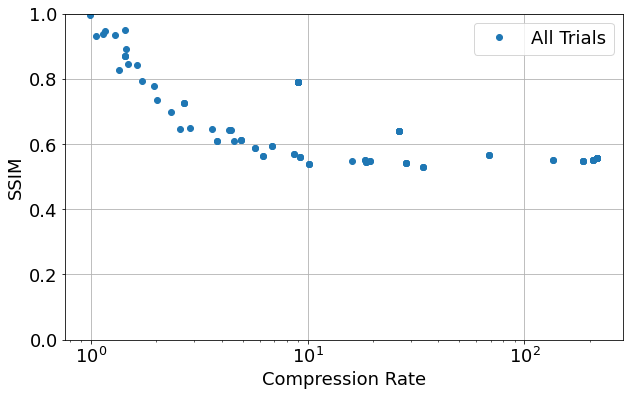

Results for image: image
../images/results/TPE_4.2.05_pareto_front.png saved


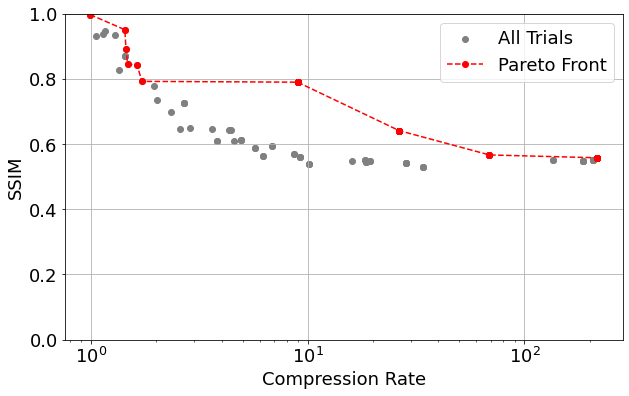

[I 2024-12-11 09:14:46,156] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:4.2.06_time:2024-12-11_09-14-46


image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28477
DEFLATE applied. Bytes to write: 23705
File saved.


[I 2024-12-11 09:14:47,446] Trial 0 finished with values: [9.250724733166425, 0.3831187034713898] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.194547176361084
SSIM Index : 0.3831187034713898

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33430
DEFLATE applied. Bytes to write: 30949
File saved.


[I 2024-12-11 09:14:51,387] Trial 1 finished with values: [7.059289332445104, 0.34418869196562857] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.8185462951660156
SSIM Index : 0.34418869196562857

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60983
File saved.


[I 2024-12-11 09:14:56,595] Trial 2 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.0775861740112305
SSIM Index : 0.3981404966423671

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262662
DEFLATE applied. Bytes to write: 249653
File saved.


[I 2024-12-11 09:15:07,474] Trial 3 finished with values: [2.555756287798463, 0.5422196772676535] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 10.744477033615112
SSIM Index : 0.5422196772676535

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 09:15:18,331] Trial 4 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 10.700536966323853
SSIM Index : 0.3734924603508912

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 09:15:20,280] Trial 5 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7888810634613037
SSIM Index : 0.34002498943942044

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136342
DEFLATE applied. Bytes to write: 126587
File saved.


[I 2024-12-11 09:15:26,688] Trial 6 finished with values: [2.9807028903206634, 0.4550608833320256] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.281405687332153
SSIM Index : 0.4550608833320256

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 09:15:29,297] Trial 7 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.477475881576538
SSIM Index : 0.33731218825195763

image name:  4.2.06
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 09:15:35,415] Trial 8 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.995455741882324
SSIM Index : 0.2902076526507203

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12422
File saved.


[I 2024-12-11 09:15:36,725] Trial 9 finished with values: [10.17077145961608, 0.3689385447767437] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2026572227478027
SSIM Index : 0.3689385447767437

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 09:15:38,783] Trial 10 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8955192565917969
SSIM Index : 0.3299010582882957

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 09:15:40,496] Trial 11 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.6540337852300198, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.5653536319732666
SSIM Index : 0.3214371997985182

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:15:42,132] Trial 12 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.6059507601264229, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.778039860056361, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4809095859527588
SSIM Index : 0.35273906218719014

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15249
File saved.


[I 2024-12-11 09:15:43,942] Trial 13 finished with values: [84.53190848886213, 0.3950647836571963] and parameters: {'min_sparcity': 0.6107723483172408, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 7.730170088504397, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6798138618469238
SSIM Index : 0.3950647836571963

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:15:45,580] Trial 14 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.6091914959702487, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4895997047424316
SSIM Index : 0.35273906218719014

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15249
File saved.


[I 2024-12-11 09:15:47,498] Trial 15 finished with values: [84.53190848886213, 0.3950647836571963] and parameters: {'min_sparcity': 0.5389879840136532, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.103846215160764, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.782501459121704
SSIM Index : 0.3950647836571963

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:15:49,366] Trial 16 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.7610231514940821, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 26.93361328466897, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7213220596313477
SSIM Index : 0.35273906218719014

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 777665
File saved.


[I 2024-12-11 09:16:10,077] Trial 17 finished with values: [1.5153755453684492, 0.7644240588280541] and parameters: {'min_sparcity': 0.35147818541471576, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.3833379153519325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 20.57912588119507
SSIM Index : 0.7644240588280541

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268102
DEFLATE applied. Bytes to write: 192258
File saved.


[I 2024-12-11 09:16:15,463] Trial 18 finished with values: [2.858866287948201, 0.5798560050151272] and parameters: {'min_sparcity': 0.5134493239719418, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 56.05550543577921, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.253994464874268
SSIM Index : 0.5798560050151272

image name:  4.2.06
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 10300
DEFLATE applied. Bytes to write: 8914
File saved.


[I 2024-12-11 09:16:17,823] Trial 19 finished with values: [16.909435780092732, 0.35106982723537367] and parameters: {'min_sparcity': 0.7674661163887234, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.04883060684997246, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.1674587726593018
SSIM Index : 0.35106982723537367

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:16:19,588] Trial 20 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.020966336660231344, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 976.7353569963619, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.584402084350586
SSIM Index : 0.35273906218719014

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:16:21,687] Trial 21 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.5382902774754191, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 46.67803801774202, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.951526403427124
SSIM Index : 0.45796281343927414

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:16:23,832] Trial 22 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.581164548263079, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 2.3369629496601627, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.016615867614746
SSIM Index : 0.45796281343927414

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:16:24,773] Trial 23 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.7170249013757537, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 5.178935004398355, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8272805213928223
SSIM Index : 0.3497066974354959

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50232
File saved.


[I 2024-12-11 09:16:26,774] Trial 24 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.47059074841275195, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 36.228054413435835, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8849952220916748
SSIM Index : 0.45796281343927414

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:16:27,650] Trial 25 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.8551593850334526, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 80.16104439984622, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.7482354640960693
SSIM Index : 0.3497066974354959

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 486687
DEFLATE applied. Bytes to write: 402166
File saved.


[I 2024-12-11 09:16:34,757] Trial 26 finished with values: [2.0458320583992657, 0.64350483249591] and parameters: {'min_sparcity': 0.34385422614290584, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 5.841553738427463, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.963343143463135
SSIM Index : 0.64350483249591

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:16:36,341] Trial 27 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.6283274439013679, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.6535931970348924, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4247956275939941
SSIM Index : 0.3521355216054813

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:16:37,557] Trial 28 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.5446364174683808, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.18973586636837944, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.0871617794036865
SSIM Index : 0.3534288069321288

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 09:16:39,446] Trial 29 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.7278011959375315, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.06386535651489743, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.709360122680664
SSIM Index : 0.34002498943942044

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 09:16:41,444] Trial 30 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.4720395092035108, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.013818056174264572, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8192048072814941
SSIM Index : 0.3299010582882957

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268132
DEFLATE applied. Bytes to write: 192283
File saved.


[I 2024-12-11 09:16:46,878] Trial 31 finished with values: [2.858691668702663, 0.5798571257660697] and parameters: {'min_sparcity': 0.5341765710578444, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 55.60529761750845, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.306065082550049
SSIM Index : 0.5798571257660697

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 09:16:48,779] Trial 32 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.8080813727595035, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 5.099484773659043, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7459683418273926
SSIM Index : 0.3435840452073631

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:16:49,759] Trial 33 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.6894842490594798, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.36817451131252, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8515059947967529
SSIM Index : 0.3497066974354959

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 09:17:18,561] Trial 34 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.5981014153876963, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.008929673716600169, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 28.649243116378784
SSIM Index : 0.6366678464767697

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 09:17:21,335] Trial 35 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.4250399505997765, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.354171007911673, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.5487685203552246
SSIM Index : 0.33731218825195763

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:17:23,676] Trial 36 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.37851316917387223, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.216091899495106, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.181880474090576
SSIM Index : 0.45796281343927414

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:17:28,261] Trial 37 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.9069744860819764, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 9.7440302652266, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.444270133972168
SSIM Index : 0.48723273420908103

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:17:33,360] Trial 38 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.24243405542500468, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 7.677114284053195, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.972175121307373
SSIM Index : 0.48723273420908103

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3785980
DEFLATE applied. Bytes to write: 3374934
File saved.


[I 2024-12-11 09:18:13,941] Trial 39 finished with values: [0.9980257347518663, 0.9969513386124937] and parameters: {'min_sparcity': 0.9226011347985414, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0011012295765954838, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 40.45498728752136
SSIM Index : 0.9969513386124937

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 09:18:23,327] Trial 40 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.9264905357615403, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 18.586134066116138, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 9.244592189788818
SSIM Index : 0.3734924603508912

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:18:39,256] Trial 41 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.6048786989642316, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.008672721338244928, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.796179056167603
SSIM Index : 0.6582799490960726

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:18:54,672] Trial 42 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.14332258109139417, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.41529744280098013, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.281803131103516
SSIM Index : 0.6582799490960726

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3087325
DEFLATE applied. Bytes to write: 2681159
File saved.


[I 2024-12-11 09:19:31,530] Trial 43 finished with values: [0.9990056724695787, 0.9957930645019699] and parameters: {'min_sparcity': 0.339238570394185, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.289643128451368, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 36.72647166252136
SSIM Index : 0.9957930645019699

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:19:32,935] Trial 44 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.6493102006183942, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0034879346029239007, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.281813144683838
SSIM Index : 0.35273906218719014

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 09:19:34,783] Trial 45 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.7981123446382352, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.919715449842948, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6750102043151855
SSIM Index : 0.3214371997985182

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:19:38,884] Trial 46 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.6969431959567407, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.12936464291510913, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.9795010089874268
SSIM Index : 0.48723273420908103

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 09:19:40,470] Trial 47 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.5807052505571138, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 165.77292450467058, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4542012214660645
SSIM Index : 0.3435840452073631

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 09:19:42,550] Trial 48 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.8961828064257906, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 18.91162313169012, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.9363081455230713
SSIM Index : 0.33731218825195763

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 09:19:44,156] Trial 49 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.17022143738425138, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 9.26703995605962, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4600317478179932
SSIM Index : 0.3214371997985182

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:19:45,195] Trial 50 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.4886812792652466, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.4588520400523934, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.9193141460418701
SSIM Index : 0.3534288069321288

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:19:59,604] Trial 51 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.5701473803340834, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 23.916653745370816, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.29731559753418
SSIM Index : 0.6582799490960726

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:20:00,580] Trial 52 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.6512302289204468, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 11.93243171174585, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8612165451049805
SSIM Index : 0.3534288069321288

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:20:04,528] Trial 53 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.7430648874616097, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 3.465481692725814, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.833691120147705
SSIM Index : 0.48723273420908103

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 66490
DEFLATE applied. Bytes to write: 49242
File saved.


[I 2024-12-11 09:20:06,485] Trial 54 finished with values: [5.366541173772622, 0.4577765211360035] and parameters: {'min_sparcity': 0.7994449471321676, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 599.663544421694, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8365936279296875
SSIM Index : 0.4577765211360035

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:20:07,463] Trial 55 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.9960011390861855, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.20299690717224847, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8665449619293213
SSIM Index : 0.3534288069321288

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194230
File saved.


[I 2024-12-11 09:20:12,655] Trial 56 finished with values: [2.8588371832591855, 0.5799172835228504] and parameters: {'min_sparcity': 0.29380287786693055, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 3.7305898896323324, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.06294846534729
SSIM Index : 0.5799172835228504

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:20:14,162] Trial 57 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.43615678753674303, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.02123379689031214, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3726873397827148
SSIM Index : 0.35273906218719014

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:20:16,199] Trial 58 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.5104603468103683, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.005498644643559485, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.891181468963623
SSIM Index : 0.45796281343927414

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:20:17,058] Trial 59 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.07657050273572796, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0022474975446510072, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.743366003036499
SSIM Index : 0.3497066974354959

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559385
DEFLATE applied. Bytes to write: 519981
File saved.


[I 2024-12-11 09:20:30,818] Trial 60 finished with values: [1.8353021910690652, 0.6658522401386596] and parameters: {'min_sparcity': 0.6273969425636414, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 7.622245847263189, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 13.615779399871826
SSIM Index : 0.6658522401386596

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:20:44,920] Trial 61 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.5565919484487623, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 32.522983586726916, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 13.963224411010742
SSIM Index : 0.6582799490960726

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:20:59,026] Trial 62 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.6685716180464203, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.317937075421112, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 13.991735935211182
SSIM Index : 0.6582799490960726

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1076570
DEFLATE applied. Bytes to write: 773051
File saved.


[I 2024-12-11 09:21:16,933] Trial 63 finished with values: [1.5080635200231998, 0.7641733762543144] and parameters: {'min_sparcity': 0.6103724369913569, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 13.11193537450271, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 17.78498649597168
SSIM Index : 0.7641733762543144

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:21:18,373] Trial 64 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.34981372769395874, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.1114659738038144, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2997217178344727
SSIM Index : 0.35273906218719014

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:21:20,476] Trial 65 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.7121023707277596, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.04200002870264142, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.9476659297943115
SSIM Index : 0.3521355216054813

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:21:25,135] Trial 66 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.7544639962374683, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 5.305068162460622, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.503202438354492
SSIM Index : 0.48723273420908103

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 262662
DEFLATE applied. Bytes to write: 249653
File saved.


[I 2024-12-11 09:21:32,920] Trial 67 finished with values: [2.555756287798463, 0.5422196772676535] and parameters: {'min_sparcity': 0.4099887073667658, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 72.87469246953178, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.634613990783691
SSIM Index : 0.5422196772676535

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:21:34,957] Trial 68 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.5391405046295289, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.469700342113667, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8948371410369873
SSIM Index : 0.45796281343927414

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262662
DEFLATE applied. Bytes to write: 249653
File saved.


[I 2024-12-11 09:21:42,584] Trial 69 finished with values: [2.555756287798463, 0.5422196772676535] and parameters: {'min_sparcity': 0.8816494747766624, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 151.52907627196822, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.4757208824157715
SSIM Index : 0.5422196772676535

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:21:44,446] Trial 70 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.9584720700610834, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 36.252489983145665, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7057580947875977
SSIM Index : 0.35273906218719014

image name:  4.2.06
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33430
DEFLATE applied. Bytes to write: 30949
File saved.


[I 2024-12-11 09:21:47,768] Trial 71 finished with values: [7.059289332445104, 0.34418869196562857] and parameters: {'min_sparcity': 0.628644405864276, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 8.109122831356697, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.1516807079315186
SSIM Index : 0.34418869196562857

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15250
File saved.


[I 2024-12-11 09:21:49,629] Trial 72 finished with values: [84.53190848886213, 0.3950647836571963] and parameters: {'min_sparcity': 0.6178591946077397, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 7.823850117928722, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7363159656524658
SSIM Index : 0.3950647836571963

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33430
DEFLATE applied. Bytes to write: 30949
File saved.


[I 2024-12-11 09:21:53,008] Trial 73 finished with values: [7.059289332445104, 0.34418869196562857] and parameters: {'min_sparcity': 0.5911603378088651, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.4238381551648693, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.225151777267456
SSIM Index : 0.34418869196562857

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:22:09,855] Trial 74 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.6701039668028669, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 15.935501374854955, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 16.70603656768799
SSIM Index : 0.6582799490960726

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:22:10,752] Trial 75 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.6353534092018105, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.027247764610739, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.7769474983215332
SSIM Index : 0.3497066974354959

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 772347
DEFLATE applied. Bytes to write: 679798
File saved.


[I 2024-12-11 09:22:20,965] Trial 76 finished with values: [1.5754350728768107, 0.7330206577126906] and parameters: {'min_sparcity': 0.514751006440187, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 23.45236126519638, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 10.061356544494629
SSIM Index : 0.7330206577126906

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:22:22,904] Trial 77 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.01580286685008575, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.07849344193018161, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.775341510772705
SSIM Index : 0.3521355216054813

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:22:28,236] Trial 78 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.19126630531576333, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 25.18306019038103, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 5.1760993003845215
SSIM Index : 0.48723273420908103

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 09:22:30,541] Trial 79 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.4622642505981108, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 11.986712579727422, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.092503309249878
SSIM Index : 0.3299010582882957

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:22:32,367] Trial 80 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.8208633926050104, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.8750673536190974, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.657142162322998
SSIM Index : 0.35273906218719014

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12422
File saved.


[I 2024-12-11 09:22:33,746] Trial 81 finished with values: [10.17077145961608, 0.3689385447767437] and parameters: {'min_sparcity': 0.5503801539891702, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.4427007341845863, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2063872814178467
SSIM Index : 0.3689385447767437

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15250
File saved.


[I 2024-12-11 09:22:35,850] Trial 82 finished with values: [84.53190848886213, 0.3950647836571963] and parameters: {'min_sparcity': 0.5192856024827877, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 6.348261931521062, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.9661877155303955
SSIM Index : 0.3950647836571963

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:22:50,675] Trial 83 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.7003289389033476, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.00943001039792578, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.70784854888916
SSIM Index : 0.6582799490960726

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 09:22:52,783] Trial 84 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.49188831913452585, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 21.14678924572375, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.9767892360687256
SSIM Index : 0.33731218825195763

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12422
File saved.


[I 2024-12-11 09:22:53,962] Trial 85 finished with values: [10.17077145961608, 0.3689385447767437] and parameters: {'min_sparcity': 0.5757044560137758, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 9.491079898326454, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.0465245246887207
SSIM Index : 0.3689385447767437

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60984
File saved.


[I 2024-12-11 09:22:58,485] Trial 86 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.5993774723813627, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 6.159408439965977, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.36791729927063
SSIM Index : 0.3981404966423671

image name:  4.2.06
8 4
processed_blocks: 38136
bytes_written (without DEFLATE): 3050083
DEFLATE applied. Bytes to write: 2706175
File saved.


[I 2024-12-11 09:25:43,190] Trial 87 finished with values: [0.9988937344820472, 0.9950024406447785] and parameters: {'min_sparcity': 0.674342867784251, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.8666981422274023, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 164.5243158340454
SSIM Index : 0.9950024406447785

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15250
File saved.


[I 2024-12-11 09:25:45,065] Trial 88 finished with values: [84.53190848886213, 0.3950647836571963] and parameters: {'min_sparcity': 0.6446088536135592, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.7638141734967778, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7367849349975586
SSIM Index : 0.3950647836571963

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56627
File saved.


[I 2024-12-11 09:25:49,543] Trial 89 finished with values: [30.909741331865714, 0.48723273420908103] and parameters: {'min_sparcity': 0.7722135001431755, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 4.594173616802887, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.34628438949585
SSIM Index : 0.48723273420908103

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 09:25:51,576] Trial 90 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.5578701763468524, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 49.97439458125451, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.8984477519989014
SSIM Index : 0.45796281343927414

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2063340
DEFLATE applied. Bytes to write: 1735871
File saved.


[I 2024-12-11 09:26:20,310] Trial 91 finished with values: [1.2115688287930693, 0.8869174918245482] and parameters: {'min_sparcity': 0.9389268903852217, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0012270119739329712, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 28.600125551223755
SSIM Index : 0.8869174918245482

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:26:21,361] Trial 92 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.8392953001434196, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0033530287653718146, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.9285786151885986
SSIM Index : 0.3534288069321288

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 09:26:22,859] Trial 93 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.7304490144620366, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.02016247783069352, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3497850894927979
SSIM Index : 0.35273906218719014

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 09:26:23,846] Trial 94 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.9493651347380148, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 16.785649488489607, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8369495868682861
SSIM Index : 0.3497066974354959

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 211074
File saved.


[I 2024-12-11 09:26:39,521] Trial 95 finished with values: [10.110533042899062, 0.6582799490960726] and parameters: {'min_sparcity': 0.6118912290124571, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 13.339606673070929, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.540849447250366
SSIM Index : 0.6582799490960726

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 09:26:40,967] Trial 96 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.05117595138756814, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.467971223434508, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2956790924072266
SSIM Index : 0.3521355216054813

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3781455
DEFLATE applied. Bytes to write: 3370625
File saved.


[I 2024-12-11 09:27:20,690] Trial 97 finished with values: [0.9980292817807189, 0.996951415123463] and parameters: {'min_sparcity': 0.5245343691417683, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0014423141331924585, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 39.56742238998413
SSIM Index : 0.996951415123463

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 09:27:21,725] Trial 98 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.5309624453759043, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.14401187804058818, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.9129331111907959
SSIM Index : 0.3534288069321288

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 09:27:23,545] Trial 99 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.6873365284098393, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 32.08309776913545, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.679764747619629
SSIM Index : 0.34002498943942044

../images/results/TPE_4.2.06_compression_vs_ssim.png saved


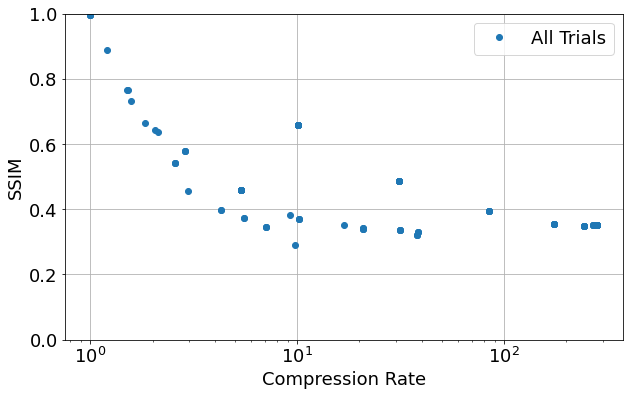

Results for image: image
../images/results/TPE_4.2.06_pareto_front.png saved


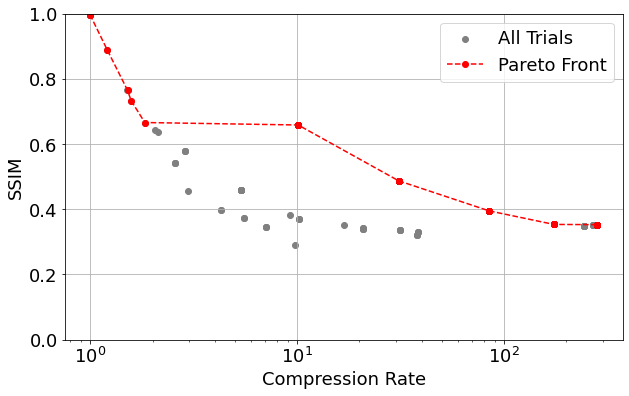

[I 2024-12-11 09:27:24,694] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:4.2.03_time:2024-12-11_09-27-24


image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 09:27:25,921] Trial 0 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.1376488208770752
SSIM Index : 0.20960156926467607

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31096
File saved.


[I 2024-12-11 09:27:28,716] Trial 1 finished with values: [6.834645669291339, 0.18345250406433108] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.6780197620391846
SSIM Index : 0.18345250406433108

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64235
DEFLATE applied. Bytes to write: 60958
File saved.


[I 2024-12-11 09:27:32,768] Trial 2 finished with values: [4.451062871934835, 0.24001120871486262] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.940218925476074
SSIM Index : 0.24001120871486262

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
DEFLATE applied. Bytes to write: 249093
File saved.


[I 2024-12-11 09:27:41,147] Trial 3 finished with values: [2.8739502668332007, 0.39761421370173733] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 8.264648914337158
SSIM Index : 0.39761421370173733

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 09:27:49,727] Trial 4 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 8.46181035041809
SSIM Index : 0.21044176185774047

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4924
File saved.


[I 2024-12-11 09:27:51,596] Trial 5 finished with values: [25.16492344402466, 0.18476026841425572] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.7407281398773193
SSIM Index : 0.18476026841425572

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126279
File saved.


[I 2024-12-11 09:27:56,994] Trial 6 finished with values: [3.4803260474990925, 0.3085174369885891] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.258110761642456
SSIM Index : 0.3085174369885891

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4153
File saved.


[I 2024-12-11 09:27:59,648] Trial 7 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.495344877243042
SSIM Index : 0.1733018660479305

image name:  4.2.03
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15274
File saved.


[I 2024-12-11 09:28:05,155] Trial 8 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.390057325363159
SSIM Index : 0.14841473192043858

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 09:28:06,332] Trial 9 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.0829012393951416
SSIM Index : 0.20164704952380272

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1151
File saved.


[I 2024-12-11 09:28:07,175] Trial 10 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.5460650465732574, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 9.710150883703287, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7304503917694092
SSIM Index : 0.17760382146513995

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:28:08,593] Trial 11 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.6104842273327785, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 13.800909892716907, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2897014617919922
SSIM Index : 0.1769590609355218

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:28:10,403] Trial 12 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.6561155206981004, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 11.379862085234848, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6725924015045166
SSIM Index : 0.21134736656993938

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:28:12,313] Trial 13 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.6361400838271065, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 11.143432919527932, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.779601812362671
SSIM Index : 0.21134736656993938

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 09:28:14,050] Trial 14 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.7189104115271138, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.67005516791073, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6051886081695557
SSIM Index : 0.1802367342115423

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081270
DEFLATE applied. Bytes to write: 775924
File saved.


[I 2024-12-11 09:28:33,635] Trial 15 finished with values: [1.4821272559054657, 0.660687205945738] and parameters: {'min_sparcity': 0.5415322678932304, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 32.21146576240811, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 19.443665027618408
SSIM Index : 0.660687205945738

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:28:35,345] Trial 16 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.7776295710602534, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.591080911563507, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.556509017944336
SSIM Index : 0.1769590609355218

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 175175
DEFLATE applied. Bytes to write: 151009
File saved.


[I 2024-12-11 09:28:38,468] Trial 17 finished with values: [2.9700354842949137, 0.33293869400944653] and parameters: {'min_sparcity': 0.3756217653366024, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 47.09435713844267, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.994792938232422
SSIM Index : 0.33293869400944653

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50035
File saved.


[I 2024-12-11 09:28:40,582] Trial 18 finished with values: [5.748918850165352, 0.2551073555143876] and parameters: {'min_sparcity': 0.5847445706002183, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.723009395705977, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.9762682914733887
SSIM Index : 0.2551073555143876

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2464
File saved.


[I 2024-12-11 09:28:42,882] Trial 19 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.3042766864549897, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 757.8932514473148, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.1211066246032715
SSIM Index : 0.1804354858169054

image name:  4.2.03
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:28:44,521] Trial 20 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.8036448397031265, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.05088803553867104, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.4689502716064453
SSIM Index : 0.1769590609355218

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50035
File saved.


[I 2024-12-11 09:28:46,488] Trial 21 finished with values: [5.748918850165352, 0.2551073555143876] and parameters: {'min_sparcity': 0.7175858075363041, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 3.710273602443878, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.8470385074615479
SSIM Index : 0.2551073555143876

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:28:50,766] Trial 22 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.4836468245845569, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 103.6700361289367, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.165574550628662
SSIM Index : 0.28643892398104714

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:28:55,223] Trial 23 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.4831145813210631, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 63.92629961194017, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.342077732086182
SSIM Index : 0.28643892398104714

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 09:29:00,897] Trial 24 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.604691520220758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 79.57067767769126, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.535009860992432
SSIM Index : 0.3992301054044307

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:29:01,787] Trial 25 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.9468101680923817, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.262625958324514, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7764370441436768
SSIM Index : 0.17760382146513995

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 09:29:03,364] Trial 26 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.6703508734527874, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.40665984543879874, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.450044870376587
SSIM Index : 0.1802367342115423

image name:  4.2.03
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 09:29:04,978] Trial 27 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.026393861641434424, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 21.352720393320684, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.4681673049926758
SSIM Index : 0.1839878013121695

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:29:06,393] Trial 28 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.443943391190064, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.294525323827288, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2554092407226562
SSIM Index : 0.1769590609355218

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4925
File saved.


[I 2024-12-11 09:29:08,260] Trial 29 finished with values: [25.16492344402466, 0.18476026841425572] and parameters: {'min_sparcity': 0.5154362700293201, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.06386535651489743, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.707387924194336
SSIM Index : 0.18476026841425572

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 778192
DEFLATE applied. Bytes to write: 682533
File saved.


[I 2024-12-11 09:29:17,103] Trial 30 finished with values: [1.6038343678793117, 0.6257441888030076] and parameters: {'min_sparcity': 0.7549053576107136, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 1.1951136768025576, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 8.725203514099121
SSIM Index : 0.6257441888030076

image name:  4.2.03
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 09:29:18,262] Trial 31 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.29535865769556, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 118.3591310636222, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.0419378280639648
SSIM Index : 0.20164704952380272

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70299
File saved.


[I 2024-12-11 09:29:21,991] Trial 32 finished with values: [5.118686296715742, 0.25020270718424026] and parameters: {'min_sparcity': 0.1813578025669202, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.009098636673972557, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.566394805908203
SSIM Index : 0.25020270718424026

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 09:29:23,111] Trial 33 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.9022460754315573, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 933.1462968577058, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9964768886566162
SSIM Index : 0.18703305587405059

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:29:23,985] Trial 34 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.8945204002505679, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 732.5175846811893, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7524545192718506
SSIM Index : 0.17760382146513995

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 09:29:25,153] Trial 35 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.8568469920828001, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 25.085803033001252, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.0482759475708008
SSIM Index : 0.20164704952380272

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:29:26,037] Trial 36 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.3722754818166402, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 171.8720797350147, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7661998271942139
SSIM Index : 0.17760382146513995

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 09:29:50,051] Trial 37 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9163796450909822, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 669.4384615869565, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 23.874682188034058
SSIM Index : 0.5299292936152326

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7689
File saved.


[I 2024-12-11 09:29:53,538] Trial 38 finished with values: [17.40871574777154, 0.1620309338292634] and parameters: {'min_sparcity': 0.5836126198345467, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.11096083187791, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.3273627758026123
SSIM Index : 0.1620309338292634

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 77862
File saved.


[I 2024-12-11 09:29:55,981] Trial 39 finished with values: [4.644709509303777, 0.2872839862199777] and parameters: {'min_sparcity': 0.642582224393569, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 328.7023435695849, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.308601140975952
SSIM Index : 0.2872839862199777

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:29:57,611] Trial 40 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.8057759239350246, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 97.2139296647278, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.478773593902588
SSIM Index : 0.1769590609355218

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:30:02,219] Trial 41 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.45889116631872906, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 980.3058818237954, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.485121250152588
SSIM Index : 0.28643892398104714

image name:  4.2.03
8 4
processed_blocks: 22824
bytes_written (without DEFLATE): 1456939
DEFLATE applied. Bytes to write: 1278749
File saved.


[I 2024-12-11 09:31:06,564] Trial 42 finished with values: [1.055205639129717, 0.9459873947478147] and parameters: {'min_sparcity': 0.4234097178369484, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 517.262884399873, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 64.20486903190613
SSIM Index : 0.9459873947478147

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 09:31:07,935] Trial 43 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.34270845063122335, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0011724646068832466, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2412784099578857
SSIM Index : 0.20164704952380272

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
DEFLATE applied. Bytes to write: 249093
File saved.


[I 2024-12-11 09:31:15,658] Trial 44 finished with values: [2.8739502668332007, 0.39761421370173733] and parameters: {'min_sparcity': 0.5155928990842067, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 35.628343688996715, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.577730894088745
SSIM Index : 0.39761421370173733

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:31:17,361] Trial 45 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.9136394568019167, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 7.664344569462328, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5832276344299316
SSIM Index : 0.21134736656993938

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 775978
File saved.


[I 2024-12-11 09:31:35,529] Trial 46 finished with values: [1.482068241863254, 0.660689741677592] and parameters: {'min_sparcity': 0.9867723707578977, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 17.239820210814067, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 18.046103477478027
SSIM Index : 0.660689741677592

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:31:36,425] Trial 47 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.7023212775316581, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 151.89098356059014, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7778544425964355
SSIM Index : 0.17760382146513995

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559670
DEFLATE applied. Bytes to write: 518682
File saved.


[I 2024-12-11 09:31:49,499] Trial 48 finished with values: [1.9712277728626435, 0.5553248372987564] and parameters: {'min_sparcity': 0.5695792693735094, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.8192010812502868, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 12.921295166015625
SSIM Index : 0.5553248372987564

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 09:31:50,902] Trial 49 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.653126445930929, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 342.1582178291257, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.270824909210205
SSIM Index : 0.20960156926467607

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 09:33:13,957] Trial 50 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.6165969061714877, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 35.73352702859343, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 82.89870715141296
SSIM Index : 0.8832513293618657

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:33:16,028] Trial 51 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.6166157355598135, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 40.14464031914948, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.9293911457061768
SSIM Index : 0.21134736656993938

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4153
File saved.


[I 2024-12-11 09:33:18,706] Trial 52 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.4856332376454175, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 205.1188168149179, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.509629726409912
SSIM Index : 0.1733018660479305

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 09:33:24,539] Trial 53 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.5527334051617622, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 61.18079850728987, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.6772730350494385
SSIM Index : 0.3992301054044307

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 09:33:25,706] Trial 54 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.7551564259149438, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 11.779137619464718, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.0192387104034424
SSIM Index : 0.18703305587405059

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 4196450
DEFLATE applied. Bytes to write: 3705723
File saved.


[I 2024-12-11 09:34:16,726] Trial 55 finished with values: [0.9996192811206089, 0.9991026642948393] and parameters: {'min_sparcity': 0.8248671158162979, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.002767377631559482, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 50.88561272621155
SSIM Index : 0.9991026642948393

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:34:17,707] Trial 56 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.406046876488541, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 456.85454537386033, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.8633689880371094
SSIM Index : 0.17760382146513995

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 578
File saved.


[I 2024-12-11 09:34:19,334] Trial 57 finished with values: [302.9066539013882, 0.17810926875517452] and parameters: {'min_sparcity': 0.24234809471733065, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 4.839392650885533, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.4788484573364258
SSIM Index : 0.17810926875517452

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 09:34:25,023] Trial 58 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.2081410163791088, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.014048813397850076, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.538366794586182
SSIM Index : 0.3992301054044307

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 217381
File saved.


[I 2024-12-11 09:34:39,674] Trial 59 finished with values: [10.339073886474297, 0.4707151981628961] and parameters: {'min_sparcity': 0.06321462122017085, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.84155190249415, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.522614002227783
SSIM Index : 0.4707151981628961

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 217381
File saved.


[I 2024-12-11 09:34:54,779] Trial 60 finished with values: [10.339073886474297, 0.4707151981628961] and parameters: {'min_sparcity': 0.10176861098457946, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 4.789175205030729, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.965617895126343
SSIM Index : 0.4707151981628961

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 217381
File saved.


[I 2024-12-11 09:35:09,842] Trial 61 finished with values: [10.339073886474297, 0.4707151981628961] and parameters: {'min_sparcity': 0.018002482616117373, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 9.266683856835211, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.933984756469727
SSIM Index : 0.4707151981628961

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 775978
File saved.


[I 2024-12-11 09:35:29,089] Trial 62 finished with values: [1.482068241863254, 0.660689741677592] and parameters: {'min_sparcity': 0.07299173920498837, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.3315264778908795, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 19.12116503715515
SSIM Index : 0.660689741677592

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:35:30,883] Trial 63 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.14657373578310257, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 14.852222619039647, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6291062831878662
SSIM Index : 0.21134736656993938

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:35:35,588] Trial 64 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.24889483059328493, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.40867502237380543, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.564245939254761
SSIM Index : 0.28643892398104714

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50035
File saved.


[I 2024-12-11 09:35:37,682] Trial 65 finished with values: [5.748918850165352, 0.2551073555143876] and parameters: {'min_sparcity': 0.06663957696694484, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 24.1219647269411, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.957082748413086
SSIM Index : 0.2551073555143876

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:35:42,268] Trial 66 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.18244638522733864, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 5.404941792837834, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.4433629512786865
SSIM Index : 0.28643892398104714

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 775978
File saved.


[I 2024-12-11 09:36:01,988] Trial 67 finished with values: [1.482068241863254, 0.660689741677592] and parameters: {'min_sparcity': 0.13421309273949977, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.183133996844141, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 19.582715034484863
SSIM Index : 0.660689741677592

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 09:36:03,011] Trial 68 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.33232982711362963, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.5418846437049407, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.8924648761749268
SSIM Index : 0.18703305587405059

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:36:04,751] Trial 69 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.6949546036881793, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 61.71004808487506, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6233413219451904
SSIM Index : 0.21134736656993938

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 578
File saved.


[I 2024-12-11 09:36:06,214] Trial 70 finished with values: [302.9066539013882, 0.17810926875517452] and parameters: {'min_sparcity': 0.7375940067883832, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.16650593452326798, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3257145881652832
SSIM Index : 0.17810926875517452

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 09:36:07,335] Trial 71 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.26971993152159685, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.000721820930711, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9828550815582275
SSIM Index : 0.18703305587405059

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:36:08,201] Trial 72 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.9125678116512923, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 27.563890671774608, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7435421943664551
SSIM Index : 0.17760382146513995

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 09:36:09,199] Trial 73 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.05240900260546093, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 529.9430917999993, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.875053882598877
SSIM Index : 0.18703305587405059

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 09:36:14,658] Trial 74 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.1679219094681052, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 119.85452286540288, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.322585582733154
SSIM Index : 0.3992301054044307

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 09:37:53,785] Trial 75 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.8716980309598036, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 16.439588301800118, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 98.97733640670776
SSIM Index : 0.8832513293618657

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:37:55,723] Trial 76 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.10459921639378872, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 9.922483292002564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.796022653579712
SSIM Index : 0.21134736656993938

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 09:37:57,013] Trial 77 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.9598842626741636, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 951.2354045741381, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.132761001586914
SSIM Index : 0.20164704952380272

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:37:58,807] Trial 78 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.37863729804376517, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.7127190651563953, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6601064205169678
SSIM Index : 0.21134736656993938

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 217381
File saved.


[I 2024-12-11 09:38:15,575] Trial 79 finished with values: [10.339073886474297, 0.4707151981628961] and parameters: {'min_sparcity': 0.21818544967982348, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 93.1875219190829, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 16.61796545982361
SSIM Index : 0.4707151981628961

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 09:38:17,111] Trial 80 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.7837049852070459, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 45.62612417960376, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3861284255981445
SSIM Index : 0.1839878013121695

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40057
DEFLATE applied. Bytes to write: 34399
File saved.


[I 2024-12-11 09:38:19,807] Trial 81 finished with values: [7.465455403492213, 0.2266879547766658] and parameters: {'min_sparcity': 0.6165982827314616, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.4556597565001708, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.504721164703369
SSIM Index : 0.2266879547766658

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:38:24,256] Trial 82 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.8358410633704392, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 300.1867294250096, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.31601095199585
SSIM Index : 0.28643892398104714

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:38:28,683] Trial 83 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.6677238691184377, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 5.693068780736777, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.290210485458374
SSIM Index : 0.28643892398104714

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:38:30,188] Trial 84 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.5313073596159479, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.1384664112640541, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3478608131408691
SSIM Index : 0.1769590609355218

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:38:31,983] Trial 85 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.7518938571979576, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 12.484861159269792, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6037607192993164
SSIM Index : 0.1769590609355218

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40057
DEFLATE applied. Bytes to write: 34399
File saved.


[I 2024-12-11 09:38:34,518] Trial 86 finished with values: [7.465455403492213, 0.2266879547766658] and parameters: {'min_sparcity': 0.5840052127788998, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 150.8163585664167, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.3747124671936035
SSIM Index : 0.2266879547766658

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 77862
File saved.


[I 2024-12-11 09:38:37,268] Trial 87 finished with values: [4.644709509303777, 0.2872839862199777] and parameters: {'min_sparcity': 0.6843947521194982, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 22.784447503116407, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.6048789024353027
SSIM Index : 0.2872839862199777

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 559670
DEFLATE applied. Bytes to write: 518682
File saved.


[I 2024-12-11 09:38:54,600] Trial 88 finished with values: [1.9712277728626435, 0.5553248372987564] and parameters: {'min_sparcity': 0.7195295713905714, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 227.05990154205043, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 17.18087410926819
SSIM Index : 0.5553248372987564

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 09:38:56,378] Trial 89 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.6354666049012299, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 34.1310515829567, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.610030174255371
SSIM Index : 0.1839878013121695

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 57099
File saved.


[I 2024-12-11 09:39:02,327] Trial 90 finished with values: [33.481771522302765, 0.28643892398104714] and parameters: {'min_sparcity': 0.4502673074018233, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.006061747190884531, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.774261474609375
SSIM Index : 0.28643892398104714

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
DEFLATE applied. Bytes to write: 249093
File saved.


[I 2024-12-11 09:39:12,904] Trial 91 finished with values: [2.8739502668332007, 0.39761421370173733] and parameters: {'min_sparcity': 0.4940889467216117, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 636.9750828883182, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 10.409187316894531
SSIM Index : 0.39761421370173733

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 217381
File saved.


[I 2024-12-11 09:39:28,266] Trial 92 finished with values: [10.339073886474297, 0.4707151981628961] and parameters: {'min_sparcity': 0.8149266074700434, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 8.053117068963832, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.232325553894043
SSIM Index : 0.4707151981628961

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 09:39:29,188] Trial 93 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.3172515474541987, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 17.590068336120037, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7990589141845703
SSIM Index : 0.17760382146513995

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3654817
DEFLATE applied. Bytes to write: 3223055
File saved.


[I 2024-12-11 09:40:04,517] Trial 94 finished with values: [0.9997519469008372, 0.9989392407186956] and parameters: {'min_sparcity': 0.2834803132109179, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 2.2761438216539136, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 35.18786811828613
SSIM Index : 0.9989392407186956

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 775978
File saved.


[I 2024-12-11 09:40:27,169] Trial 95 finished with values: [1.482068241863254, 0.660689741677592] and parameters: {'min_sparcity': 0.8813986925335325, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 4.034989661493946, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 22.511974811553955
SSIM Index : 0.660689741677592

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 09:40:51,549] Trial 96 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9093211861462219, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 67.95127246352799, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 24.22842001914978
SSIM Index : 0.5299292936152326

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15383
File saved.


[I 2024-12-11 09:40:53,457] Trial 97 finished with values: [94.8257155702083, 0.21134736656993938] and parameters: {'min_sparcity': 0.8462081614257239, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.05112791409026906, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.7673566341400146
SSIM Index : 0.21134736656993938

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 09:40:55,124] Trial 98 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.24838698573852222, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0021028409349150732, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5049078464508057
SSIM Index : 0.1769590609355218

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
DEFLATE applied. Bytes to write: 775978
File saved.


[I 2024-12-11 09:41:14,599] Trial 99 finished with values: [1.482068241863254, 0.660689741677592] and parameters: {'min_sparcity': 0.9378610869290627, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 11.212678018660187, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 19.316275119781494
SSIM Index : 0.660689741677592

../images/results/TPE_4.2.03_compression_vs_ssim.png saved


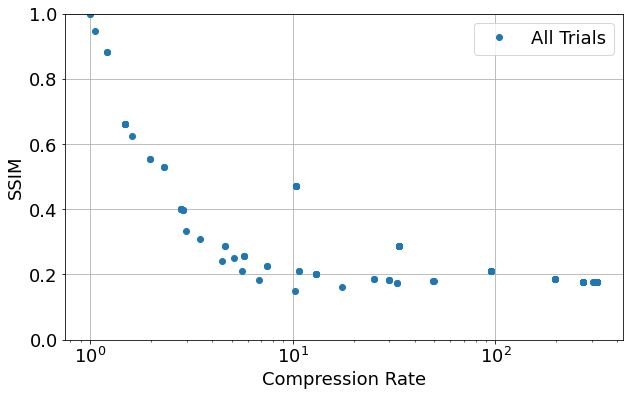

Results for image: image
../images/results/TPE_4.2.03_pareto_front.png saved


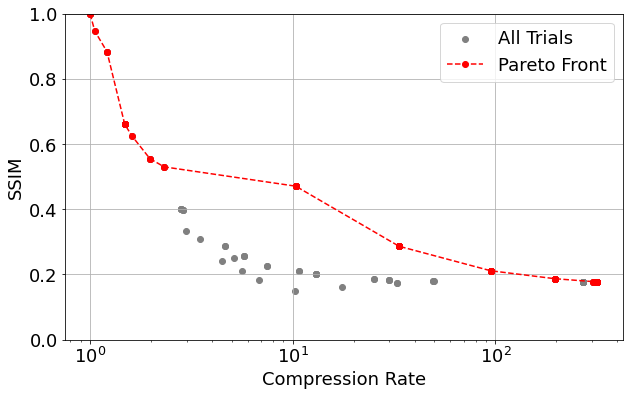

[I 2024-12-11 09:41:15,659] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:4.2.07_time:2024-12-11_09-41-15


image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 09:41:17,287] Trial 0 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5484204292297363
SSIM Index : 0.44617982677432755

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33560
DEFLATE applied. Bytes to write: 31118
File saved.


[I 2024-12-11 09:41:20,182] Trial 1 finished with values: [5.698335537918871, 0.3555334330036007] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.754121780395508
SSIM Index : 0.3555334330036007

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 09:41:24,436] Trial 2 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.144606590270996
SSIM Index : 0.4489657077257934

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262707
DEFLATE applied. Bytes to write: 249855
File saved.


[I 2024-12-11 09:41:32,753] Trial 3 finished with values: [2.2920780884902388, 0.5781928818547329] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.207176685333252
SSIM Index : 0.5781928818547329

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 09:41:41,649] Trial 4 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.781097412109375
SSIM Index : 0.41839355308777626

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4941
File saved.


[I 2024-12-11 09:41:43,420] Trial 5 finished with values: [20.245672436750997, 0.39853996668563885] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6636221408843994
SSIM Index : 0.39853996668563885

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126470
File saved.


[I 2024-12-11 09:41:49,086] Trial 6 finished with values: [2.619035073942538, 0.5172604552565858] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.520415782928467
SSIM Index : 0.5172604552565858

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4198
File saved.


[I 2024-12-11 09:41:51,437] Trial 7 finished with values: [29.691172247429787, 0.38094831933221335] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.2361879348754883
SSIM Index : 0.38094831933221335

image name:  4.2.07
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 09:41:58,087] Trial 8 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.4957122802734375
SSIM Index : 0.328797173589851

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12452
File saved.


[I 2024-12-11 09:41:59,387] Trial 9 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1978654861450195
SSIM Index : 0.44036741247906797

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:42:01,154] Trial 10 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6462719440460205
SSIM Index : 0.3861699207171572

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 09:42:02,864] Trial 11 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.6786440830104932, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5440034866333008
SSIM Index : 0.3922454544426941

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 355
File saved.


[I 2024-12-11 09:42:04,452] Trial 12 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.6433077671486415, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.0141401748985, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.440295934677124
SSIM Index : 0.3922454544426941

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:42:06,843] Trial 13 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6256686784685921, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 13.265287901477882, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.2499141693115234
SSIM Index : 0.4492846842701986

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:42:11,683] Trial 14 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.6203109251296234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.729360103607178
SSIM Index : 0.5552584680415636

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081360
DEFLATE applied. Bytes to write: 775881
File saved.


[I 2024-12-11 09:42:31,390] Trial 15 finished with values: [1.5402421111279947, 0.7881979654089707] and parameters: {'min_sparcity': 0.7674028378760763, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 6.795065796278994, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 19.569268703460693
SSIM Index : 0.7881979654089707

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:42:36,035] Trial 16 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.5709255861884776, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 2.589488546494979, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.510669708251953
SSIM Index : 0.5552584680415636

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:42:37,645] Trial 17 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.49800647956660665, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 984.7940308782788, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4709839820861816
SSIM Index : 0.38983996492857154

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78207
File saved.


[I 2024-12-11 09:42:40,228] Trial 18 finished with values: [4.161558834657586, 0.5287064864083536] and parameters: {'min_sparcity': 0.7704989271387993, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 56.05550543577921, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.438969850540161
SSIM Index : 0.5287064864083536

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:42:42,208] Trial 19 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.35463873268250473, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.035168375868930096, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8389196395874023
SSIM Index : 0.3861699207171572

image name:  4.2.07
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 09:42:43,186] Trial 20 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.7513333531776172, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 2.3691329778369523, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.856198787689209
SSIM Index : 0.395109178896216

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:42:45,113] Trial 21 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6066653537315065, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 40.09575746070031, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8037514686584473
SSIM Index : 0.4492846842701986

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 09:42:47,139] Trial 22 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.012130548355998527, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 57.25843719200402, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8732883930206299
SSIM Index : 0.40029127412705773

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:42:48,803] Trial 23 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.5557222406192883, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 3.4719819178969535, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5383670330047607
SSIM Index : 0.4492846842701986

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194114
File saved.


[I 2024-12-11 09:42:53,976] Trial 24 finished with values: [2.8067814094907155, 0.6342140925905084] and parameters: {'min_sparcity': 0.6998159710953578, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 28.332877629734906, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.057793378829956
SSIM Index : 0.6342140925905084

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 09:42:55,617] Trial 25 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.8794218646285838, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.9955387677148444, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.514559268951416
SSIM Index : 0.3787681504959404

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 09:42:56,545] Trial 26 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.5030265354431228, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 109.16594138564973, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.8074007034301758
SSIM Index : 0.395109178896216

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194114
File saved.


[I 2024-12-11 09:43:01,942] Trial 27 finished with values: [2.8067814094907155, 0.6342140925905084] and parameters: {'min_sparcity': 0.7105729944759445, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 7.420078816864357, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.2690911293029785
SSIM Index : 0.6342140925905084

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 09:43:03,402] Trial 28 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.814398855296045, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 890.5751442253897, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3365797996520996
SSIM Index : 0.3922454544426941

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 09:43:04,775] Trial 29 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.6131082748931094, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.05160810295622647, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2090132236480713
SSIM Index : 0.44617982677432755

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:43:06,363] Trial 30 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.3078687812445219, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.1089982330888149, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4440717697143555
SSIM Index : 0.38983996492857154

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:43:07,559] Trial 31 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.7220863636043444, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.008323850017473412, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0582633018493652
SSIM Index : 0.4050221601820932

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 09:43:08,470] Trial 32 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.9089662223762252, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 16.495627858879843, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.7824630737304688
SSIM Index : 0.395109178896216

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311420
DEFLATE applied. Bytes to write: 282901
File saved.


[I 2024-12-11 09:43:12,524] Trial 33 finished with values: [1.9820601496840684, 0.6524537696138234] and parameters: {'min_sparcity': 0.56799366915216, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.008130897586401254, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.9317922592163086
SSIM Index : 0.6524537696138234

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:43:13,584] Trial 34 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.41432720937292333, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.014765952336462532, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9435625076293945
SSIM Index : 0.4050221601820932

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119848
File saved.


[I 2024-12-11 09:43:23,239] Trial 35 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.6731436315121344, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0011256708839123622, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 9.516536235809326
SSIM Index : 0.49599456726194374

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12453
File saved.


[I 2024-12-11 09:43:24,535] Trial 36 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.8339707074153085, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.4849397047439395, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1714413166046143
SSIM Index : 0.44036741247906797

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8902
File saved.


[I 2024-12-11 09:43:26,415] Trial 37 finished with values: [15.596240873710252, 0.39831068973019423] and parameters: {'min_sparcity': 0.7366695330847627, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.9389256860024466, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.741410732269287
SSIM Index : 0.39831068973019423

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7744
File saved.


[I 2024-12-11 09:43:29,949] Trial 38 finished with values: [15.56149909692956, 0.36586014394225935] and parameters: {'min_sparcity': 0.4773407095488946, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 5.98243938220861, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.368553876876831
SSIM Index : 0.36586014394225935

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78207
File saved.


[I 2024-12-11 09:43:32,418] Trial 39 finished with values: [4.161558834657586, 0.5287064864083536] and parameters: {'min_sparcity': 0.16512034065488246, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.00464836235496451, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.3429572582244873
SSIM Index : 0.5287064864083536

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77452
DEFLATE applied. Bytes to write: 70496
File saved.


[I 2024-12-11 09:43:37,252] Trial 40 finished with values: [4.073254329703579, 0.44628841273018893] and parameters: {'min_sparcity': 0.5371707228144496, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 117.21683936951258, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.6906726360321045
SSIM Index : 0.44628841273018893

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:43:39,127] Trial 41 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6453991684399732, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 1.983016884745783, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.7488157749176025
SSIM Index : 0.4492846842701986

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:43:40,246] Trial 42 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.7585691386663519, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 23.97948741480042, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9936184883117676
SSIM Index : 0.4050221601820932

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194114
File saved.


[I 2024-12-11 09:43:45,828] Trial 43 finished with values: [2.8067814094907155, 0.6342140925905084] and parameters: {'min_sparcity': 0.6042842666941419, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 4.707071496555734, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.452640771865845
SSIM Index : 0.6342140925905084

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:44:00,900] Trial 44 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.7947304264231492, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 10.203933761571458, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.952125310897827
SSIM Index : 0.7110778554745097

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2553355
DEFLATE applied. Bytes to write: 2179382
File saved.


[I 2024-12-11 09:44:34,570] Trial 45 finished with values: [1.001386959865333, 0.9880349976072788] and parameters: {'min_sparcity': 0.9277417734399506, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 10.076783556983933, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 33.54253935813904
SSIM Index : 0.9880349976072788

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 355
File saved.


[I 2024-12-11 09:44:36,189] Trial 46 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.8078210273122708, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 21.99789642906107, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4655077457427979
SSIM Index : 0.3922454544426941

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 940605
DEFLATE applied. Bytes to write: 648488
File saved.


[I 2024-12-11 09:44:53,582] Trial 47 finished with values: [1.5274041813905666, 0.7748849752153809] and parameters: {'min_sparcity': 0.6559198572098183, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 122.46002859100459, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 17.248282194137573
SSIM Index : 0.7748849752153809

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:44:55,295] Trial 48 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.42604978343682215, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 10.629109231561516, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5852241516113281
SSIM Index : 0.4492846842701986

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:44:56,900] Trial 49 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.7182440325587327, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 373.7122941277936, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4737746715545654
SSIM Index : 0.38983996492857154

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 09:44:58,460] Trial 50 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.35645224675931453, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.25143879780777767, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4084422588348389
SSIM Index : 0.3922454544426941

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:45:02,816] Trial 51 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.6151146941686157, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.441799808373425, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.2139716148376465
SSIM Index : 0.5552584680415636

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:45:03,994] Trial 52 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.7809259851298023, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 63.345326088950614, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0603148937225342
SSIM Index : 0.4050221601820932

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 09:45:05,890] Trial 53 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.543354062594005, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.6040313017201178, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.7185704708099365
SSIM Index : 0.40029127412705773

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:45:07,809] Trial 54 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6867245765416381, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 35.3083143416816, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.7951438426971436
SSIM Index : 0.4492846842701986

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:45:12,443] Trial 55 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.583442324649097, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.762393705053002, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.5153303146362305
SSIM Index : 0.5552584680415636

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12453
File saved.


[I 2024-12-11 09:45:13,613] Trial 56 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.6447760632075253, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 13.654587414667299, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0439660549163818
SSIM Index : 0.44036741247906797

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:45:15,401] Trial 57 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.4574999319583248, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 7.789019031522576, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6639118194580078
SSIM Index : 0.4492846842701986

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4942
File saved.


[I 2024-12-11 09:45:17,049] Trial 58 finished with values: [20.245672436750997, 0.39853996668563885] and parameters: {'min_sparcity': 0.5242829186124731, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 65.1438701212079, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5103437900543213
SSIM Index : 0.39853996668563885

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194114
File saved.


[I 2024-12-11 09:45:22,363] Trial 59 finished with values: [2.8067814094907155, 0.6342140925905084] and parameters: {'min_sparcity': 0.7341510105065996, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 3.6029117815875558, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.177791595458984
SSIM Index : 0.6342140925905084

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:45:36,801] Trial 60 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.6227554651205129, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.42030040354640796, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.320945739746094
SSIM Index : 0.7110778554745097

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:45:50,911] Trial 61 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.781878418139375, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 20.700479600366283, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 13.998847246170044
SSIM Index : 0.7110778554745097

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081360
DEFLATE applied. Bytes to write: 775881
File saved.


[I 2024-12-11 09:46:09,206] Trial 62 finished with values: [1.5402421111279947, 0.7881979654089707] and parameters: {'min_sparcity': 0.6847629619731932, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.681377377567707, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 18.177810192108154
SSIM Index : 0.7881979654089707

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:46:13,566] Trial 63 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.8779728979087393, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 9.672387494966044, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.250868558883667
SSIM Index : 0.5552584680415636

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:46:15,269] Trial 64 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.7453943721047979, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 38.14436012777233, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5914335250854492
SSIM Index : 0.4492846842701986

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12453
File saved.


[I 2024-12-11 09:46:16,411] Trial 65 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.5835039717933186, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0022303237075226652, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.026956558227539
SSIM Index : 0.44036741247906797

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:46:20,647] Trial 66 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.704004732860622, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.15088402845765342, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.080970525741577
SSIM Index : 0.5552584680415636

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 09:46:22,713] Trial 67 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.8474479083073635, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 15.273346191652216, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.875962734222412
SSIM Index : 0.40029127412705773

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:46:24,495] Trial 68 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.7907357981133737, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.4519746745710238, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6653172969818115
SSIM Index : 0.4492846842701986

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:46:25,495] Trial 69 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.6688042601799105, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 87.8573486693054, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.891671895980835
SSIM Index : 0.4050221601820932

image name:  4.2.07
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119848
File saved.


[I 2024-12-11 09:46:34,380] Trial 70 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.945055360451506, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 29.16154621955118, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.70720648765564
SSIM Index : 0.49599456726194374

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2600620
DEFLATE applied. Bytes to write: 2224031
File saved.


[I 2024-12-11 09:47:06,818] Trial 71 finished with values: [1.0009836478230982, 0.9890022556151091] and parameters: {'min_sparcity': 0.057918188389236236, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 9.075289416816824, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 32.299893379211426
SSIM Index : 0.9890022556151091

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:47:21,782] Trial 72 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.014488415662545218, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.5062471662012307, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.842726945877075
SSIM Index : 0.7110778554745097

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2523410
DEFLATE applied. Bytes to write: 2156817
File saved.


[I 2024-12-11 09:47:52,431] Trial 73 finished with values: [1.000005803269175, 0.9902353898137682] and parameters: {'min_sparcity': 0.6333486353154706, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.1639682603877075, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 30.523643970489502
SSIM Index : 0.9902353898137682

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:47:56,533] Trial 74 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.51268464121264, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 4.657260757100676, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.9802494049072266
SSIM Index : 0.5552584680415636

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 09:47:58,128] Trial 75 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.5947691596337839, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 15.964865339534818, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.460256814956665
SSIM Index : 0.40029127412705773

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 355
File saved.


[I 2024-12-11 09:48:00,143] Trial 76 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.7179126204314082, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.019816622955623676, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.765817642211914
SSIM Index : 0.3922454544426941

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262707
DEFLATE applied. Bytes to write: 249855
File saved.


[I 2024-12-11 09:48:09,444] Trial 77 finished with values: [2.2920780884902388, 0.5781928818547329] and parameters: {'min_sparcity': 0.5612455177693977, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.07916376537988826, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 9.149243354797363
SSIM Index : 0.5781928818547329

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:48:11,181] Trial 78 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.8165590881124646, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 48.52137284887332, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5979020595550537
SSIM Index : 0.38983996492857154

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:48:26,033] Trial 79 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.23512100412970982, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 183.09473919746844, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.720019102096558
SSIM Index : 0.7110778554745097

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:48:27,049] Trial 80 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.7546953472708702, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 9.121826563370536, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.905750036239624
SSIM Index : 0.4050221601820932

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:48:41,348] Trial 81 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.6423497892001662, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.0707656313500955, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.184542417526245
SSIM Index : 0.7110778554745097

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:48:42,968] Trial 82 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6341991124436059, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 22.672740389589194, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5053391456604004
SSIM Index : 0.4492846842701986

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:48:44,798] Trial 83 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.669754962358556, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 11.71623487137141, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.688140869140625
SSIM Index : 0.3861699207171572

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33560
DEFLATE applied. Bytes to write: 31118
File saved.


[I 2024-12-11 09:48:48,015] Trial 84 finished with values: [5.698335537918871, 0.3555334330036007] and parameters: {'min_sparcity': 0.4831350820182772, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.664387811635027, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.065512180328369
SSIM Index : 0.3555334330036007

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:48:52,254] Trial 85 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.6951644371243952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.00512011060314804, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.122461557388306
SSIM Index : 0.5552584680415636

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12453
File saved.


[I 2024-12-11 09:48:53,480] Trial 86 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.7657854033078834, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.6407077838761395, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1141481399536133
SSIM Index : 0.44036741247906797

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 18610
DEFLATE applied. Bytes to write: 16856
File saved.


[I 2024-12-11 09:48:55,892] Trial 87 finished with values: [8.950947120545763, 0.38851659904114916] and parameters: {'min_sparcity': 0.7283835008861763, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 31.483173908575786, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.2761809825897217
SSIM Index : 0.38851659904114916

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:48:57,459] Trial 88 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.6594026839565091, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 20.405825291206707, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.409789800643921
SSIM Index : 0.38983996492857154

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:48:59,274] Trial 89 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.36784096304401614, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 6.722849608820686, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6807878017425537
SSIM Index : 0.4492846842701986

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:49:00,398] Trial 90 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.543927340521423, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 48.66408258590621, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0056838989257812
SSIM Index : 0.4050221601820932

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2507650
DEFLATE applied. Bytes to write: 2136523
File saved.


[I 2024-12-11 09:49:33,317] Trial 91 finished with values: [1.0017711839609023, 0.9870510199789816] and parameters: {'min_sparcity': 0.9328759104978122, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 11.127259214263512, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 32.7847535610199
SSIM Index : 0.9870510199789816

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
DEFLATE applied. Bytes to write: 213972
File saved.


[I 2024-12-11 09:49:47,862] Trial 92 finished with values: [9.881544490108, 0.7110778554745097] and parameters: {'min_sparcity': 0.612308623591245, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 16.228736472901318, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.414056539535522
SSIM Index : 0.7110778554745097

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
DEFLATE applied. Bytes to write: 15355
File saved.


[I 2024-12-11 09:49:49,516] Trial 93 finished with values: [76.00014701558365, 0.4492846842701986] and parameters: {'min_sparcity': 0.6282520241952959, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 10.097044285349655, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5307936668395996
SSIM Index : 0.4492846842701986

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50204
File saved.


[I 2024-12-11 09:49:51,368] Trial 94 finished with values: [5.055824506841143, 0.5093406680011131] and parameters: {'min_sparcity': 0.99567977118094, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 4.964185976443561, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.7279994487762451
SSIM Index : 0.5093406680011131

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 355
File saved.


[I 2024-12-11 09:49:52,747] Trial 95 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.6956349338066437, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.6026826571756407, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2493886947631836
SSIM Index : 0.3922454544426941

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
DEFLATE applied. Bytes to write: 56956
File saved.


[I 2024-12-11 09:49:56,777] Trial 96 finished with values: [28.444646197865083, 0.5552584680415636] and parameters: {'min_sparcity': 0.5783265412444885, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 12.229939918903108, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.893810987472534
SSIM Index : 0.5552584680415636

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 09:50:00,749] Trial 97 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.5981972990237984, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 7.973648221833082, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.8402211666107178
SSIM Index : 0.4489657077257934

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 09:50:01,784] Trial 98 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.15434587949712142, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.04590588417713599, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9254169464111328
SSIM Index : 0.4050221601820932

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 09:50:03,239] Trial 99 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.31329003825162816, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 23.73524988397553, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.328770637512207
SSIM Index : 0.38983996492857154

../images/results/TPE_4.2.07_compression_vs_ssim.png saved


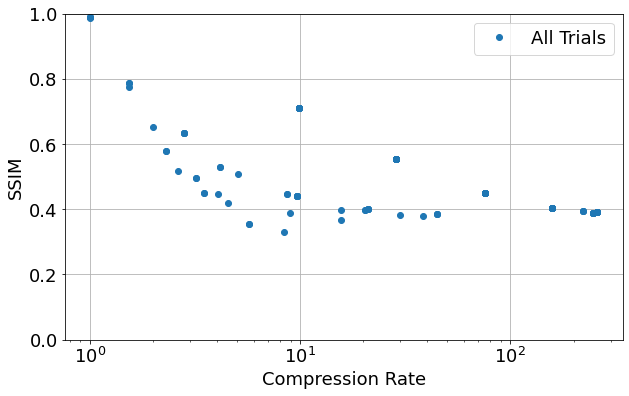

Results for image: image
../images/results/TPE_4.2.07_pareto_front.png saved


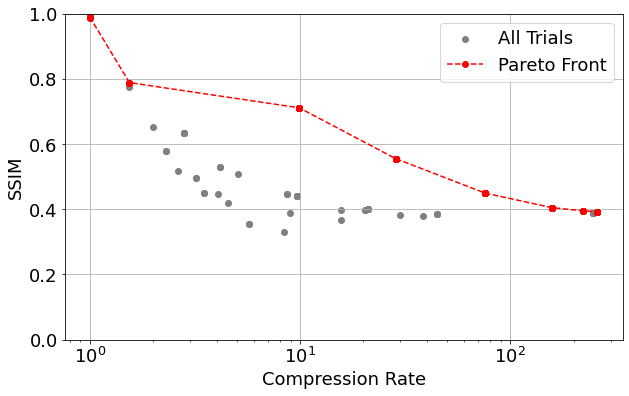

In [14]:
seed = 43
n_trials = 100

# search best hyperparameters of AQMP for each test image
for image_name in test_images:
    # create study and begin to optimize
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    study_name = f"multiobjTPE_trials:{n_trials}_seed:{seed}_image:{image_name}_time:{current_time}"
    storage_path = "sqlite:///"+study_name+".db" 
    sampler = TPESampler(seed=seed)  # Make the sampler behave in a deterministic way
    study = optuna.create_study(directions=['maximize', 'maximize'], study_name=study_name, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    plot_results(study, plot_name="../images/results/"+"TPE_"+image_name, log_xscale=True)

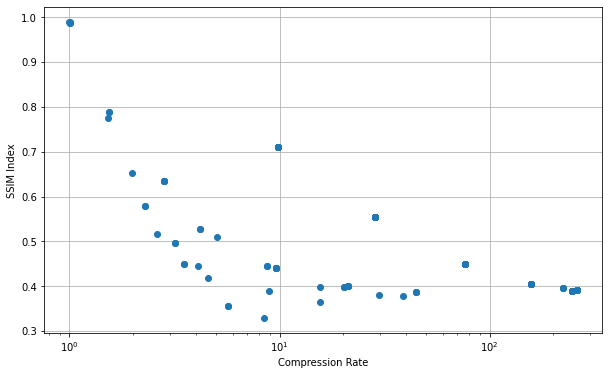

results for image  4.2.07


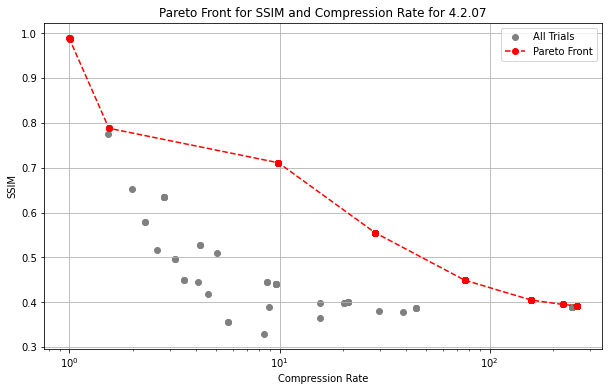

In [16]:
plot_results(study, log_xscale=True)

In [47]:
name = "multiobjTPE_trials:100_seed:43_image:Clock_time:2024-11-01_09-14-32"
study = optuna.load_study(
    study_name = name,
    storage="sqlite:///"+name+".db"
)

In [50]:
study.trials_dataframe()

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_exponent_a_cols,params_exponent_max_n,params_exponent_min_n,params_max_error,params_min_sparcity,user_attrs_compression_rate,user_attrs_execution_time,user_attrs_ssim,state
0,0,5.319064,0.603752,2024-11-01 09:14:33.514058,2024-11-01 09:14:33.852627,0 days 00:00:00.338569,3,5,5,0.027768,0.123904,5.319064,0.239926,0.603752,COMPLETE
1,1,4.114353,0.484083,2024-11-01 09:14:33.870519,2024-11-01 09:14:34.698788,0 days 00:00:00.828269,6,6,5,0.001493,0.860546,4.114353,0.744061,0.484083,COMPLETE
2,2,2.644592,0.586881,2024-11-01 09:14:34.721934,2024-11-01 09:14:35.939314,0 days 00:00:01.217380,7,6,6,0.002194,0.401001,2.644592,1.108739,0.586881,COMPLETE
3,3,1.560093,0.700546,2024-11-01 09:14:35.991769,2024-11-01 09:14:37.331884,0 days 00:00:01.340115,7,5,4,0.002884,0.228819,1.560093,1.145177,0.700546,COMPLETE
4,4,5.390260,0.587283,2024-11-01 09:14:37.359112,2024-11-01 09:14:42.189937,0 days 00:00:04.830825,8,7,7,0.205240,0.850450,5.390260,4.722713,0.587283,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,42.797695,0.563230,2024-11-01 09:17:56.723023,2024-11-01 09:17:57.441157,0 days 00:00:00.718134,1,7,7,27.653323,0.591873,42.797695,0.524108,0.563230,COMPLETE
96,96,38.821138,0.547838,2024-11-01 09:17:57.463853,2024-11-01 09:17:57.802065,0 days 00:00:00.338212,1,6,5,81.667937,0.753942,38.821138,0.210905,0.547838,COMPLETE
97,97,42.797695,0.563230,2024-11-01 09:17:57.823871,2024-11-01 09:17:58.296750,0 days 00:00:00.472879,1,7,6,6.391308,0.659906,42.797695,0.346700,0.563230,COMPLETE
98,98,15.403226,0.558752,2024-11-01 09:17:58.326893,2024-11-01 09:17:59.427261,0 days 00:00:01.100368,5,7,7,1.686103,0.712828,15.403226,0.949364,0.558752,COMPLETE


In [7]:
import pandas as pd
from scipy.stats import pearsonr

# Verifica que las columnas 'user_attrs_ssim' y 'user_attrs_compression_rate' existen y son numéricas
if 'user_attrs_ssim' in df.columns and 'user_attrs_compression_rate' in df.columns:
    metrics = ['user_attrs_ssim', 'user_attrs_compression_rate']
    correlations = {}

    for metric in metrics:
        correlations[metric] = {}
        for column in df.select_dtypes(include='number').columns:
            if column not in metrics:
                try:
                    corr, _ = pearsonr(df[column], df[metric])
                    correlations[metric][column] = corr
                except TypeError:
                    print(f"Column {column} or {metric} contains non-numeric values.")

    # Convierte el diccionario de correlaciones en un DataFrame para visualización
    correlations_df = pd.DataFrame(correlations)
    print(correlations_df)
else:
    print("Las columnas 'user_attrs_ssim' y 'user_attrs_compression_rate' no existen o no son numéricas.")


Column duration or user_attrs_ssim contains non-numeric values.
Column duration or user_attrs_compression_rate contains non-numeric values.
                           user_attrs_ssim  user_attrs_compression_rate
number                            0.302545                    -0.026497
values_0                         -0.589189                     1.000000
values_1                          1.000000                    -0.589189
params_exponent_a_cols            0.339103                    -0.530421
params_exponent_max_n            -0.805553                     0.601398
params_exponent_min_n            -0.677418                     0.544031
params_max_error                 -0.096131                     0.161032
params_min_sparcity               0.029707                    -0.050270
user_attrs_execution_time         0.787862                    -0.499986


# 3. AQMP with Random Search 

[I 2024-12-11 09:50:04,341] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:house_time:2024-12-11_09-50-04


image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 09:50:05,656] Trial 0 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2165913581848145
SSIM Index : 0.44354249646524163

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33450
DEFLATE applied. Bytes to write: 30977
File saved.


[I 2024-12-11 09:50:08,800] Trial 1 finished with values: [6.002969688248146, 0.4844573536378098] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.008486032485962
SSIM Index : 0.4844573536378098

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61192
File saved.


[I 2024-12-11 09:50:13,231] Trial 2 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.3180365562438965
SSIM Index : 0.5288257880168918

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262622
DEFLATE applied. Bytes to write: 249937
File saved.


[I 2024-12-11 09:50:21,910] Trial 3 finished with values: [2.314639104533325, 0.6313527862924693] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.562958002090454
SSIM Index : 0.6313527862924693

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 09:50:29,985] Trial 4 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.934373617172241
SSIM Index : 0.49730753986500015

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 09:50:31,927] Trial 5 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.8193156719207764
SSIM Index : 0.4183935493640571

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136242
DEFLATE applied. Bytes to write: 126352
File saved.


[I 2024-12-11 09:50:37,150] Trial 6 finished with values: [2.8090148329078746, 0.5756064168148192] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.102879524230957
SSIM Index : 0.5756064168148192

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 09:50:39,384] Trial 7 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.1149213314056396
SSIM Index : 0.4269487362670104

image name:  house
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15329
File saved.


[I 2024-12-11 09:50:44,469] Trial 8 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.964612007141113
SSIM Index : 0.4561742804428477

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12409
File saved.


[I 2024-12-11 09:50:45,737] Trial 9 finished with values: [8.443636832032976, 0.43889093507704774] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.1715803146362305
SSIM Index : 0.43889093507704774

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:50:47,506] Trial 10 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.6486129760742188
SSIM Index : 0.4223813698721153

image name:  house
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33450
DEFLATE applied. Bytes to write: 30977
File saved.


[I 2024-12-11 09:50:50,815] Trial 11 finished with values: [6.002969688248146, 0.4844573536378098] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.187511444091797
SSIM Index : 0.4844573536378098

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 09:50:52,534] Trial 12 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.6032640933990479
SSIM Index : 0.41816453386574115

image name:  house
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 09:50:54,457] Trial 13 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7975609302520752
SSIM Index : 0.41816453386574115

image name:  house
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 09:50:56,505] Trial 14 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.960994005203247
SSIM Index : 0.5108357642273367

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29921
File saved.


[I 2024-12-11 09:51:05,479] Trial 15 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.85619831085205
SSIM Index : 0.49730753986500015

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 09:51:07,930] Trial 16 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.3184351921081543
SSIM Index : 0.4269487362670104

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:51:09,804] Trial 17 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7640821933746338
SSIM Index : 0.4223813698721153

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77387
DEFLATE applied. Bytes to write: 70427
File saved.


[I 2024-12-11 09:51:13,936] Trial 18 finished with values: [4.394168063203256, 0.5244802264668693] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.0145463943481445
SSIM Index : 0.5244802264668693

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 09:51:16,954] Trial 19 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.905590057373047
SSIM Index : 0.4537034094553627

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:51:18,963] Trial 20 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.8665492534637451
SSIM Index : 0.4223813698721153

image name:  house
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98335
DEFLATE applied. Bytes to write: 78325
File saved.


[I 2024-12-11 09:51:21,126] Trial 21 finished with values: [3.884241623918601, 0.5519899931960078] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.074504852294922
SSIM Index : 0.5519899931960078

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 09:51:22,649] Trial 22 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4180514812469482
SSIM Index : 0.4096390252283048

image name:  house
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15330
File saved.


[I 2024-12-11 09:51:27,452] Trial 23 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.688475608825684
SSIM Index : 0.4561742804428477

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8886
File saved.


[I 2024-12-11 09:51:29,481] Trial 24 finished with values: [15.531444624966152, 0.42035452275086427] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9098448753356934
SSIM Index : 0.42035452275086427

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 09:51:30,554] Trial 25 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.9872784614562988
SSIM Index : 0.42597597508254315

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:51:32,564] Trial 26 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.884833574295044
SSIM Index : 0.4223813698721153

image name:  house
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 09:51:33,453] Trial 27 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8020937442779541
SSIM Index : 0.40929424793432573

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61192
File saved.


[I 2024-12-11 09:51:38,512] Trial 28 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.939167737960815
SSIM Index : 0.5288257880168918

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175125
DEFLATE applied. Bytes to write: 151934
File saved.


[I 2024-12-11 09:51:41,723] Trial 29 finished with values: [2.5149131845486035, 0.5730261291892312] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.11238169670105
SSIM Index : 0.5730261291892312

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12408
File saved.


[I 2024-12-11 09:51:42,862] Trial 30 finished with values: [8.443636832032976, 0.43889093507704774] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.045776605606079
SSIM Index : 0.43889093507704774

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15329
File saved.


[I 2024-12-11 09:51:47,661] Trial 31 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.679595470428467
SSIM Index : 0.4561742804428477

image name:  house
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 09:51:59,412] Trial 32 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 11.622030019760132
SSIM Index : 0.49730753986500015

image name:  house
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 09:52:01,554] Trial 33 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.0039641857147217
SSIM Index : 0.41313519521080644

image name:  house
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 92370
DEFLATE applied. Bytes to write: 73616
File saved.


[I 2024-12-11 09:52:03,956] Trial 34 finished with values: [3.929142690779559, 0.5517894353430582] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.2992045879364014
SSIM Index : 0.5517894353430582

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 09:52:05,742] Trial 35 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.6648907661437988
SSIM Index : 0.41313519521080644

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 09:52:07,446] Trial 36 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.5872821807861328
SSIM Index : 0.41793878593112205

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29921
File saved.


[I 2024-12-11 09:52:17,888] Trial 37 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 10.322104454040527
SSIM Index : 0.49730753986500015

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262622
DEFLATE applied. Bytes to write: 249937
File saved.


[I 2024-12-11 09:52:27,971] Trial 38 finished with values: [2.314639104533325, 0.6313527862924693] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 9.958290338516235
SSIM Index : 0.6313527862924693

image name:  house
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 09:52:30,607] Trial 39 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.516486167907715
SSIM Index : 0.4269487362670104

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61192
File saved.


[I 2024-12-11 09:52:36,108] Trial 40 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.3892011642456055
SSIM Index : 0.5288257880168918

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 665982
DEFLATE applied. Bytes to write: 577999
File saved.


[I 2024-12-11 09:53:18,729] Trial 41 finished with values: [1.3247673737120025, 0.9367573531499179] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 42.4730179309845
SSIM Index : 0.9367573531499179

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:53:20,594] Trial 42 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7305593490600586
SSIM Index : 0.4223813698721153

image name:  house
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 09:53:30,849] Trial 43 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 10.140889883041382
SSIM Index : 0.49730753986500015

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98335
DEFLATE applied. Bytes to write: 78325
File saved.


[I 2024-12-11 09:53:33,015] Trial 44 finished with values: [3.884241623918601, 0.5519899931960078] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.0789990425109863
SSIM Index : 0.5519899931960078

image name:  house
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 09:53:34,589] Trial 45 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4480419158935547
SSIM Index : 0.4183935493640571

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 09:53:36,843] Trial 46 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.0826783180236816
SSIM Index : 0.41816453386574115

image name:  house
16 4
processed_blocks: 39504
bytes_written (without DEFLATE): 1018254
DEFLATE applied. Bytes to write: 770126
File saved.


[I 2024-12-11 09:54:03,868] Trial 47 finished with values: [1.2608218982354138, 0.9362593742041453] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 26.916460275650024
SSIM Index : 0.9362593742041453

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8886
File saved.


[I 2024-12-11 09:54:06,328] Trial 48 finished with values: [15.531444624966152, 0.42035452275086427] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.345301866531372
SSIM Index : 0.42035452275086427

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15329
File saved.


[I 2024-12-11 09:54:11,841] Trial 49 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.339128732681274
SSIM Index : 0.4561742804428477

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 09:54:13,456] Trial 50 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.514538049697876
SSIM Index : 0.44354249646524163

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 09:54:14,976] Trial 51 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4034006595611572
SSIM Index : 0.41793878593112205

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 09:54:17,034] Trial 52 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9449338912963867
SSIM Index : 0.4223813698721153

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 09:54:29,238] Trial 53 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 12.072927236557007
SSIM Index : 0.49730753986500015

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 09:54:30,800] Trial 54 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4562253952026367
SSIM Index : 0.44354249646524163

image name:  house
32 4
processed_blocks: 49125
bytes_written (without DEFLATE): 3063476
DEFLATE applied. Bytes to write: 2634438
File saved.


[I 2024-12-11 10:00:23,556] Trial 55 finished with values: [0.977004690617275, 0.9965808419021284] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 352.6590521335602
SSIM Index : 0.9965808419021284

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 10:00:24,398] Trial 56 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7517468929290771
SSIM Index : 0.40929424793432573

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 253132
DEFLATE applied. Bytes to write: 177566
File saved.


[I 2024-12-11 10:00:29,177] Trial 57 finished with values: [2.4547341503993496, 0.6420727270219951] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.6890106201171875
SSIM Index : 0.6420727270219951

image name:  house
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 10:00:30,584] Trial 58 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3011047840118408
SSIM Index : 0.41793878593112205

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15329
File saved.


[I 2024-12-11 10:00:35,216] Trial 59 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.519546985626221
SSIM Index : 0.4561742804428477

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136242
DEFLATE applied. Bytes to write: 126352
File saved.


[I 2024-12-11 10:00:40,336] Trial 60 finished with values: [2.8090148329078746, 0.5756064168148192] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.003638029098511
SSIM Index : 0.5756064168148192

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:00:42,372] Trial 61 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9058630466461182
SSIM Index : 0.4223813698721153

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77387
DEFLATE applied. Bytes to write: 70427
File saved.


[I 2024-12-11 10:00:46,493] Trial 62 finished with values: [4.394168063203256, 0.5244802264668693] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.9975807666778564
SSIM Index : 0.5244802264668693

image name:  house
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2449
File saved.


[I 2024-12-11 10:00:48,547] Trial 63 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9344069957733154
SSIM Index : 0.4223813698721153

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 10:00:50,425] Trial 64 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.750868320465088
SSIM Index : 0.41313519521080644

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:00:53,524] Trial 65 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 2.968985080718994
SSIM Index : 0.4537034094553627

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3108255
DEFLATE applied. Bytes to write: 2695580
File saved.


[I 2024-12-11 10:01:29,743] Trial 66 finished with values: [0.979620287485029, 0.9971455648368037] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 36.122528314590454
SSIM Index : 0.9971455648368037

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 10:01:56,181] Trial 67 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 26.313987493515015
SSIM Index : 0.715312251851938

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 586
File saved.


[I 2024-12-11 10:01:57,838] Trial 68 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.537013053894043
SSIM Index : 0.4096390252283048

image name:  house
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:02:01,547] Trial 69 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.5704152584075928
SSIM Index : 0.4537034094553627

image name:  house
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50201
File saved.


[I 2024-12-11 10:02:03,594] Trial 70 finished with values: [4.392233251332906, 0.5108357642273367] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.9480342864990234
SSIM Index : 0.5108357642273367

image name:  house
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1285
File saved.


[I 2024-12-11 10:02:05,301] Trial 71 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.583932638168335
SSIM Index : 0.41313519521080644

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4940
File saved.


[I 2024-12-11 10:02:07,182] Trial 72 finished with values: [18.646822171651497, 0.4183935493640571] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.7554142475128174
SSIM Index : 0.4183935493640571

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 10:02:09,122] Trial 73 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.787792682647705
SSIM Index : 0.41816453386574115

image name:  house
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 10:02:10,235] Trial 74 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.016273021697998
SSIM Index : 0.42597597508254315

image name:  house
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 10:02:11,699] Trial 75 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.347381353378296
SSIM Index : 0.41793878593112205

image name:  house
8 4
processed_blocks: 49074
bytes_written (without DEFLATE): 3310844
DEFLATE applied. Bytes to write: 2918134
File saved.


[I 2024-12-11 10:03:08,546] Trial 76 finished with values: [0.9703991473127239, 0.9955775293285369] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 56.74813961982727
SSIM Index : 0.9955775293285369

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 76252
DEFLATE applied. Bytes to write: 69345
File saved.


[I 2024-12-11 10:03:12,717] Trial 77 finished with values: [4.393116323599808, 0.524442542568775] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 4.051617383956909
SSIM Index : 0.524442542568775

image name:  house
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28312
DEFLATE applied. Bytes to write: 23567
File saved.


[I 2024-12-11 10:03:14,026] Trial 78 finished with values: [7.570089911738019, 0.44354249646524163] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2106013298034668
SSIM Index : 0.44354249646524163

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194111
File saved.


[I 2024-12-11 10:03:19,581] Trial 79 finished with values: [2.4404124961441505, 0.6424043089905679] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.462947845458984
SSIM Index : 0.6424043089905679

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 10:03:21,042] Trial 80 finished with values: [219.55071770334928, 0.4096390252283048] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3584446907043457
SSIM Index : 0.4096390252283048

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:03:24,363] Trial 81 finished with values: [17.40417219798976, 0.4537034094553627] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.1898415088653564
SSIM Index : 0.4537034094553627

image name:  house
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 216532
DEFLATE applied. Bytes to write: 142370
File saved.


[I 2024-12-11 10:03:29,713] Trial 82 finished with values: [2.6519158527422992, 0.635644632231965] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.261401891708374
SSIM Index : 0.635644632231965

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29921
File saved.


[I 2024-12-11 10:03:39,706] Trial 83 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 9.87954568862915
SSIM Index : 0.49730753986500015

image name:  house
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 776392
DEFLATE applied. Bytes to write: 683234
File saved.


[I 2024-12-11 10:03:49,744] Trial 84 finished with values: [1.4385529855097907, 0.8074685020216984] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 9.945833206176758
SSIM Index : 0.8074685020216984

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1284
File saved.


[I 2024-12-11 10:03:51,260] Trial 85 finished with values: [33.6088039258771, 0.41313519521080644] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.4099528789520264
SSIM Index : 0.41313519521080644

image name:  house
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16142
DEFLATE applied. Bytes to write: 15330
File saved.


[I 2024-12-11 10:03:56,560] Trial 86 finished with values: [9.324926841164038, 0.4561742804428477] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 5.1903910636901855
SSIM Index : 0.4561742804428477

image name:  house
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136242
DEFLATE applied. Bytes to write: 126352
File saved.


[I 2024-12-11 10:04:00,659] Trial 87 finished with values: [2.8090148329078746, 0.5756064168148192] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.9853599071502686
SSIM Index : 0.5756064168148192

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 10:04:07,988] Trial 88 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.222753524780273
SSIM Index : 0.49730753986500015

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64330
DEFLATE applied. Bytes to write: 61193
File saved.


[I 2024-12-11 10:04:11,755] Trial 89 finished with values: [3.9407506011679834, 0.5288257880168918] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.6606552600860596
SSIM Index : 0.5288257880168918

image name:  house
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 347
File saved.


[I 2024-12-11 10:04:13,163] Trial 90 finished with values: [230.93155510820333, 0.41793878593112205] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3037123680114746
SSIM Index : 0.41793878593112205

image name:  house
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311265
DEFLATE applied. Bytes to write: 282973
File saved.


[I 2024-12-11 10:04:17,017] Trial 91 finished with values: [1.9876933606525422, 0.6691743027151494] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 3.762312173843384
SSIM Index : 0.6691743027151494

image name:  house
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1125
File saved.


[I 2024-12-11 10:04:17,816] Trial 92 finished with values: [198.64112554112555, 0.40929424793432573] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.7183759212493896
SSIM Index : 0.40929424793432573

image name:  house
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 842695
DEFLATE applied. Bytes to write: 543726
File saved.


[I 2024-12-11 10:04:35,845] Trial 93 finished with values: [1.202777974369661, 0.8619047327607557] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 17.94378089904785
SSIM Index : 0.8619047327607557

image name:  house
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4210
File saved.


[I 2024-12-11 10:04:37,693] Trial 94 finished with values: [30.812583937684664, 0.4269487362670104] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.751021146774292
SSIM Index : 0.4269487362670104

image name:  house
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 10:04:39,129] Trial 95 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.3292291164398193
SSIM Index : 0.41816453386574115

image name:  house
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3939
File saved.


[I 2024-12-11 10:04:40,106] Trial 96 finished with values: [143.30449718925672, 0.42597597508254315] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 0.8939366340637207
SSIM Index : 0.42597597508254315

image name:  house
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3121
File saved.


[I 2024-12-11 10:04:41,469] Trial 97 finished with values: [19.16152336409571, 0.41816453386574115] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.2626309394836426
SSIM Index : 0.41816453386574115

image name:  house
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2449
File saved.


[I 2024-12-11 10:04:43,205] Trial 98 finished with values: [39.76265164644714, 0.4223813698721153] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 1.63334059715271
SSIM Index : 0.4223813698721153

image name:  house
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 10:04:50,210] Trial 99 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.897294044494629
SSIM Index : 0.5675348915884081

../images/results/random_sampler_house_compression_vs_ssim.png saved


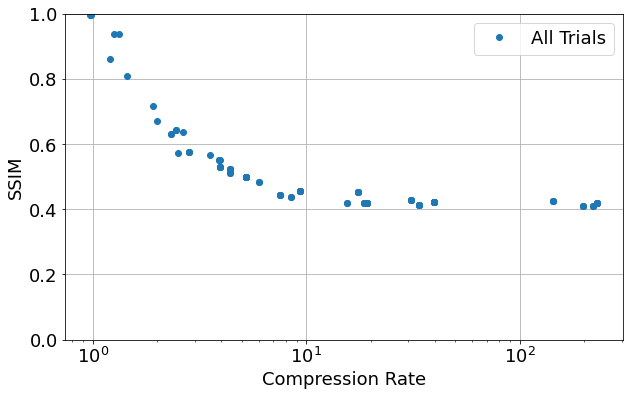

Results for image: image
../images/results/random_sampler_house_pareto_front.png saved


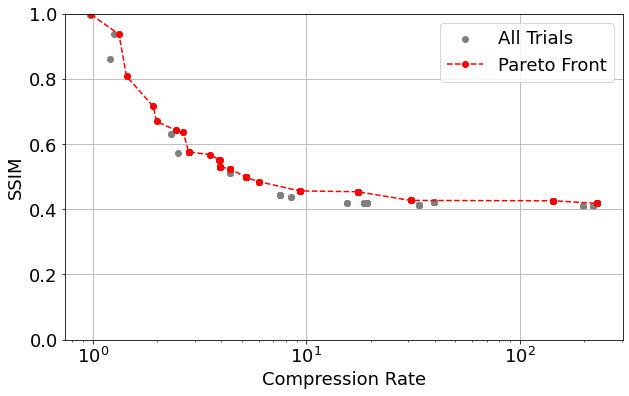

[I 2024-12-11 10:04:51,154] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:4.2.01_time:2024-12-11_10-04-51


image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28122
DEFLATE applied. Bytes to write: 23389
File saved.


[I 2024-12-11 10:04:52,303] Trial 0 finished with values: [8.522780222624903, 0.6489549944312978] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.063208818435669
SSIM Index : 0.6489549944312978

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31176
File saved.


[I 2024-12-11 10:04:54,821] Trial 1 finished with values: [5.355083562627919, 0.5894109980161297] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.4125101566314697
SSIM Index : 0.5894109980161297

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 10:04:58,501] Trial 2 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.5729100704193115
SSIM Index : 0.6697764050963556

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262647
DEFLATE applied. Bytes to write: 249907
File saved.


[I 2024-12-11 10:05:04,785] Trial 3 finished with values: [2.241396525705468, 0.7632066746406766] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.175589323043823
SSIM Index : 0.7632066746406766

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 10:05:11,892] Trial 4 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.002230167388916
SSIM Index : 0.6626479796518644

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4929
File saved.


[I 2024-12-11 10:05:13,407] Trial 5 finished with values: [18.456600953003832, 0.6228291759344704] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4107253551483154
SSIM Index : 0.6228291759344704

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136282
DEFLATE applied. Bytes to write: 126299
File saved.


[I 2024-12-11 10:05:17,477] Trial 6 finished with values: [2.635443696593312, 0.715272543937196] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.959228992462158
SSIM Index : 0.715272543937196

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4552
DEFLATE applied. Bytes to write: 4159
File saved.


[I 2024-12-11 10:05:19,773] Trial 7 finished with values: [21.49989116238572, 0.6071503033540541] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.1340720653533936
SSIM Index : 0.6071503033540541

image name:  4.2.01
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:05:24,486] Trial 8 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.606120824813843
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 10:05:25,616] Trial 9 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0380969047546387
SSIM Index : 0.6504376234947409

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2455
File saved.


[I 2024-12-11 10:05:27,199] Trial 10 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4788966178894043
SSIM Index : 0.6264881419460767

image name:  4.2.01
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31176
File saved.


[I 2024-12-11 10:05:29,675] Trial 11 finished with values: [5.355083562627919, 0.5894109980161297] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.3678717613220215
SSIM Index : 0.5894109980161297

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 10:05:31,136] Trial 12 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3512201309204102
SSIM Index : 0.6210865534424851

image name:  4.2.01
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 10:05:32,701] Trial 13 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4566054344177246
SSIM Index : 0.6210865534424851

image name:  4.2.01
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50052
File saved.


[I 2024-12-11 10:05:34,739] Trial 14 finished with values: [5.275920089738796, 0.7008934646623062] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9115524291992188
SSIM Index : 0.7008934646623062

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29933
File saved.


[I 2024-12-11 10:05:43,067] Trial 15 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.220657110214233
SSIM Index : 0.6626479796518644

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4552
DEFLATE applied. Bytes to write: 4159
File saved.


[I 2024-12-11 10:05:45,185] Trial 16 finished with values: [21.49989116238572, 0.6071503033540541] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.0018064975738525
SSIM Index : 0.6071503033540541

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2455
File saved.


[I 2024-12-11 10:05:46,875] Trial 17 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5846750736236572
SSIM Index : 0.6264881419460767

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77522
DEFLATE applied. Bytes to write: 70402
File saved.


[I 2024-12-11 10:05:49,944] Trial 18 finished with values: [4.076288149233404, 0.6697171454130536] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.956818103790283
SSIM Index : 0.6697171454130536

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 10:05:52,842] Trial 19 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.789194345474243
SSIM Index : 0.5768626426872626

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2454
File saved.


[I 2024-12-11 10:05:54,666] Trial 20 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.712759017944336
SSIM Index : 0.6264881419460767

image name:  4.2.01
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78090
File saved.


[I 2024-12-11 10:05:56,883] Trial 21 finished with values: [4.1688069135072965, 0.7205591899140703] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.126121759414673
SSIM Index : 0.7205591899140703

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 10:05:58,264] Trial 22 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2767443656921387
SSIM Index : 0.6356385237265485

image name:  4.2.01
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:06:03,092] Trial 23 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.719529628753662
SSIM Index : 0.5231643192615097

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10220
DEFLATE applied. Bytes to write: 8839
File saved.


[I 2024-12-11 10:06:04,715] Trial 24 finished with values: [13.12433976680065, 0.6137336785092552] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5107343196868896
SSIM Index : 0.6137336785092552

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3878
File saved.


[I 2024-12-11 10:06:05,778] Trial 25 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9760475158691406
SSIM Index : 0.6423701532399569

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2454
File saved.


[I 2024-12-11 10:06:07,476] Trial 26 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5916485786437988
SSIM Index : 0.6264881419460767

image name:  4.2.01
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 10:06:08,380] Trial 27 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.8168783187866211
SSIM Index : 0.6306026614046821

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 10:06:11,830] Trial 28 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.3435988426208496
SSIM Index : 0.6697764050963556

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175160
DEFLATE applied. Bytes to write: 151741
File saved.


[I 2024-12-11 10:06:14,557] Trial 29 finished with values: [2.4090659642190757, 0.7073286420573649] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.637061357498169
SSIM Index : 0.7073286420573649

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12381
File saved.


[I 2024-12-11 10:06:15,629] Trial 30 finished with values: [10.503868343391913, 0.6504376234947409] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9846696853637695
SSIM Index : 0.6504376234947409

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:06:19,718] Trial 31 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.9455647468566895
SSIM Index : 0.5231643192615097

image name:  4.2.01
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 10:06:28,463] Trial 32 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.634317398071289
SSIM Index : 0.6626479796518644

image name:  4.2.01
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 10:06:29,996] Trial 33 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4290344715118408
SSIM Index : 0.6046521569314206

image name:  4.2.01
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98085
DEFLATE applied. Bytes to write: 77907
File saved.


[I 2024-12-11 10:06:32,150] Trial 34 finished with values: [4.170126977760421, 0.7205429694900801] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.0645835399627686
SSIM Index : 0.7205429694900801

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 10:06:33,597] Trial 35 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3435468673706055
SSIM Index : 0.6046521569314206

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 10:06:34,964] Trial 36 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2655749320983887
SSIM Index : 0.6347237508901792

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29933
File saved.


[I 2024-12-11 10:06:43,105] Trial 37 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 8.036272048950195
SSIM Index : 0.6626479796518644

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262647
DEFLATE applied. Bytes to write: 249907
File saved.


[I 2024-12-11 10:06:49,165] Trial 38 finished with values: [2.241396525705468, 0.7632066746406766] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 5.947143316268921
SSIM Index : 0.7632066746406766

image name:  4.2.01
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4552
DEFLATE applied. Bytes to write: 4159
File saved.


[I 2024-12-11 10:06:51,268] Trial 39 finished with values: [21.49989116238572, 0.6071503033540541] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9978764057159424
SSIM Index : 0.6071503033540541

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 10:06:54,793] Trial 40 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.4163296222686768
SSIM Index : 0.6697764050963556

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 354692
DEFLATE applied. Bytes to write: 277827
File saved.


[I 2024-12-11 10:07:07,059] Trial 41 finished with values: [1.9542648542767258, 0.8859567044939965] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 12.155992269515991
SSIM Index : 0.8859567044939965

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2455
File saved.


[I 2024-12-11 10:07:08,762] Trial 42 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5983359813690186
SSIM Index : 0.6264881419460767

image name:  4.2.01
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 10:07:16,660] Trial 43 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.793553590774536
SSIM Index : 0.6626479796518644

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78090
File saved.


[I 2024-12-11 10:07:18,668] Trial 44 finished with values: [4.1688069135072965, 0.7205591899140703] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.9258408546447754
SSIM Index : 0.7205591899140703

image name:  4.2.01
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4930
File saved.


[I 2024-12-11 10:07:20,133] Trial 45 finished with values: [18.456600953003832, 0.6228291759344704] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3629724979400635
SSIM Index : 0.6228291759344704

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 10:07:21,626] Trial 46 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.387282133102417
SSIM Index : 0.6210865534424851

image name:  4.2.01
16 4
processed_blocks: 38031
bytes_written (without DEFLATE): 668483
DEFLATE applied. Bytes to write: 441614
File saved.


[I 2024-12-11 10:07:42,719] Trial 47 finished with values: [1.399223680575723, 0.8739278623115204] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 21.010360717773438
SSIM Index : 0.8739278623115204

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10220
DEFLATE applied. Bytes to write: 8839
File saved.


[I 2024-12-11 10:07:44,155] Trial 48 finished with values: [13.12433976680065, 0.6137336785092552] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3379302024841309
SSIM Index : 0.6137336785092552

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:07:48,340] Trial 49 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.082222938537598
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28122
DEFLATE applied. Bytes to write: 23389
File saved.


[I 2024-12-11 10:07:49,421] Trial 50 finished with values: [8.522780222624903, 0.6489549944312978] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0012543201446533
SSIM Index : 0.6489549944312978

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 10:07:50,651] Trial 51 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.1350102424621582
SSIM Index : 0.6347237508901792

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2454
File saved.


[I 2024-12-11 10:07:52,259] Trial 52 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.507751703262329
SSIM Index : 0.6264881419460767

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 10:07:58,883] Trial 53 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.520127534866333
SSIM Index : 0.6626479796518644

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28122
DEFLATE applied. Bytes to write: 23389
File saved.


[I 2024-12-11 10:07:59,954] Trial 54 finished with values: [8.522780222624903, 0.6489549944312978] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9918489456176758
SSIM Index : 0.6489549944312978

image name:  4.2.01
32 4
processed_blocks: 49149
bytes_written (without DEFLATE): 2947044
DEFLATE applied. Bytes to write: 2523334
File saved.


[I 2024-12-11 10:10:36,395] Trial 55 finished with values: [0.9821558196191518, 0.9939261584504363] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 156.35480046272278
SSIM Index : 0.9939261584504363

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 10:10:37,134] Trial 56 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.6613450050354004
SSIM Index : 0.6306026614046821

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 266722
DEFLATE applied. Bytes to write: 190874
File saved.


[I 2024-12-11 10:10:41,587] Trial 57 finished with values: [2.625304006910758, 0.7813487924110781] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.373128890991211
SSIM Index : 0.7813487924110781

image name:  4.2.01
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 10:10:42,845] Trial 58 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.1603236198425293
SSIM Index : 0.6347237508901792

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:10:47,127] Trial 59 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.176462173461914
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136282
DEFLATE applied. Bytes to write: 126299
File saved.


[I 2024-12-11 10:10:50,909] Trial 60 finished with values: [2.635443696593312, 0.715272543937196] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.675335645675659
SSIM Index : 0.715272543937196

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2454
File saved.


[I 2024-12-11 10:10:52,616] Trial 61 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.6007533073425293
SSIM Index : 0.6264881419460767

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77522
DEFLATE applied. Bytes to write: 70402
File saved.


[I 2024-12-11 10:10:55,562] Trial 62 finished with values: [4.076288149233404, 0.6697171454130536] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.8358335494995117
SSIM Index : 0.6697171454130536

image name:  4.2.01
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2455
File saved.


[I 2024-12-11 10:10:57,381] Trial 63 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7125391960144043
SSIM Index : 0.6264881419460767

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1287
File saved.


[I 2024-12-11 10:10:58,970] Trial 64 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4816296100616455
SSIM Index : 0.6046521569314206

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 10:11:01,805] Trial 65 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.7281548976898193
SSIM Index : 0.5768626426872626

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2994305
DEFLATE applied. Bytes to write: 2584264
File saved.


[I 2024-12-11 10:11:33,023] Trial 66 finished with values: [0.9844317643834251, 0.9949818538126406] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 31.13218879699707
SSIM Index : 0.9949818538126406

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 10:11:46,571] Trial 67 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 13.442433595657349
SSIM Index : 0.8105133925438435

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 586
File saved.


[I 2024-12-11 10:11:48,168] Trial 68 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.4937622547149658
SSIM Index : 0.6356385237265485

image name:  4.2.01
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 10:11:51,232] Trial 69 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.959167718887329
SSIM Index : 0.5768626426872626

image name:  4.2.01
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50052
File saved.


[I 2024-12-11 10:11:53,073] Trial 70 finished with values: [5.275920089738796, 0.7008934646623062] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.7533960342407227
SSIM Index : 0.7008934646623062

image name:  4.2.01
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1287
File saved.


[I 2024-12-11 10:11:54,550] Trial 71 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3720920085906982
SSIM Index : 0.6046521569314206

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4929
File saved.


[I 2024-12-11 10:11:56,037] Trial 72 finished with values: [18.456600953003832, 0.6228291759344704] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3824143409729004
SSIM Index : 0.6228291759344704

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:11:57,516] Trial 73 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3740227222442627
SSIM Index : 0.6210865534424851

image name:  4.2.01
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3879
File saved.


[I 2024-12-11 10:11:58,549] Trial 74 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.9491488933563232
SSIM Index : 0.6423701532399569

image name:  4.2.01
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 10:11:59,857] Trial 75 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2054166793823242
SSIM Index : 0.6347237508901792

image name:  4.2.01
8 4
processed_blocks: 49146
bytes_written (without DEFLATE): 3289188
DEFLATE applied. Bytes to write: 2899382
File saved.


[I 2024-12-11 10:12:43,718] Trial 76 finished with values: [0.9802574936916775, 0.994256269704362] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 43.77602028846741
SSIM Index : 0.994256269704362

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77522
DEFLATE applied. Bytes to write: 70402
File saved.


[I 2024-12-11 10:12:46,296] Trial 77 finished with values: [4.076288149233404, 0.6697171454130536] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.473524808883667
SSIM Index : 0.6697171454130536

image name:  4.2.01
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28122
DEFLATE applied. Bytes to write: 23389
File saved.


[I 2024-12-11 10:12:47,434] Trial 78 finished with values: [8.522780222624903, 0.6489549944312978] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.0568022727966309
SSIM Index : 0.6489549944312978

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193990
File saved.


[I 2024-12-11 10:12:52,020] Trial 79 finished with values: [2.6225331731375583, 0.78144170880021] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.5024940967559814
SSIM Index : 0.78144170880021

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 585
File saved.


[I 2024-12-11 10:12:53,282] Trial 80 finished with values: [190.2176215695715, 0.6356385237265485] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.1690990924835205
SSIM Index : 0.6356385237265485

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
DEFLATE applied. Bytes to write: 7721
File saved.


[I 2024-12-11 10:12:55,876] Trial 81 finished with values: [12.568220136790202, 0.5768626426872626] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 2.493424654006958
SSIM Index : 0.5768626426872626

image name:  4.2.01
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 188367
DEFLATE applied. Bytes to write: 116600
File saved.


[I 2024-12-11 10:12:59,879] Trial 82 finished with values: [3.1154446669926035, 0.7665386148350383] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.918765068054199
SSIM Index : 0.7665386148350383

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29933
File saved.


[I 2024-12-11 10:13:07,306] Trial 83 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.326489448547363
SSIM Index : 0.6626479796518644

image name:  4.2.01
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 776977
DEFLATE applied. Bytes to write: 682252
File saved.


[I 2024-12-11 10:13:15,222] Trial 84 finished with values: [1.5339177835411781, 0.8628166255066197] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.833141803741455
SSIM Index : 0.8628166255066197

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1286
File saved.


[I 2024-12-11 10:13:16,545] Trial 85 finished with values: [29.028802351212345, 0.6046521569314206] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2266623973846436
SSIM Index : 0.6046521569314206

image name:  4.2.01
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15357
File saved.


[I 2024-12-11 10:13:20,896] Trial 86 finished with values: [7.087181143041653, 0.5231643192615097] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 4.251307010650635
SSIM Index : 0.5231643192615097

image name:  4.2.01
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136282
DEFLATE applied. Bytes to write: 126299
File saved.


[I 2024-12-11 10:13:24,629] Trial 87 finished with values: [2.635443696593312, 0.715272543937196] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.628588914871216
SSIM Index : 0.715272543937196

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 10:13:31,491] Trial 88 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.756958961486816
SSIM Index : 0.6626479796518644

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64150
DEFLATE applied. Bytes to write: 61032
File saved.


[I 2024-12-11 10:13:35,062] Trial 89 finished with values: [3.2043375291980274, 0.6697764050963556] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.4666664600372314
SSIM Index : 0.6697764050963556

image name:  4.2.01
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 339
File saved.


[I 2024-12-11 10:13:36,438] Trial 90 finished with values: [198.63348416289594, 0.6347237508901792] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2740864753723145
SSIM Index : 0.6347237508901792

image name:  4.2.01
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311320
DEFLATE applied. Bytes to write: 282664
File saved.


[I 2024-12-11 10:13:40,391] Trial 91 finished with values: [1.9778427465782913, 0.7963017515995175] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 3.862316608428955
SSIM Index : 0.7963017515995175

image name:  4.2.01
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1146
File saved.


[I 2024-12-11 10:13:41,191] Trial 92 finished with values: [172.90240700218817, 0.6306026614046821] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.7190306186676025
SSIM Index : 0.6306026614046821

image name:  4.2.01
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 665280
DEFLATE applied. Bytes to write: 360741
File saved.


[I 2024-12-11 10:13:58,219] Trial 93 finished with values: [1.547860086818887, 0.7947162520563946] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 16.943045377731323
SSIM Index : 0.7947162520563946

image name:  4.2.01
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4552
DEFLATE applied. Bytes to write: 4159
File saved.


[I 2024-12-11 10:14:00,136] Trial 94 finished with values: [21.49989116238572, 0.6071503033540541] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.819875717163086
SSIM Index : 0.6071503033540541

image name:  4.2.01
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3129
File saved.


[I 2024-12-11 10:14:01,521] Trial 95 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.2831518650054932
SSIM Index : 0.6210865534424851

image name:  4.2.01
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3878
File saved.


[I 2024-12-11 10:14:02,501] Trial 96 finished with values: [130.39009900990098, 0.6423701532399569] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 0.8891997337341309
SSIM Index : 0.6423701532399569

image name:  4.2.01
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:14:03,929] Trial 97 finished with values: [20.741390172196557, 0.6210865534424851] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.3251678943634033
SSIM Index : 0.6210865534424851

image name:  4.2.01
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2455
File saved.


[I 2024-12-11 10:14:05,622] Trial 98 finished with values: [31.413055577641728, 0.6264881419460767] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 1.5945672988891602
SSIM Index : 0.6264881419460767

image name:  4.2.01
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 10:14:12,019] Trial 99 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.2895567417144775
SSIM Index : 0.6910119301865175

../images/results/random_sampler_4.2.01_compression_vs_ssim.png saved


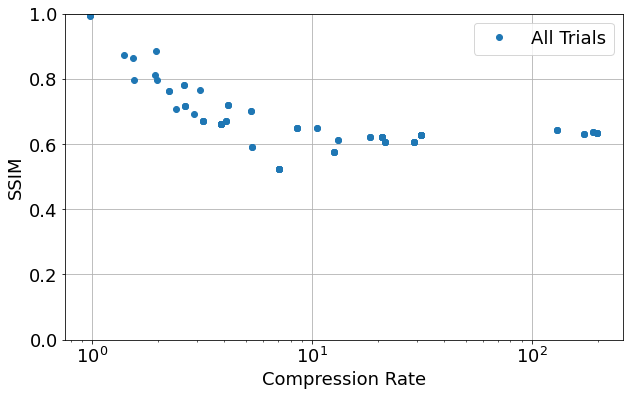

Results for image: image
../images/results/random_sampler_4.2.01_pareto_front.png saved


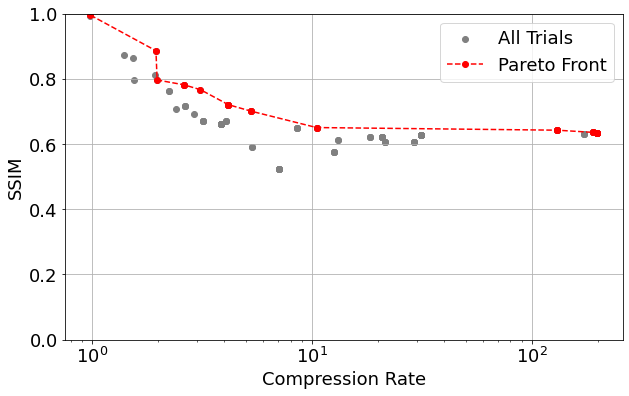

[I 2024-12-11 10:14:12,931] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:4.2.05_time:2024-12-11_10-14-12


image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 27512
DEFLATE applied. Bytes to write: 22908
File saved.


[I 2024-12-11 10:14:14,099] Trial 0 finished with values: [8.65804765255856, 0.5688071873687938] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0821192264556885
SSIM Index : 0.5688071873687938

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33535
DEFLATE applied. Bytes to write: 31148
File saved.


[I 2024-12-11 10:14:16,557] Trial 1 finished with values: [6.242052620134812, 0.5617518141388579] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.3539435863494873
SSIM Index : 0.5617518141388579

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61139
File saved.


[I 2024-12-11 10:14:19,996] Trial 2 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.3325796127319336
SSIM Index : 0.6087622486063672

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262657
DEFLATE applied. Bytes to write: 250197
File saved.


[I 2024-12-11 10:14:26,519] Trial 3 finished with values: [2.3489161148143705, 0.6990703605021341] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.415107011795044
SSIM Index : 0.6990703605021341

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:14:33,811] Trial 4 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.186904191970825
SSIM Index : 0.5862839738572689

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4960
File saved.


[I 2024-12-11 10:14:35,315] Trial 5 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4011986255645752
SSIM Index : 0.5459570210290938

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136352
DEFLATE applied. Bytes to write: 126650
File saved.


[I 2024-12-11 10:14:39,287] Trial 6 finished with values: [2.856286233566378, 0.6486337178097701] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.8619070053100586
SSIM Index : 0.6486337178097701

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 10:14:41,355] Trial 7 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.9622304439544678
SSIM Index : 0.5417003053903997

image name:  4.2.05
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15327
File saved.


[I 2024-12-11 10:14:46,095] Trial 8 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.634000062942505
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16907
DEFLATE applied. Bytes to write: 12443
File saved.


[I 2024-12-11 10:14:47,307] Trial 9 finished with values: [9.234570019300879, 0.5602533489303304] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0728349685668945
SSIM Index : 0.5602533489303304

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:14:49,045] Trial 10 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6311907768249512
SSIM Index : 0.528652460992648

image name:  4.2.05
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33535
DEFLATE applied. Bytes to write: 31148
File saved.


[I 2024-12-11 10:14:51,598] Trial 11 finished with values: [6.242052620134812, 0.5617518141388579] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.4492645263671875
SSIM Index : 0.5617518141388579

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 10:14:53,080] Trial 12 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3774113655090332
SSIM Index : 0.5485143072349075

image name:  4.2.05
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3147
File saved.


[I 2024-12-11 10:14:54,580] Trial 13 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3972322940826416
SSIM Index : 0.5485143072349075

image name:  4.2.05
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50292
File saved.


[I 2024-12-11 10:14:56,511] Trial 14 finished with values: [4.896611325904026, 0.6123013939170049] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.8416666984558105
SSIM Index : 0.6123013939170049

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:15:04,488] Trial 15 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.873738527297974
SSIM Index : 0.5862839738572689

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 10:15:06,545] Trial 16 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.9447071552276611
SSIM Index : 0.5417003053903997

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:15:08,211] Trial 17 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5606422424316406
SSIM Index : 0.528652460992648

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77377
DEFLATE applied. Bytes to write: 70530
File saved.


[I 2024-12-11 10:15:11,092] Trial 18 finished with values: [4.544147908949885, 0.609915556753693] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.776641845703125
SSIM Index : 0.609915556753693

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 10:15:13,895] Trial 19 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.6984353065490723
SSIM Index : 0.5495959970605222

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2466
File saved.


[I 2024-12-11 10:15:15,651] Trial 20 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6532070636749268
SSIM Index : 0.528652460992648

image name:  4.2.05
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 78435
File saved.


[I 2024-12-11 10:15:17,835] Trial 21 finished with values: [4.348916830783215, 0.6432757948284374] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.0952091217041016
SSIM Index : 0.6432757948284374

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 588
File saved.


[I 2024-12-11 10:15:19,200] Trial 22 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.2660374641418457
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15327
File saved.


[I 2024-12-11 10:15:23,875] Trial 23 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.568685293197632
SSIM Index : 0.5397673766211807

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10315
DEFLATE applied. Bytes to write: 8994
File saved.


[I 2024-12-11 10:15:25,518] Trial 24 finished with values: [15.934870295674056, 0.547487027054749] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5322785377502441
SSIM Index : 0.547487027054749

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3864
File saved.


[I 2024-12-11 10:15:26,555] Trial 25 finished with values: [135.66729678638941, 0.550605628050361] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.952733039855957
SSIM Index : 0.550605628050361

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2466
File saved.


[I 2024-12-11 10:15:28,262] Trial 26 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6026721000671387
SSIM Index : 0.528652460992648

image name:  4.2.05
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1123
File saved.


[I 2024-12-11 10:15:29,110] Trial 27 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.7684400081634521
SSIM Index : 0.5488669824313362

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61139
File saved.


[I 2024-12-11 10:15:32,364] Trial 28 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.1474905014038086
SSIM Index : 0.6087622486063672

image name:  4.2.05
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175120
DEFLATE applied. Bytes to write: 152104
File saved.


[I 2024-12-11 10:15:34,838] Trial 29 finished with values: [2.584604303592329, 0.6449016149207413] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.3925118446350098
SSIM Index : 0.6449016149207413

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12451
File saved.


[I 2024-12-11 10:15:35,794] Trial 30 finished with values: [9.234966114780818, 0.5602535862845938] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.8795721530914307
SSIM Index : 0.5602535862845938

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 10:15:39,524] Trial 31 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.6304855346679688
SSIM Index : 0.5397673766211807

image name:  4.2.05
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:15:47,403] Trial 32 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.766982316970825
SSIM Index : 0.5862839738572689

image name:  4.2.05
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1292
File saved.


[I 2024-12-11 10:15:48,863] Trial 33 finished with values: [34.303194455508645, 0.5316730645631178] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3613457679748535
SSIM Index : 0.5316730645631178

image name:  4.2.05
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 90825
DEFLATE applied. Bytes to write: 72068
File saved.


[I 2024-12-11 10:15:50,790] Trial 34 finished with values: [4.362575350792766, 0.643196743388979] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.8477606773376465
SSIM Index : 0.643196743388979

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1292
File saved.


[I 2024-12-11 10:15:52,169] Trial 35 finished with values: [34.303194455508645, 0.5316730645631178] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.2815673351287842
SSIM Index : 0.5316730645631178

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 10:15:53,481] Trial 36 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.2153701782226562
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:16:01,002] Trial 37 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.416750192642212
SSIM Index : 0.5862839738572689

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262657
DEFLATE applied. Bytes to write: 250197
File saved.


[I 2024-12-11 10:16:07,578] Trial 38 finished with values: [2.3489161148143705, 0.6990703605021341] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.460505247116089
SSIM Index : 0.6990703605021341

image name:  4.2.05
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4187
File saved.


[I 2024-12-11 10:16:09,989] Trial 39 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.303940534591675
SSIM Index : 0.5417003053903997

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61139
File saved.


[I 2024-12-11 10:16:13,711] Trial 40 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.613002061843872
SSIM Index : 0.6087622486063672

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 446442
DEFLATE applied. Bytes to write: 366064
File saved.


[I 2024-12-11 10:16:27,886] Trial 41 finished with values: [1.664758119701076, 0.9194906695099402] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.06187129020691
SSIM Index : 0.9194906695099402

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:16:29,590] Trial 42 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5993175506591797
SSIM Index : 0.528652460992648

image name:  4.2.05
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:16:38,191] Trial 43 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 8.494670867919922
SSIM Index : 0.5862839738572689

image name:  4.2.05
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 78435
File saved.


[I 2024-12-11 10:16:40,344] Trial 44 finished with values: [4.348916830783215, 0.6432757948284374] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.0658223628997803
SSIM Index : 0.6432757948284374

image name:  4.2.05
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4961
File saved.


[I 2024-12-11 10:16:41,797] Trial 45 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.34934663772583
SSIM Index : 0.5459570210290938

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 10:16:43,317] Trial 46 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4064879417419434
SSIM Index : 0.5485143072349075

image name:  4.2.05
16 4
processed_blocks: 32184
bytes_written (without DEFLATE): 701589
DEFLATE applied. Bytes to write: 505133
File saved.


[I 2024-12-11 10:17:01,993] Trial 47 finished with values: [1.425122867402492, 0.9152205005021529] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 18.590807676315308
SSIM Index : 0.9152205005021529

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10315
DEFLATE applied. Bytes to write: 8994
File saved.


[I 2024-12-11 10:17:03,471] Trial 48 finished with values: [15.934870295674056, 0.547487027054749] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3779304027557373
SSIM Index : 0.547487027054749

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 10:17:07,788] Trial 49 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.217756986618042
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 27512
DEFLATE applied. Bytes to write: 22908
File saved.


[I 2024-12-11 10:17:08,951] Trial 50 finished with values: [8.65804765255856, 0.5688071873687938] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0799880027770996
SSIM Index : 0.5688071873687938

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 10:17:10,232] Trial 51 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.1848382949829102
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:17:11,920] Trial 52 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5865297317504883
SSIM Index : 0.528652460992648

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:17:18,727] Trial 53 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.7038960456848145
SSIM Index : 0.5862839738572689

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 27512
DEFLATE applied. Bytes to write: 22909
File saved.


[I 2024-12-11 10:17:19,898] Trial 54 finished with values: [8.65804765255856, 0.5688071873687938] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.0861937999725342
SSIM Index : 0.5688071873687938

image name:  4.2.05
32 4
processed_blocks: 49149
bytes_written (without DEFLATE): 2893924
DEFLATE applied. Bytes to write: 2473873
File saved.


[I 2024-12-11 10:19:47,858] Trial 55 finished with values: [0.9846114446949499, 0.9947485656652066] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 147.86828422546387
SSIM Index : 0.9947485656652066

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1123
File saved.


[I 2024-12-11 10:19:48,634] Trial 56 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.7003719806671143
SSIM Index : 0.5488669824313362

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 247312
DEFLATE applied. Bytes to write: 172385
File saved.


[I 2024-12-11 10:19:52,976] Trial 57 finished with values: [2.6917542335269076, 0.725216587807061] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.262305974960327
SSIM Index : 0.725216587807061

image name:  4.2.05
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 10:19:54,207] Trial 58 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.1348490715026855
SSIM Index : 0.5577680818614107

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 10:19:58,277] Trial 59 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.971496343612671
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136352
DEFLATE applied. Bytes to write: 126650
File saved.


[I 2024-12-11 10:20:01,972] Trial 60 finished with values: [2.856286233566378, 0.6486337178097701] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.5896072387695312
SSIM Index : 0.6486337178097701

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2466
File saved.


[I 2024-12-11 10:20:03,609] Trial 61 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.536470890045166
SSIM Index : 0.528652460992648

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77377
DEFLATE applied. Bytes to write: 70530
File saved.


[I 2024-12-11 10:20:06,434] Trial 62 finished with values: [4.544147908949885, 0.609915556753693] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.7205758094787598
SSIM Index : 0.609915556753693

image name:  4.2.05
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:20:08,128] Trial 63 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5895500183105469
SSIM Index : 0.528652460992648

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1292
File saved.


[I 2024-12-11 10:20:09,661] Trial 64 finished with values: [34.303194455508645, 0.5316730645631178] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.4303441047668457
SSIM Index : 0.5316730645631178

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 10:20:12,349] Trial 65 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.585084915161133
SSIM Index : 0.5495959970605222

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2930080
DEFLATE applied. Bytes to write: 2523543
File saved.


[I 2024-12-11 10:20:41,714] Trial 66 finished with values: [0.9867820411755001, 0.9957413813796295] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 29.281320333480835
SSIM Index : 0.9957413813796295

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 10:20:55,298] Trial 67 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 13.480333805084229
SSIM Index : 0.7693380021162861

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 10:20:56,658] Trial 68 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.2621307373046875
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 10:20:59,579] Trial 69 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.818591833114624
SSIM Index : 0.5495959970605222

image name:  4.2.05
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50291
File saved.


[I 2024-12-11 10:21:01,345] Trial 70 finished with values: [4.896611325904026, 0.6123013939170049] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.6824681758880615
SSIM Index : 0.6123013939170049

image name:  4.2.05
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1292
File saved.


[I 2024-12-11 10:21:02,848] Trial 71 finished with values: [34.303194455508645, 0.5316730645631178] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.403618335723877
SSIM Index : 0.5316730645631178

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4960
File saved.


[I 2024-12-11 10:21:04,301] Trial 72 finished with values: [18.562289852573496, 0.5459570210290938] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.349947452545166
SSIM Index : 0.5459570210290938

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 10:21:05,751] Trial 73 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3477230072021484
SSIM Index : 0.5485143072349075

image name:  4.2.05
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3864
File saved.


[I 2024-12-11 10:21:06,718] Trial 74 finished with values: [135.66729678638941, 0.550605628050361] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.8885505199432373
SSIM Index : 0.550605628050361

image name:  4.2.05
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 10:21:08,013] Trial 75 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.1957356929779053
SSIM Index : 0.5577680818614107

image name:  4.2.05
8 4
processed_blocks: 49125
bytes_written (without DEFLATE): 3179481
DEFLATE applied. Bytes to write: 2789243
File saved.


[I 2024-12-11 10:21:49,476] Trial 76 finished with values: [0.9816485736040378, 0.9946204286560173] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 41.378477573394775
SSIM Index : 0.9946204286560173

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 75617
DEFLATE applied. Bytes to write: 68877
File saved.


[I 2024-12-11 10:21:52,072] Trial 77 finished with values: [4.549236701706196, 0.6099215602561313] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.498591184616089
SSIM Index : 0.6099215602561313

image name:  4.2.05
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 27512
DEFLATE applied. Bytes to write: 22908
File saved.


[I 2024-12-11 10:21:53,114] Trial 78 finished with values: [8.65804765255856, 0.5688071873687938] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.9623146057128906
SSIM Index : 0.5688071873687938

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194803
File saved.


[I 2024-12-11 10:21:57,526] Trial 79 finished with values: [2.685559616320116, 0.7255375769208809] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.333239555358887
SSIM Index : 0.7255375769208809

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 588
File saved.


[I 2024-12-11 10:21:58,786] Trial 80 finished with values: [206.82420749279538, 0.5502915445889943] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.1660518646240234
SSIM Index : 0.5502915445889943

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8307
DEFLATE applied. Bytes to write: 7717
File saved.


[I 2024-12-11 10:22:01,303] Trial 81 finished with values: [18.340914899054432, 0.5495959970605222] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 2.4191477298736572
SSIM Index : 0.5495959970605222

image name:  4.2.05
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 189607
DEFLATE applied. Bytes to write: 116105
File saved.


[I 2024-12-11 10:22:05,177] Trial 82 finished with values: [3.1404192009801775, 0.7156836153145526] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.795961380004883
SSIM Index : 0.7156836153145526

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:22:12,449] Trial 83 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.1734209060668945
SSIM Index : 0.5862839738572689

image name:  4.2.05
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 775252
DEFLATE applied. Bytes to write: 682864
File saved.


[I 2024-12-11 10:22:20,134] Trial 84 finished with values: [1.473907596678464, 0.8456449502774755] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.603018760681152
SSIM Index : 0.8456449502774755

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1292
File saved.


[I 2024-12-11 10:22:21,475] Trial 85 finished with values: [34.303194455508645, 0.5316730645631178] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.2438852787017822
SSIM Index : 0.5316730645631178

image name:  4.2.05
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16087
DEFLATE applied. Bytes to write: 15326
File saved.


[I 2024-12-11 10:22:25,783] Trial 86 finished with values: [10.1536937914122, 0.5397673766211807] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 4.2098002433776855
SSIM Index : 0.5397673766211807

image name:  4.2.05
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136352
DEFLATE applied. Bytes to write: 126650
File saved.


[I 2024-12-11 10:22:29,797] Trial 87 finished with values: [2.856286233566378, 0.6486337178097701] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.9111239910125732
SSIM Index : 0.6486337178097701

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 10:22:36,459] Trial 88 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.513188362121582
SSIM Index : 0.5862839738572689

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64165
DEFLATE applied. Bytes to write: 61140
File saved.


[I 2024-12-11 10:22:39,994] Trial 89 finished with values: [3.793435170992124, 0.6087622486063672] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.4311280250549316
SSIM Index : 0.6087622486063672

image name:  4.2.05
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 337
File saved.


[I 2024-12-11 10:22:41,331] Trial 90 finished with values: [217.04032258064515, 0.5577680818614107] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.237008810043335
SSIM Index : 0.5577680818614107

image name:  4.2.05
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311025
DEFLATE applied. Bytes to write: 283108
File saved.


[I 2024-12-11 10:22:44,939] Trial 91 finished with values: [2.0077492271754487, 0.7364259914006879] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 3.5205600261688232
SSIM Index : 0.7364259914006879

image name:  4.2.05
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1122
File saved.


[I 2024-12-11 10:22:45,699] Trial 92 finished with values: [186.1686121919585, 0.5488669824313362] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.6832666397094727
SSIM Index : 0.5488669824313362

image name:  4.2.05
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 733800
DEFLATE applied. Bytes to write: 425875
File saved.


[I 2024-12-11 10:23:03,191] Trial 93 finished with values: [1.3607629737775166, 0.8184192797086336] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 17.409629583358765
SSIM Index : 0.8184192797086336

image name:  4.2.05
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4562
DEFLATE applied. Bytes to write: 4186
File saved.


[I 2024-12-11 10:23:05,134] Trial 94 finished with values: [28.400474871388997, 0.5417003053903997] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.843470811843872
SSIM Index : 0.5417003053903997

image name:  4.2.05
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3147
File saved.


[I 2024-12-11 10:23:06,542] Trial 95 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.3058443069458008
SSIM Index : 0.5485143072349075

image name:  4.2.05
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3864
File saved.


[I 2024-12-11 10:23:07,544] Trial 96 finished with values: [135.66729678638941, 0.550605628050361] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 0.9204068183898926
SSIM Index : 0.550605628050361

image name:  4.2.05
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3146
File saved.


[I 2024-12-11 10:23:08,901] Trial 97 finished with values: [19.452837007589448, 0.5485143072349075] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.256547212600708
SSIM Index : 0.5485143072349075

image name:  4.2.05
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:23:10,596] Trial 98 finished with values: [33.9542658886611, 0.528652460992648] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 1.5940933227539062
SSIM Index : 0.528652460992648

image name:  4.2.05
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 10:23:17,287] Trial 99 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.584554433822632
SSIM Index : 0.6467224617831863

../images/results/random_sampler_4.2.05_compression_vs_ssim.png saved


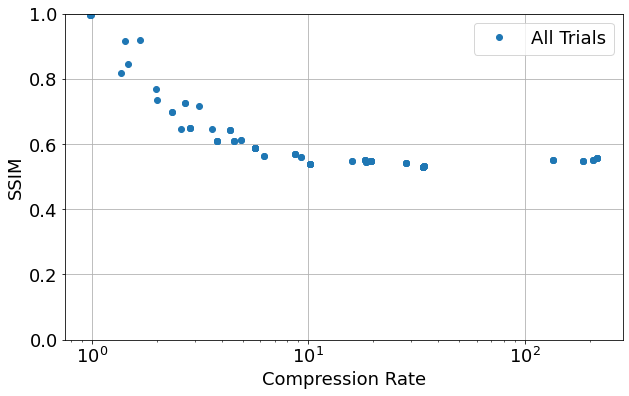

Results for image: image
../images/results/random_sampler_4.2.05_pareto_front.png saved


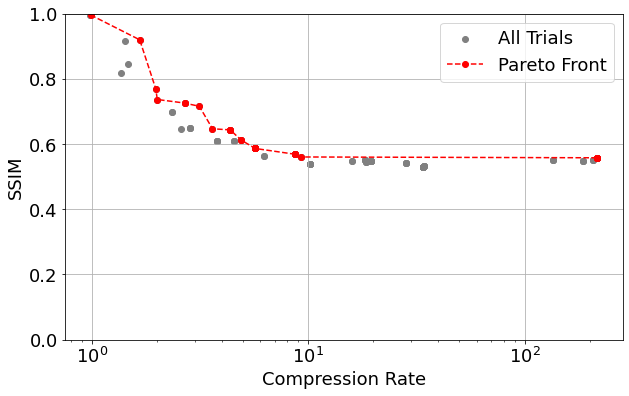

[I 2024-12-11 10:23:18,262] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:4.2.06_time:2024-12-11_10-23-18


image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28477
DEFLATE applied. Bytes to write: 23705
File saved.


[I 2024-12-11 10:23:19,455] Trial 0 finished with values: [9.250724733166425, 0.3831187034713898] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.108865737915039
SSIM Index : 0.3831187034713898

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33430
DEFLATE applied. Bytes to write: 30949
File saved.


[I 2024-12-11 10:23:21,907] Trial 1 finished with values: [7.059289332445104, 0.34418869196562857] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.349292278289795
SSIM Index : 0.34418869196562857

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60983
File saved.


[I 2024-12-11 10:23:25,338] Trial 2 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.3270246982574463
SSIM Index : 0.3981404966423671

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262662
DEFLATE applied. Bytes to write: 249653
File saved.


[I 2024-12-11 10:23:31,568] Trial 3 finished with values: [2.555756287798463, 0.5422196772676535] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.124713182449341
SSIM Index : 0.5422196772676535

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:23:38,703] Trial 4 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.0338757038116455
SSIM Index : 0.3734924603508912

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 10:23:40,182] Trial 5 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3715407848358154
SSIM Index : 0.34002498943942044

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136342
DEFLATE applied. Bytes to write: 126587
File saved.


[I 2024-12-11 10:23:44,474] Trial 6 finished with values: [2.9807028903206634, 0.4550608833320256] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.1556396484375
SSIM Index : 0.4550608833320256

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 10:23:46,657] Trial 7 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.0810701847076416
SSIM Index : 0.33731218825195763

image name:  4.2.06
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:23:51,296] Trial 8 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.524155378341675
SSIM Index : 0.2902076526507203

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12422
File saved.


[I 2024-12-11 10:23:52,409] Trial 9 finished with values: [10.17077145961608, 0.3689385447767437] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.0303637981414795
SSIM Index : 0.3689385447767437

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:23:53,972] Trial 10 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4593143463134766
SSIM Index : 0.3299010582882957

image name:  4.2.06
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33430
DEFLATE applied. Bytes to write: 30949
File saved.


[I 2024-12-11 10:23:56,489] Trial 11 finished with values: [7.059289332445104, 0.34418869196562857] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.4114840030670166
SSIM Index : 0.34418869196562857

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 10:23:57,944] Trial 12 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.353973627090454
SSIM Index : 0.3435840452073631

image name:  4.2.06
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 10:23:59,418] Trial 13 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.370051383972168
SSIM Index : 0.3435840452073631

image name:  4.2.06
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50233
File saved.


[I 2024-12-11 10:24:01,329] Trial 14 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.825061321258545
SSIM Index : 0.45796281343927414

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:24:09,023] Trial 15 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.593652725219727
SSIM Index : 0.3734924603508912

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 10:24:11,005] Trial 16 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.882979393005371
SSIM Index : 0.33731218825195763

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:24:12,640] Trial 17 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.535374641418457
SSIM Index : 0.3299010582882957

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70480
File saved.


[I 2024-12-11 10:24:15,760] Trial 18 finished with values: [4.6527984889153995, 0.40699987788478104] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.0155222415924072
SSIM Index : 0.40699987788478104

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7747
File saved.


[I 2024-12-11 10:24:18,498] Trial 19 finished with values: [17.180483328234935, 0.32554891644666956] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.636085033416748
SSIM Index : 0.32554891644666956

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:24:20,213] Trial 20 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6131384372711182
SSIM Index : 0.3299010582882957

image name:  4.2.06
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78162
File saved.


[I 2024-12-11 10:24:22,329] Trial 21 finished with values: [4.566431690123667, 0.48523637216903764] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.0306396484375
SSIM Index : 0.48523637216903764

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 10:24:23,657] Trial 22 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2291321754455566
SSIM Index : 0.3521355216054813

image name:  4.2.06
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:24:28,195] Trial 23 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.428619384765625
SSIM Index : 0.2902076526507203

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10300
DEFLATE applied. Bytes to write: 8914
File saved.


[I 2024-12-11 10:24:29,866] Trial 24 finished with values: [16.909435780092732, 0.35106982723537367] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.5684008598327637
SSIM Index : 0.35106982723537367

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3960
File saved.


[I 2024-12-11 10:24:30,888] Trial 25 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.9412236213684082
SSIM Index : 0.3534288069321288

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:24:32,538] Trial 26 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.5473840236663818
SSIM Index : 0.3299010582882957

image name:  4.2.06
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 10:24:33,399] Trial 27 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.7785916328430176
SSIM Index : 0.3497066974354959

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60983
File saved.


[I 2024-12-11 10:24:36,833] Trial 28 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.330242872238159
SSIM Index : 0.3981404966423671

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175165
DEFLATE applied. Bytes to write: 151661
File saved.


[I 2024-12-11 10:24:39,445] Trial 29 finished with values: [2.8199090206159685, 0.4949424624409387] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.5272021293640137
SSIM Index : 0.4949424624409387

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12422
File saved.


[I 2024-12-11 10:24:40,470] Trial 30 finished with values: [10.17077145961608, 0.3689385447767437] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.943373441696167
SSIM Index : 0.3689385447767437

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:24:44,321] Trial 31 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.7522361278533936
SSIM Index : 0.2902076526507203

image name:  4.2.06
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:24:52,602] Trial 32 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 8.174005508422852
SSIM Index : 0.3734924603508912

image name:  4.2.06
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:24:54,081] Trial 33 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3776559829711914
SSIM Index : 0.3214371997985182

image name:  4.2.06
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 97855
DEFLATE applied. Bytes to write: 77798
File saved.


[I 2024-12-11 10:24:56,151] Trial 34 finished with values: [4.565466561532146, 0.4851954506714338] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.9862241744995117
SSIM Index : 0.4851954506714338

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:24:57,544] Trial 35 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2938945293426514
SSIM Index : 0.3214371997985182

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 10:24:58,873] Trial 36 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2274935245513916
SSIM Index : 0.35273906218719014

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:25:06,359] Trial 37 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.382217645645142
SSIM Index : 0.3734924603508912

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262662
DEFLATE applied. Bytes to write: 249653
File saved.


[I 2024-12-11 10:25:12,484] Trial 38 finished with values: [2.555756287798463, 0.5422196772676535] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.01847767829895
SSIM Index : 0.5422196772676535

image name:  4.2.06
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 10:25:14,738] Trial 39 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.1510446071624756
SSIM Index : 0.33731218825195763

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60983
File saved.


[I 2024-12-11 10:25:18,344] Trial 40 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.4994313716888428
SSIM Index : 0.3981404966423671

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 904092
DEFLATE applied. Bytes to write: 805580
File saved.


[I 2024-12-11 10:25:38,425] Trial 41 finished with values: [1.251381437051033, 0.9061387146846268] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 19.971223831176758
SSIM Index : 0.9061387146846268

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:25:40,088] Trial 42 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.5598478317260742
SSIM Index : 0.3299010582882957

image name:  4.2.06
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:25:48,460] Trial 43 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 8.269505262374878
SSIM Index : 0.3734924603508912

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78162
File saved.


[I 2024-12-11 10:25:50,622] Trial 44 finished with values: [4.566431690123667, 0.48523637216903764] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.0741426944732666
SSIM Index : 0.48523637216903764

image name:  4.2.06
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 10:25:52,050] Trial 45 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3276758193969727
SSIM Index : 0.34002498943942044

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 10:25:53,505] Trial 46 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3528521060943604
SSIM Index : 0.3435840452073631

image name:  4.2.06
16 4
processed_blocks: 46050
bytes_written (without DEFLATE): 1369801
DEFLATE applied. Bytes to write: 1071331
File saved.


[I 2024-12-11 10:26:22,168] Trial 47 finished with values: [1.1704380155299825, 0.8989495162403552] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 28.580551147460938
SSIM Index : 0.8989495162403552

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10300
DEFLATE applied. Bytes to write: 8914
File saved.


[I 2024-12-11 10:26:23,549] Trial 48 finished with values: [16.909435780092732, 0.35106982723537367] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2849829196929932
SSIM Index : 0.35106982723537367

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:26:27,662] Trial 49 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.016202926635742
SSIM Index : 0.2902076526507203

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28477
DEFLATE applied. Bytes to write: 23705
File saved.


[I 2024-12-11 10:26:28,802] Trial 50 finished with values: [9.250724733166425, 0.3831187034713898] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.0584149360656738
SSIM Index : 0.3831187034713898

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 10:26:30,159] Trial 51 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.259437084197998
SSIM Index : 0.35273906218719014

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:26:31,836] Trial 52 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.5769085884094238
SSIM Index : 0.3299010582882957

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:26:38,838] Trial 53 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.901523113250732
SSIM Index : 0.3734924603508912

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28477
DEFLATE applied. Bytes to write: 23705
File saved.


[I 2024-12-11 10:26:40,023] Trial 54 finished with values: [9.250724733166425, 0.3831187034713898] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.1016783714294434
SSIM Index : 0.3831187034713898

image name:  4.2.06
32 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3386740
DEFLATE applied. Bytes to write: 2933387
File saved.


[I 2024-12-11 10:29:22,745] Trial 55 finished with values: [0.998291831899195, 0.9969422302422855] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 162.63374876976013
SSIM Index : 0.9969422302422855

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 10:29:23,514] Trial 56 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.692302942276001
SSIM Index : 0.3497066974354959

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268027
DEFLATE applied. Bytes to write: 192185
File saved.


[I 2024-12-11 10:29:28,096] Trial 57 finished with values: [2.8591573674350412, 0.5798553561436771] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.49903416633606
SSIM Index : 0.5798553561436771

image name:  4.2.06
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 10:29:29,347] Trial 58 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.1576449871063232
SSIM Index : 0.35273906218719014

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:29:33,672] Trial 59 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.225362062454224
SSIM Index : 0.2902076526507203

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136342
DEFLATE applied. Bytes to write: 126587
File saved.


[I 2024-12-11 10:29:37,671] Trial 60 finished with values: [2.9807028903206634, 0.4550608833320256] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.8945388793945312
SSIM Index : 0.4550608833320256

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2446
File saved.


[I 2024-12-11 10:29:39,399] Trial 61 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6213514804840088
SSIM Index : 0.3299010582882957

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70480
File saved.


[I 2024-12-11 10:29:42,302] Trial 62 finished with values: [4.6527984889153995, 0.40699987788478104] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.7938852310180664
SSIM Index : 0.40699987788478104

image name:  4.2.06
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2447
File saved.


[I 2024-12-11 10:29:44,031] Trial 63 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6261379718780518
SSIM Index : 0.3299010582882957

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:29:45,561] Trial 64 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4258089065551758
SSIM Index : 0.3214371997985182

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7747
File saved.


[I 2024-12-11 10:29:48,241] Trial 65 finished with values: [17.180483328234935, 0.32554891644666956] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.5739877223968506
SSIM Index : 0.32554891644666956

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3445290
DEFLATE applied. Bytes to write: 3011124
File saved.


[I 2024-12-11 10:30:21,566] Trial 66 finished with values: [0.9985527448065941, 0.9974029272266888] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 33.239134788513184
SSIM Index : 0.9974029272266888

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 10:30:35,283] Trial 67 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 13.610038757324219
SSIM Index : 0.6366678464767697

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 10:30:36,837] Trial 68 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.4549100399017334
SSIM Index : 0.3521355216054813

image name:  4.2.06
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7747
File saved.


[I 2024-12-11 10:30:39,721] Trial 69 finished with values: [17.180483328234935, 0.32554891644666956] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.7812294960021973
SSIM Index : 0.32554891644666956

image name:  4.2.06
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50232
File saved.


[I 2024-12-11 10:30:41,465] Trial 70 finished with values: [5.371982247388759, 0.45796281343927414] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.6648521423339844
SSIM Index : 0.45796281343927414

image name:  4.2.06
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:30:42,872] Trial 71 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3080527782440186
SSIM Index : 0.3214371997985182

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4935
File saved.


[I 2024-12-11 10:30:44,340] Trial 72 finished with values: [20.81961743772242, 0.34002498943942044] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.3656110763549805
SSIM Index : 0.34002498943942044

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3118
File saved.


[I 2024-12-11 10:30:46,170] Trial 73 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7274303436279297
SSIM Index : 0.3435840452073631

image name:  4.2.06
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3961
File saved.


[I 2024-12-11 10:30:47,170] Trial 74 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.909909725189209
SSIM Index : 0.3534288069321288

image name:  4.2.06
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 10:30:48,487] Trial 75 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2184410095214844
SSIM Index : 0.35273906218719014

image name:  4.2.06
8 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3726545
DEFLATE applied. Bytes to write: 3318340
File saved.


[I 2024-12-11 10:31:35,165] Trial 76 finished with values: [0.9980523380828324, 0.9969502498183324] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.59499406814575
SSIM Index : 0.9969502498183324

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70480
File saved.


[I 2024-12-11 10:31:37,762] Trial 77 finished with values: [4.6527984889153995, 0.40699987788478104] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.4982388019561768
SSIM Index : 0.40699987788478104

image name:  4.2.06
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28477
DEFLATE applied. Bytes to write: 23705
File saved.


[I 2024-12-11 10:31:38,880] Trial 78 finished with values: [9.250724733166425, 0.3831187034713898] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.039017915725708
SSIM Index : 0.3831187034713898

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194230
File saved.


[I 2024-12-11 10:31:43,353] Trial 79 finished with values: [2.8588371832591855, 0.5799172835228504] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.394215822219849
SSIM Index : 0.5799172835228504

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 589
File saved.


[I 2024-12-11 10:31:44,602] Trial 80 finished with values: [268.46558317399615, 0.3521355216054813] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.1567835807800293
SSIM Index : 0.3521355216054813

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7747
File saved.


[I 2024-12-11 10:31:47,066] Trial 81 finished with values: [17.180483328234935, 0.32554891644666956] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 2.369866371154785
SSIM Index : 0.32554891644666956

image name:  4.2.06
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 234947
DEFLATE applied. Bytes to write: 160963
File saved.


[I 2024-12-11 10:31:51,799] Trial 82 finished with values: [3.0075989225488255, 0.5749995110599501] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.6526854038238525
SSIM Index : 0.5749995110599501

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:32:00,223] Trial 83 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 8.327820062637329
SSIM Index : 0.3734924603508912

image name:  4.2.06
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 776717
DEFLATE applied. Bytes to write: 683832
File saved.


[I 2024-12-11 10:32:07,911] Trial 84 finished with values: [1.5753732055000478, 0.7330474864792341] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.607588529586792
SSIM Index : 0.7330474864792341

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:32:09,265] Trial 85 finished with values: [37.802382715218414, 0.3214371997985182] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.258439064025879
SSIM Index : 0.3214371997985182

image name:  4.2.06
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16112
DEFLATE applied. Bytes to write: 15349
File saved.


[I 2024-12-11 10:32:13,487] Trial 86 finished with values: [9.740374609781478, 0.2902076526507203] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 4.123935699462891
SSIM Index : 0.2902076526507203

image name:  4.2.06
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136342
DEFLATE applied. Bytes to write: 126587
File saved.


[I 2024-12-11 10:32:17,151] Trial 87 finished with values: [2.9807028903206634, 0.4550608833320256] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.5616297721862793
SSIM Index : 0.4550608833320256

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 10:32:23,770] Trial 88 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.515766143798828
SSIM Index : 0.3734924603508912

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64210
DEFLATE applied. Bytes to write: 60984
File saved.


[I 2024-12-11 10:32:27,253] Trial 89 finished with values: [4.299823147063552, 0.3981404966423671] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.378295660018921
SSIM Index : 0.3981404966423671

image name:  4.2.06
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 358
File saved.


[I 2024-12-11 10:32:28,602] Trial 90 finished with values: [282.0843797086891, 0.35273906218719014] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2486813068389893
SSIM Index : 0.35273906218719014

image name:  4.2.06
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311350
DEFLATE applied. Bytes to write: 282893
File saved.


[I 2024-12-11 10:32:32,061] Trial 91 finished with values: [2.1401135540906147, 0.5905834350518898] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 3.3765902519226074
SSIM Index : 0.5905834350518898

image name:  4.2.06
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1158
File saved.


[I 2024-12-11 10:32:32,805] Trial 92 finished with values: [242.29076790336498, 0.3497066974354959] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.6672918796539307
SSIM Index : 0.3497066974354959

image name:  4.2.06
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 900975
DEFLATE applied. Bytes to write: 611719
File saved.


[I 2024-12-11 10:32:50,618] Trial 93 finished with values: [1.3692782173027929, 0.8010358227437148] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 17.731329917907715
SSIM Index : 0.8010358227437148

image name:  4.2.06
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4178
File saved.


[I 2024-12-11 10:32:52,445] Trial 94 finished with values: [31.2850935828877, 0.33731218825195763] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.7307398319244385
SSIM Index : 0.33731218825195763

image name:  4.2.06
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3116
File saved.


[I 2024-12-11 10:32:53,811] Trial 95 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.268404245376587
SSIM Index : 0.3435840452073631

image name:  4.2.06
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 3960
File saved.


[I 2024-12-11 10:32:54,703] Trial 96 finished with values: [173.98698884758363, 0.3534288069321288] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 0.8170046806335449
SSIM Index : 0.3534288069321288

image name:  4.2.06
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3118
File saved.


[I 2024-12-11 10:32:56,035] Trial 97 finished with values: [20.688473864515416, 0.3435840452073631] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.2362644672393799
SSIM Index : 0.3435840452073631

image name:  4.2.06
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2752
DEFLATE applied. Bytes to write: 2447
File saved.


[I 2024-12-11 10:32:57,663] Trial 98 finished with values: [38.49945160405813, 0.3299010582882957] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 1.527970790863037
SSIM Index : 0.3299010582882957

image name:  4.2.06
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 120000
File saved.


[I 2024-12-11 10:33:04,077] Trial 99 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.308613538742065
SSIM Index : 0.4399838640468852

../images/results/random_sampler_4.2.06_compression_vs_ssim.png saved


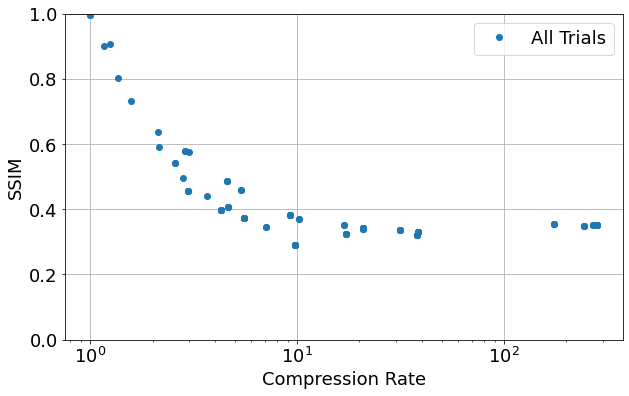

Results for image: image
../images/results/random_sampler_4.2.06_pareto_front.png saved


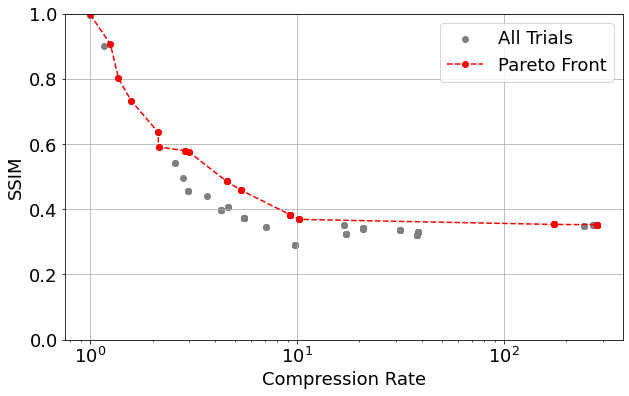

[I 2024-12-11 10:33:05,027] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:4.2.03_time:2024-12-11_10-33-05


image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 10:33:06,087] Trial 0 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9825718402862549
SSIM Index : 0.20960156926467607

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31096
File saved.


[I 2024-12-11 10:33:08,510] Trial 1 finished with values: [6.834645669291339, 0.18345250406433108] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.3182287216186523
SSIM Index : 0.18345250406433108

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64235
DEFLATE applied. Bytes to write: 60958
File saved.


[I 2024-12-11 10:33:11,875] Trial 2 finished with values: [4.451062871934835, 0.24001120871486262] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.263046979904175
SSIM Index : 0.24001120871486262

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
DEFLATE applied. Bytes to write: 249093
File saved.


[I 2024-12-11 10:33:18,051] Trial 3 finished with values: [2.8739502668332007, 0.39761421370173733] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.071756362915039
SSIM Index : 0.39761421370173733

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:33:24,853] Trial 4 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.702232837677002
SSIM Index : 0.21044176185774047

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4924
File saved.


[I 2024-12-11 10:33:26,292] Trial 5 finished with values: [25.16492344402466, 0.18476026841425572] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3394224643707275
SSIM Index : 0.18476026841425572

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126279
File saved.


[I 2024-12-11 10:33:30,211] Trial 6 finished with values: [3.4803260474990925, 0.3085174369885891] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.813832998275757
SSIM Index : 0.3085174369885891

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4153
File saved.


[I 2024-12-11 10:33:32,209] Trial 7 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.8953516483306885
SSIM Index : 0.1733018660479305

image name:  4.2.03
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15274
File saved.


[I 2024-12-11 10:33:36,728] Trial 8 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.419280052185059
SSIM Index : 0.14841473192043858

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 10:33:37,758] Trial 9 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9492602348327637
SSIM Index : 0.20164704952380272

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:33:39,337] Trial 10 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.482839822769165
SSIM Index : 0.1804354858169054

image name:  4.2.03
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33570
DEFLATE applied. Bytes to write: 31096
File saved.


[I 2024-12-11 10:33:41,945] Trial 11 finished with values: [6.834645669291339, 0.18345250406433108] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.504802703857422
SSIM Index : 0.18345250406433108

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:33:43,449] Trial 12 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.403003215789795
SSIM Index : 0.1839878013121695

image name:  4.2.03
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:33:44,944] Trial 13 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3924546241760254
SSIM Index : 0.1839878013121695

image name:  4.2.03
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50035
File saved.


[I 2024-12-11 10:33:46,822] Trial 14 finished with values: [5.748918850165352, 0.2551073555143876] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.7986745834350586
SSIM Index : 0.2551073555143876

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:33:54,468] Trial 15 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.5525548458099365
SSIM Index : 0.21044176185774047

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4153
File saved.


[I 2024-12-11 10:33:56,479] Trial 16 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.9038918018341064
SSIM Index : 0.1733018660479305

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:33:58,077] Trial 17 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5010507106781006
SSIM Index : 0.1804354858169054

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70301
File saved.


[I 2024-12-11 10:34:00,929] Trial 18 finished with values: [5.118686296715742, 0.25020270718424026] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.7517504692077637
SSIM Index : 0.25020270718424026

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:34:03,585] Trial 19 finished with values: [17.40871574777154, 0.1620309338292634] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.5561578273773193
SSIM Index : 0.1620309338292634

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:34:05,270] Trial 20 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5875205993652344
SSIM Index : 0.1804354858169054

image name:  4.2.03
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 77862
File saved.


[I 2024-12-11 10:34:07,272] Trial 21 finished with values: [4.644709509303777, 0.2872839862199777] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.922494649887085
SSIM Index : 0.2872839862199777

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 578
File saved.


[I 2024-12-11 10:34:08,584] Trial 22 finished with values: [302.9066539013882, 0.17810926875517452] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2190170288085938
SSIM Index : 0.17810926875517452

image name:  4.2.03
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15274
File saved.


[I 2024-12-11 10:34:12,970] Trial 23 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.28589940071106
SSIM Index : 0.14841473192043858

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10235
DEFLATE applied. Bytes to write: 8849
File saved.


[I 2024-12-11 10:34:14,556] Trial 24 finished with values: [18.65263530244075, 0.1846502186504239] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.4806396961212158
SSIM Index : 0.1846502186504239

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 10:34:15,519] Trial 25 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.886894702911377
SSIM Index : 0.18703305587405059

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:34:17,166] Trial 26 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.551276683807373
SSIM Index : 0.1804354858169054

image name:  4.2.03
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 10:34:17,978] Trial 27 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7367305755615234
SSIM Index : 0.17760382146513995

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64235
DEFLATE applied. Bytes to write: 60958
File saved.


[I 2024-12-11 10:34:21,256] Trial 28 finished with values: [4.451062871934835, 0.24001120871486262] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.177546977996826
SSIM Index : 0.24001120871486262

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175175
DEFLATE applied. Bytes to write: 151009
File saved.


[I 2024-12-11 10:34:23,771] Trial 29 finished with values: [2.9700354842949137, 0.33293869400944653] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.434718608856201
SSIM Index : 0.33293869400944653

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12426
File saved.


[I 2024-12-11 10:34:24,731] Trial 30 finished with values: [12.978074943085096, 0.20164704952380272] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.8839442729949951
SSIM Index : 0.20164704952380272

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15274
File saved.


[I 2024-12-11 10:34:28,440] Trial 31 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.6117122173309326
SSIM Index : 0.14841473192043858

image name:  4.2.03
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:34:36,569] Trial 32 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 8.019613981246948
SSIM Index : 0.21044176185774047

image name:  4.2.03
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 10:34:38,038] Trial 33 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3710906505584717
SSIM Index : 0.1802367342115423

image name:  4.2.03
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 77862
File saved.


[I 2024-12-11 10:34:40,042] Trial 34 finished with values: [4.644709509303777, 0.2872839862199777] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.9237949848175049
SSIM Index : 0.2872839862199777

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 10:34:41,425] Trial 35 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2884700298309326
SSIM Index : 0.1802367342115423

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 10:34:42,743] Trial 36 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2239348888397217
SSIM Index : 0.1769590609355218

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:34:50,274] Trial 37 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.431742429733276
SSIM Index : 0.21044176185774047

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262642
DEFLATE applied. Bytes to write: 249093
File saved.


[I 2024-12-11 10:34:56,336] Trial 38 finished with values: [2.8739502668332007, 0.39761421370173733] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 5.953433275222778
SSIM Index : 0.39761421370173733

image name:  4.2.03
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4152
File saved.


[I 2024-12-11 10:34:58,453] Trial 39 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.017711877822876
SSIM Index : 0.1733018660479305

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64235
DEFLATE applied. Bytes to write: 60958
File saved.


[I 2024-12-11 10:35:01,908] Trial 40 finished with values: [4.451062871934835, 0.24001120871486262] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.3559679985046387
SSIM Index : 0.24001120871486262

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 1395162
DEFLATE applied. Bytes to write: 1265677
File saved.


[I 2024-12-11 10:35:28,040] Trial 41 finished with values: [1.06225406588684, 0.9531800243903915] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 26.027512311935425
SSIM Index : 0.9531800243903915

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:35:29,676] Trial 42 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5346035957336426
SSIM Index : 0.1804354858169054

image name:  4.2.03
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:35:37,502] Trial 43 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.725854396820068
SSIM Index : 0.21044176185774047

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
DEFLATE applied. Bytes to write: 77862
File saved.


[I 2024-12-11 10:35:39,475] Trial 44 finished with values: [4.644709509303777, 0.2872839862199777] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.8939194679260254
SSIM Index : 0.2872839862199777

image name:  4.2.03
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4925
File saved.


[I 2024-12-11 10:35:40,872] Trial 45 finished with values: [25.16492344402466, 0.18476026841425572] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2998552322387695
SSIM Index : 0.18476026841425572

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:35:42,286] Trial 46 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3148157596588135
SSIM Index : 0.1839878013121695

image name:  4.2.03
16 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1944495
DEFLATE applied. Bytes to write: 1584140
File saved.


[I 2024-12-11 10:36:15,208] Trial 47 finished with values: [1.0690485925034887, 0.9505926958029284] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 32.841639041900635
SSIM Index : 0.9505926958029284

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10235
DEFLATE applied. Bytes to write: 8849
File saved.


[I 2024-12-11 10:36:16,641] Trial 48 finished with values: [18.65263530244075, 0.1846502186504239] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.337824821472168
SSIM Index : 0.1846502186504239

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15273
File saved.


[I 2024-12-11 10:36:20,688] Trial 49 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.9515738487243652
SSIM Index : 0.14841473192043858

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 10:36:21,731] Trial 50 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9676070213317871
SSIM Index : 0.20960156926467607

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 10:36:22,962] Trial 51 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.140315055847168
SSIM Index : 0.1769590609355218

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2464
File saved.


[I 2024-12-11 10:36:24,551] Trial 52 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.494645595550537
SSIM Index : 0.1804354858169054

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:36:31,060] Trial 53 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.409679889678955
SSIM Index : 0.21044176185774047

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 10:36:32,099] Trial 54 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9644620418548584
SSIM Index : 0.20960156926467607

image name:  4.2.03
32 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3626585
DEFLATE applied. Bytes to write: 3150945
File saved.


[I 2024-12-11 10:39:27,670] Trial 55 finished with values: [0.999410877445135, 0.9983309083384423] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 175.48625445365906
SSIM Index : 0.9983309083384423

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1151
File saved.


[I 2024-12-11 10:39:28,440] Trial 56 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.6934492588043213
SSIM Index : 0.17760382146513995

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 10:39:33,195] Trial 57 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.672194480895996
SSIM Index : 0.3992301054044307

image name:  4.2.03
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 10:39:34,446] Trial 58 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.1584861278533936
SSIM Index : 0.1769590609355218

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15273
File saved.


[I 2024-12-11 10:39:38,858] Trial 59 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.31456184387207
SSIM Index : 0.14841473192043858

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126279
File saved.


[I 2024-12-11 10:39:42,644] Trial 60 finished with values: [3.4803260474990925, 0.3085174369885891] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.682845115661621
SSIM Index : 0.3085174369885891

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:39:44,373] Trial 61 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6298613548278809
SSIM Index : 0.1804354858169054

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70301
File saved.


[I 2024-12-11 10:39:47,470] Trial 62 finished with values: [5.118686296715742, 0.25020270718424026] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.981029748916626
SSIM Index : 0.25020270718424026

image name:  4.2.03
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:39:49,136] Trial 63 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.5652217864990234
SSIM Index : 0.1804354858169054

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1295
File saved.


[I 2024-12-11 10:39:50,644] Trial 64 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.409144639968872
SSIM Index : 0.1802367342115423

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:39:53,720] Trial 65 finished with values: [17.40871574777154, 0.1620309338292634] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.9731719493865967
SSIM Index : 0.1620309338292634

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3673875
DEFLATE applied. Bytes to write: 3224578
File saved.


[I 2024-12-11 10:40:27,691] Trial 66 finished with values: [0.9995987526578687, 0.9989360840369539] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 33.892407178878784
SSIM Index : 0.9989360840369539

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 10:40:41,253] Trial 67 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 13.46211314201355
SSIM Index : 0.5299292936152326

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 578
File saved.


[I 2024-12-11 10:40:42,581] Trial 68 finished with values: [302.9066539013882, 0.17810926875517452] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2351727485656738
SSIM Index : 0.17810926875517452

image name:  4.2.03
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:40:45,487] Trial 69 finished with values: [17.40871574777154, 0.1620309338292634] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.8079705238342285
SSIM Index : 0.1620309338292634

image name:  4.2.03
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50035
File saved.


[I 2024-12-11 10:40:47,236] Trial 70 finished with values: [5.748918850165352, 0.2551073555143876] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.6701722145080566
SSIM Index : 0.2551073555143876

image name:  4.2.03
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 10:40:48,649] Trial 71 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3173255920410156
SSIM Index : 0.1802367342115423

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4924
File saved.


[I 2024-12-11 10:40:50,105] Trial 72 finished with values: [25.16492344402466, 0.18476026841425572] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3561193943023682
SSIM Index : 0.18476026841425572

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:40:51,542] Trial 73 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.3372607231140137
SSIM Index : 0.1839878013121695

image name:  4.2.03
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 10:40:52,509] Trial 74 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.8911943435668945
SSIM Index : 0.18703305587405059

image name:  4.2.03
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 10:40:53,774] Trial 75 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.1729815006256104
SSIM Index : 0.1769590609355218

image name:  4.2.03
8 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3947320
DEFLATE applied. Bytes to write: 3526564
File saved.


[I 2024-12-11 10:41:40,692] Trial 76 finished with values: [0.9995355934452332, 0.9986804161966766] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 46.839741706848145
SSIM Index : 0.9986804161966766

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77472
DEFLATE applied. Bytes to write: 70301
File saved.


[I 2024-12-11 10:41:43,235] Trial 77 finished with values: [5.118686296715742, 0.25020270718424026] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.4491705894470215
SSIM Index : 0.25020270718424026

image name:  4.2.03
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28422
DEFLATE applied. Bytes to write: 23599
File saved.


[I 2024-12-11 10:41:44,280] Trial 78 finished with values: [10.738599915146372, 0.20960156926467607] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.9680070877075195
SSIM Index : 0.20960156926467607

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 193135
File saved.


[I 2024-12-11 10:41:48,886] Trial 79 finished with values: [2.8052258954022937, 0.3992301054044307] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.524874687194824
SSIM Index : 0.3992301054044307

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 578
File saved.


[I 2024-12-11 10:41:50,168] Trial 80 finished with values: [302.9066539013882, 0.17810926875517452] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.1872889995574951
SSIM Index : 0.17810926875517452

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8302
DEFLATE applied. Bytes to write: 7690
File saved.


[I 2024-12-11 10:41:52,709] Trial 81 finished with values: [17.40871574777154, 0.1620309338292634] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 2.443573474884033
SSIM Index : 0.1620309338292634

image name:  4.2.03
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 267352
DEFLATE applied. Bytes to write: 190724
File saved.


[I 2024-12-11 10:41:57,319] Trial 82 finished with values: [2.805636350737798, 0.3987481211985628] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.530581951141357
SSIM Index : 0.3987481211985628

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:42:04,764] Trial 83 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.349727392196655
SSIM Index : 0.21044176185774047

image name:  4.2.03
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 778192
DEFLATE applied. Bytes to write: 682533
File saved.


[I 2024-12-11 10:42:12,752] Trial 84 finished with values: [1.6038343678793117, 0.6257441888030076] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.906319856643677
SSIM Index : 0.6257441888030076

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1294
File saved.


[I 2024-12-11 10:42:14,099] Trial 85 finished with values: [49.05969917816716, 0.1802367342115423] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2536647319793701
SSIM Index : 0.1802367342115423

image name:  4.2.03
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16107
DEFLATE applied. Bytes to write: 15274
File saved.


[I 2024-12-11 10:42:18,607] Trial 86 finished with values: [10.251304150601044, 0.14841473192043858] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 4.41112494468689
SSIM Index : 0.14841473192043858

image name:  4.2.03
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126279
File saved.


[I 2024-12-11 10:42:22,401] Trial 87 finished with values: [3.4803260474990925, 0.3085174369885891] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.6949093341827393
SSIM Index : 0.3085174369885891

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 10:42:29,514] Trial 88 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.018097639083862
SSIM Index : 0.21044176185774047

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64235
DEFLATE applied. Bytes to write: 60958
File saved.


[I 2024-12-11 10:42:33,002] Trial 89 finished with values: [4.451062871934835, 0.24001120871486262] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.3889129161834717
SSIM Index : 0.24001120871486262

image name:  4.2.03
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 353
File saved.


[I 2024-12-11 10:42:34,342] Trial 90 finished with values: [318.2957746478873, 0.1769590609355218] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2441129684448242
SSIM Index : 0.1769590609355218

image name:  4.2.03
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311550
DEFLATE applied. Bytes to write: 282085
File saved.


[I 2024-12-11 10:42:38,010] Trial 91 finished with values: [2.3839775154750646, 0.43730243939860713] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 3.585022449493408
SSIM Index : 0.43730243939860713

image name:  4.2.03
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1152
File saved.


[I 2024-12-11 10:42:38,793] Trial 92 finished with values: [271.575965665236, 0.17760382146513995] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.7055320739746094
SSIM Index : 0.17760382146513995

image name:  4.2.03
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1207080
DEFLATE applied. Bytes to write: 911990
File saved.


[I 2024-12-11 10:42:59,108] Trial 93 finished with values: [1.131451193279655, 0.882005416115808] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 20.234600067138672
SSIM Index : 0.882005416115808

image name:  4.2.03
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4542
DEFLATE applied. Bytes to write: 4153
File saved.


[I 2024-12-11 10:43:00,955] Trial 94 finished with values: [32.56842863760358, 0.1733018660479305] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.753988265991211
SSIM Index : 0.1733018660479305

image name:  4.2.03
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:43:02,378] Trial 95 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2828125953674316
SSIM Index : 0.1839878013121695

image name:  4.2.03
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4015
File saved.


[I 2024-12-11 10:43:03,331] Trial 96 finished with values: [196.45203352995964, 0.18703305587405059] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 0.8753383159637451
SSIM Index : 0.18703305587405059

image name:  4.2.03
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3128
File saved.


[I 2024-12-11 10:43:04,662] Trial 97 finished with values: [29.702027788208788, 0.1839878013121695] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.2365097999572754
SSIM Index : 0.1839878013121695

image name:  4.2.03
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2767
DEFLATE applied. Bytes to write: 2465
File saved.


[I 2024-12-11 10:43:06,327] Trial 98 finished with values: [49.57474146035725, 0.1804354858169054] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 1.570016622543335
SSIM Index : 0.1804354858169054

image name:  4.2.03
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 10:43:12,718] Trial 99 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.279905080795288
SSIM Index : 0.2942763826515455

../images/results/random_sampler_4.2.03_compression_vs_ssim.png saved


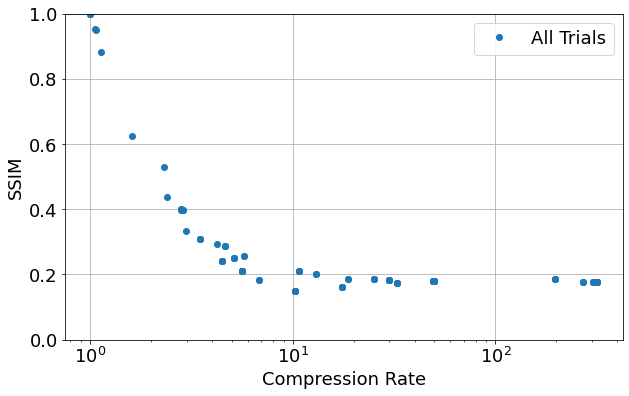

Results for image: image
../images/results/random_sampler_4.2.03_pareto_front.png saved


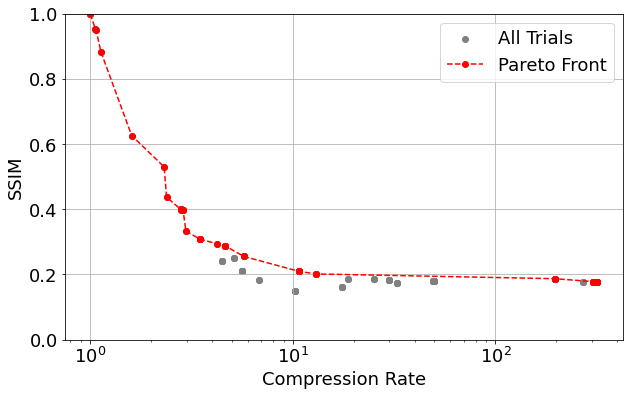

[I 2024-12-11 10:43:13,697] A new study created in memory with name: multiobj_random_sampler_trials:100_seed:43_image:4.2.07_time:2024-12-11_10-43-13


image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 10:43:14,750] Trial 0 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9762585163116455
SSIM Index : 0.44617982677432755

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33560
DEFLATE applied. Bytes to write: 31118
File saved.


[I 2024-12-11 10:43:17,073] Trial 1 finished with values: [5.698335537918871, 0.3555334330036007] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.2260537147521973
SSIM Index : 0.3555334330036007

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 10:43:20,367] Trial 2 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.1912193298339844
SSIM Index : 0.4489657077257934

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262707
DEFLATE applied. Bytes to write: 249855
File saved.


[I 2024-12-11 10:43:26,389] Trial 3 finished with values: [2.2920780884902388, 0.5781928818547329] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 5.920765161514282
SSIM Index : 0.5781928818547329

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:43:33,244] Trial 4 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.75138258934021
SSIM Index : 0.41839355308777626

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4941
File saved.


[I 2024-12-11 10:43:34,680] Trial 5 finished with values: [20.245672436750997, 0.39853996668563885] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3382141590118408
SSIM Index : 0.39853996668563885

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126470
File saved.


[I 2024-12-11 10:43:38,603] Trial 6 finished with values: [2.619035073942538, 0.5172604552565858] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.821507453918457
SSIM Index : 0.5172604552565858

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4198
File saved.


[I 2024-12-11 10:43:40,596] Trial 7 finished with values: [29.691172247429787, 0.38094831933221335] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8935441970825195
SSIM Index : 0.38094831933221335

image name:  4.2.07
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:43:45,039] Trial 8 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.3435962200164795
SSIM Index : 0.328797173589851

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12452
File saved.


[I 2024-12-11 10:43:46,072] Trial 9 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9524857997894287
SSIM Index : 0.44036741247906797

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:43:48,018] Trial 10 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.41036119064465354, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.963455285888468, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8489391803741455
SSIM Index : 0.3861699207171572

image name:  4.2.07
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33560
DEFLATE applied. Bytes to write: 31118
File saved.


[I 2024-12-11 10:43:50,919] Trial 11 finished with values: [5.698335537918871, 0.3555334330036007] and parameters: {'min_sparcity': 0.5650565377492976, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24841700153855414, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.7986984252929688
SSIM Index : 0.3555334330036007

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 10:43:52,401] Trial 12 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.707668451801736, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.017238167862260578, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3815934658050537
SSIM Index : 0.40029127412705773

image name:  4.2.07
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3138
File saved.


[I 2024-12-11 10:43:53,878] Trial 13 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.7977814761678838, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.06276256076318872, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3759641647338867
SSIM Index : 0.40029127412705773

image name:  4.2.07
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50204
File saved.


[I 2024-12-11 10:43:55,661] Trial 14 finished with values: [5.055824506841143, 0.5093406680011131] and parameters: {'min_sparcity': 0.4099171003106648, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.3777247486710733, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.705040693283081
SSIM Index : 0.5093406680011131

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:44:03,091] Trial 15 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.7502929056749345, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004134820601364016, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.329247236251831
SSIM Index : 0.41839355308777626

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4198
File saved.


[I 2024-12-11 10:44:05,150] Trial 16 finished with values: [29.691172247429787, 0.38094831933221335] and parameters: {'min_sparcity': 0.508306236563854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.015541012387669917, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.960465431213379
SSIM Index : 0.38094831933221335

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:44:06,840] Trial 17 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.9657544958604907, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0013964061404611006, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5905170440673828
SSIM Index : 0.3861699207171572

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77452
DEFLATE applied. Bytes to write: 70496
File saved.


[I 2024-12-11 10:44:09,740] Trial 18 finished with values: [4.073254329703579, 0.44628841273018893] and parameters: {'min_sparcity': 0.2985084627768719, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.0010727529270470305, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.7940521240234375
SSIM Index : 0.44628841273018893

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7744
File saved.


[I 2024-12-11 10:44:12,371] Trial 19 finished with values: [15.56149909692956, 0.36586014394225935] and parameters: {'min_sparcity': 0.8714796622642436, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 532.0064518383172, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.532050132751465
SSIM Index : 0.36586014394225935

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:44:14,054] Trial 20 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.19286582797359791, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.03390608777797147, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.583620548248291
SSIM Index : 0.3861699207171572

image name:  4.2.07
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78207
File saved.


[I 2024-12-11 10:44:16,073] Trial 21 finished with values: [4.161558834657586, 0.5287064864083536] and parameters: {'min_sparcity': 0.6207676060626862, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.001854498193515808, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.940192699432373
SSIM Index : 0.5287064864083536

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 10:44:17,393] Trial 22 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.7545192895023648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 45.853469303361436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2261829376220703
SSIM Index : 0.38983996492857154

image name:  4.2.07
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:44:21,784] Trial 23 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.905921468826918, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 342.71799044521475, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.2918479442596436
SSIM Index : 0.328797173589851

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8902
File saved.


[I 2024-12-11 10:44:23,388] Trial 24 finished with values: [15.596240873710252, 0.39831068973019423] and parameters: {'min_sparcity': 0.40025601798012905, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.617826889586683, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5029678344726562
SSIM Index : 0.39831068973019423

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 10:44:24,354] Trial 25 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.13697773816031253, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 29.494616466740453, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.8882369995117188
SSIM Index : 0.4050221601820932

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:44:25,958] Trial 26 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.01723639878668551, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 16.064016317026674, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5091822147369385
SSIM Index : 0.3861699207171572

image name:  4.2.07
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 10:44:26,763] Trial 27 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.12954464881062958, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 270.83569744348983, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.7302193641662598
SSIM Index : 0.395109178896216

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 10:44:30,084] Trial 28 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.588299422406451, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.370205473245772, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.208730459213257
SSIM Index : 0.4489657077257934

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175145
DEFLATE applied. Bytes to write: 151724
File saved.


[I 2024-12-11 10:44:32,547] Trial 29 finished with values: [2.557502028377496, 0.5190964601024602] and parameters: {'min_sparcity': 0.6003637103750971, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.834520591850747, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.382690668106079
SSIM Index : 0.5190964601024602

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
DEFLATE applied. Bytes to write: 12453
File saved.


[I 2024-12-11 10:44:33,516] Trial 30 finished with values: [9.636375498639227, 0.44036741247906797] and parameters: {'min_sparcity': 0.1897194091620571, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.09797390289723837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.8919999599456787
SSIM Index : 0.44036741247906797

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:44:37,459] Trial 31 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.10371032527229188, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.13510605790097835, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.8420326709747314
SSIM Index : 0.328797173589851

image name:  4.2.07
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:44:45,622] Trial 32 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.03570264653962555, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 11.056037575555228, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.05965805053711
SSIM Index : 0.41839355308777626

image name:  4.2.07
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:44:47,104] Trial 33 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.4847099712262612, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 0.009917930057518952, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3822863101959229
SSIM Index : 0.3787681504959404

image name:  4.2.07
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78207
File saved.


[I 2024-12-11 10:44:49,117] Trial 34 finished with values: [4.161558834657586, 0.5287064864083536] and parameters: {'min_sparcity': 0.935214384031572, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 210.73833767142509, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.9317312240600586
SSIM Index : 0.5287064864083536

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:44:50,486] Trial 35 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.963031358338554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8243148891888238, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2727594375610352
SSIM Index : 0.3787681504959404

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 10:44:51,792] Trial 36 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.9737046081010251, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.46911422336825426, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2107949256896973
SSIM Index : 0.3922454544426941

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:44:59,283] Trial 37 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.4525905122624392, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.565708417561526, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.395414590835571
SSIM Index : 0.41839355308777626

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 262707
DEFLATE applied. Bytes to write: 249855
File saved.


[I 2024-12-11 10:45:05,511] Trial 38 finished with values: [2.2920780884902388, 0.5781928818547329] and parameters: {'min_sparcity': 0.6653515284769774, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.01859884771270904, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.12519097328186
SSIM Index : 0.5781928818547329

image name:  4.2.07
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4198
File saved.


[I 2024-12-11 10:45:07,618] Trial 39 finished with values: [29.691172247429787, 0.38094831933221335] and parameters: {'min_sparcity': 0.35680292240557393, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.010709422577599841, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.0099668502807617
SSIM Index : 0.38094831933221335

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 10:45:11,118] Trial 40 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.16843426463166777, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 1.9062643223871256, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.399860382080078
SSIM Index : 0.4489657077257934

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 651132
DEFLATE applied. Bytes to write: 567623
File saved.


[I 2024-12-11 10:45:27,626] Trial 41 finished with values: [1.3929762822205576, 0.8612151855164377] and parameters: {'min_sparcity': 0.9693763915183758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 603.8578865480883, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 16.402920961380005
SSIM Index : 0.8612151855164377

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:45:29,278] Trial 42 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.9198863161854353, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.9165506192452135, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.5534911155700684
SSIM Index : 0.3861699207171572

image name:  4.2.07
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:45:37,252] Trial 43 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.5633632780395972, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 4.907759189635353, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.874775409698486
SSIM Index : 0.41839355308777626

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
DEFLATE applied. Bytes to write: 78207
File saved.


[I 2024-12-11 10:45:39,229] Trial 44 finished with values: [4.161558834657586, 0.5287064864083536] and parameters: {'min_sparcity': 0.6956506335105708, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.0018923799859672569, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.900087594985962
SSIM Index : 0.5287064864083536

image name:  4.2.07
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4942
File saved.


[I 2024-12-11 10:45:40,649] Trial 45 finished with values: [20.245672436750997, 0.39853996668563885] and parameters: {'min_sparcity': 0.3622364820493674, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.003278334548398203, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3224468231201172
SSIM Index : 0.39853996668563885

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3139
File saved.


[I 2024-12-11 10:45:42,089] Trial 46 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.21138890446346323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.3257347789436, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3376786708831787
SSIM Index : 0.40029127412705773

image name:  4.2.07
16 4
processed_blocks: 48060
bytes_written (without DEFLATE): 1080716
DEFLATE applied. Bytes to write: 796202
File saved.


[I 2024-12-11 10:46:09,477] Trial 47 finished with values: [1.2505394500029028, 0.8529774795376369] and parameters: {'min_sparcity': 0.03204705085683329, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 184.35740455997902, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 27.308956146240234
SSIM Index : 0.8529774795376369

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10270
DEFLATE applied. Bytes to write: 8902
File saved.


[I 2024-12-11 10:46:10,903] Trial 48 finished with values: [15.596240873710252, 0.39831068973019423] and parameters: {'min_sparcity': 0.5302383503353477, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 208.02434208182777, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3329834938049316
SSIM Index : 0.39831068973019423

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:46:15,196] Trial 49 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.8213265888356693, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.015506010453418602, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.196878910064697
SSIM Index : 0.328797173589851

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 10:46:16,347] Trial 50 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.015376993331335003, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.032496807147327514, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0654330253601074
SSIM Index : 0.44617982677432755

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 10:46:17,627] Trial 51 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.053573122238518255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.2115216888717564, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1891560554504395
SSIM Index : 0.3922454544426941

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:46:19,302] Trial 52 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.5769278337725201, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4744527189079784, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.580315351486206
SSIM Index : 0.3861699207171572

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:46:26,082] Trial 53 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.28392605013393746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 54.54405822358017, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.683099985122681
SSIM Index : 0.41839355308777626

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 10:46:27,236] Trial 54 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.9088286076592599, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.513054393620744, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.0769484043121338
SSIM Index : 0.44617982677432755

image name:  4.2.07
32 4
processed_blocks: 49149
bytes_written (without DEFLATE): 3316489
DEFLATE applied. Bytes to write: 2867587
File saved.


[I 2024-12-11 10:49:10,130] Trial 55 finished with values: [0.9994992382233977, 0.995803815561313] and parameters: {'min_sparcity': 0.042260262486820944, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 1.6682818501808263, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 162.81403613090515
SSIM Index : 0.995803815561313

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 10:49:10,931] Trial 56 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.5362914883372947, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.22795016817658695, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.7286818027496338
SSIM Index : 0.395109178896216

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270327
DEFLATE applied. Bytes to write: 194099
File saved.


[I 2024-12-11 10:49:15,388] Trial 57 finished with values: [2.80697953487867, 0.6342129057888751] and parameters: {'min_sparcity': 0.44941018803601174, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 57.52902061158848, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.379794359207153
SSIM Index : 0.6342129057888751

image name:  4.2.07
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 10:49:16,626] Trial 58 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.8942287707480596, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 182.38188326241325, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.146573543548584
SSIM Index : 0.3922454544426941

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:49:20,753] Trial 59 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.6212765654889445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.150817068133919, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.032183408737183
SSIM Index : 0.328797173589851

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126470
File saved.


[I 2024-12-11 10:49:24,458] Trial 60 finished with values: [2.619035073942538, 0.5172604552565858] and parameters: {'min_sparcity': 0.5096322257454908, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.37061125258520383, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.6038007736206055
SSIM Index : 0.5172604552565858

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:49:26,119] Trial 61 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.28961643584045743, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.004378665571672555, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.564168930053711
SSIM Index : 0.3861699207171572

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77452
DEFLATE applied. Bytes to write: 70496
File saved.


[I 2024-12-11 10:49:28,965] Trial 62 finished with values: [4.073254329703579, 0.44628841273018893] and parameters: {'min_sparcity': 0.7968796145298584, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.1274666020481128, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.745056629180908
SSIM Index : 0.44628841273018893

image name:  4.2.07
128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2449
File saved.


[I 2024-12-11 10:49:30,671] Trial 63 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.3351166859968459, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 796.9854937857783, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.6087908744812012
SSIM Index : 0.3861699207171572

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:49:32,219] Trial 64 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.7081681480430493, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 61.00271813293974, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.4258155822753906
SSIM Index : 0.3787681504959404

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7744
File saved.


[I 2024-12-11 10:49:34,874] Trial 65 finished with values: [15.56149909692956, 0.36586014394225935] and parameters: {'min_sparcity': 0.052989417873100846, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 16.699156289353798, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.555934429168701
SSIM Index : 0.36586014394225935

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3387875
DEFLATE applied. Bytes to write: 2953466
File saved.


[I 2024-12-11 10:50:07,252] Trial 66 finished with values: [0.999775658567812, 0.9963600805723015] and parameters: {'min_sparcity': 0.6547337425040277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.8693312562555666, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 32.29848575592041
SSIM Index : 0.9963600805723015

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 10:50:20,697] Trial 67 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9793266176179096, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.12576236549593472, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 13.344552516937256
SSIM Index : 0.6655212207167308

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 10:50:22,087] Trial 68 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.6592061238479667, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 33.80264984330416, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2939579486846924
SSIM Index : 0.38983996492857154

image name:  4.2.07
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7744
File saved.


[I 2024-12-11 10:50:25,172] Trial 69 finished with values: [15.56149909692956, 0.36586014394225935] and parameters: {'min_sparcity': 0.1521432266900275, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 72.95974994740592, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.9849183559417725
SSIM Index : 0.36586014394225935

image name:  4.2.07
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
DEFLATE applied. Bytes to write: 50204
File saved.


[I 2024-12-11 10:50:27,067] Trial 70 finished with values: [5.055824506841143, 0.5093406680011131] and parameters: {'min_sparcity': 0.7720433416646397, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 4.644564826873939, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.811664342880249
SSIM Index : 0.5093406680011131

image name:  4.2.07
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:50:28,536] Trial 71 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.06343044398128761, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.001768357820735929, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3706746101379395
SSIM Index : 0.3787681504959404

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
DEFLATE applied. Bytes to write: 4941
File saved.


[I 2024-12-11 10:50:30,024] Trial 72 finished with values: [20.245672436750997, 0.39853996668563885] and parameters: {'min_sparcity': 0.10301976754175232, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.9313862859759229, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.3887479305267334
SSIM Index : 0.39853996668563885

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3138
File saved.


[I 2024-12-11 10:50:31,472] Trial 73 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.8827442965561991, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 5.220030818979837, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.348620891571045
SSIM Index : 0.40029127412705773

image name:  4.2.07
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 10:50:32,435] Trial 74 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.3048530869518754, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 408.66777045099786, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.8877415657043457
SSIM Index : 0.4050221601820932

image name:  4.2.07
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 354
File saved.


[I 2024-12-11 10:50:33,704] Trial 75 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.8108973216846366, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.037443567063184, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1755168437957764
SSIM Index : 0.3922454544426941

image name:  4.2.07
8 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3698820
DEFLATE applied. Bytes to write: 3291231
File saved.


[I 2024-12-11 10:51:20,065] Trial 76 finished with values: [0.9991688942234283, 0.9959562512359481] and parameters: {'min_sparcity': 0.08871505665169416, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.011043344014157398, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 46.28314924240112
SSIM Index : 0.9959562512359481

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77452
DEFLATE applied. Bytes to write: 70496
File saved.


[I 2024-12-11 10:51:22,603] Trial 77 finished with values: [4.073254329703579, 0.44628841273018893] and parameters: {'min_sparcity': 0.6732707601374501, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 380.9317150548099, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.4453377723693848
SSIM Index : 0.44628841273018893

image name:  4.2.07
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 28367
DEFLATE applied. Bytes to write: 23554
File saved.


[I 2024-12-11 10:51:23,643] Trial 78 finished with values: [8.675309201362667, 0.44617982677432755] and parameters: {'min_sparcity': 0.4359194679953489, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.21004431077399985, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.9656229019165039
SSIM Index : 0.44617982677432755

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
DEFLATE applied. Bytes to write: 194114
File saved.


[I 2024-12-11 10:51:28,037] Trial 79 finished with values: [2.8067814094907155, 0.6342140925905084] and parameters: {'min_sparcity': 0.12491201247596895, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.11915091254433183, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.318103075027466
SSIM Index : 0.6342140925905084

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
DEFLATE applied. Bytes to write: 590
File saved.


[I 2024-12-11 10:51:29,292] Trial 80 finished with values: [246.28537398761316, 0.38983996492857154] and parameters: {'min_sparcity': 0.6679967803625787, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3287158059310325, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1675853729248047
SSIM Index : 0.38983996492857154

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
DEFLATE applied. Bytes to write: 7744
File saved.


[I 2024-12-11 10:51:31,790] Trial 81 finished with values: [15.56149909692956, 0.36586014394225935] and parameters: {'min_sparcity': 0.5734191408816725, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 28.0674165343095, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 2.404859781265259
SSIM Index : 0.36586014394225935

image name:  4.2.07
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 219022
DEFLATE applied. Bytes to write: 146265
File saved.


[I 2024-12-11 10:51:35,952] Trial 82 finished with values: [3.0153229663676346, 0.6275876637779518] and parameters: {'min_sparcity': 0.3809605291800384, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 910.9954188853893, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.083493709564209
SSIM Index : 0.6275876637779518

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:51:43,500] Trial 83 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8442454076397391, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 299.907161735594, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.4535813331604
SSIM Index : 0.41839355308777626

image name:  4.2.07
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 778627
DEFLATE applied. Bytes to write: 685256
File saved.


[I 2024-12-11 10:51:51,599] Trial 84 finished with values: [1.5936599245948437, 0.766087710233259] and parameters: {'min_sparcity': 0.853743269857952, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.8582298276648929, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.01786184310913
SSIM Index : 0.766087710233259

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
DEFLATE applied. Bytes to write: 1291
File saved.


[I 2024-12-11 10:51:52,946] Trial 85 finished with values: [38.49527142750763, 0.3787681504959404] and parameters: {'min_sparcity': 0.10967025053038841, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.055923765765017036, 'exponent_a_cols': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.254983901977539
SSIM Index : 0.3787681504959404

image name:  4.2.07
128 16
processed_blocks: 48
bytes_written (without DEFLATE): 16082
DEFLATE applied. Bytes to write: 15264
File saved.


[I 2024-12-11 10:51:57,124] Trial 86 finished with values: [8.399184376421655, 0.328797173589851] and parameters: {'min_sparcity': 0.7790712570970877, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.005056485679448179, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 4.085964918136597
SSIM Index : 0.328797173589851

image name:  4.2.07
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136297
DEFLATE applied. Bytes to write: 126470
File saved.


[I 2024-12-11 10:52:00,685] Trial 87 finished with values: [2.619035073942538, 0.5172604552565858] and parameters: {'min_sparcity': 0.3707354201247831, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.07005184848992575, 'exponent_a_cols': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.4638447761535645
SSIM Index : 0.5172604552565858

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 10:52:07,250] Trial 88 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.7188832429540576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0828282541975113, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.468840599060059
SSIM Index : 0.41839355308777626

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64230
DEFLATE applied. Bytes to write: 60944
File saved.


[I 2024-12-11 10:52:10,717] Trial 89 finished with values: [3.4927132809491317, 0.4489657077257934] and parameters: {'min_sparcity': 0.985968334263323, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 574.361297143203, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.3664205074310303
SSIM Index : 0.4489657077257934

image name:  4.2.07
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
DEFLATE applied. Bytes to write: 355
File saved.


[I 2024-12-11 10:52:12,016] Trial 90 finished with values: [259.3843452082288, 0.3922454544426941] and parameters: {'min_sparcity': 0.5686345735663226, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05805370535477488, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.2037036418914795
SSIM Index : 0.3922454544426941

image name:  4.2.07
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311420
DEFLATE applied. Bytes to write: 282901
File saved.


[I 2024-12-11 10:52:15,664] Trial 91 finished with values: [1.9820601496840684, 0.6524537696138234] and parameters: {'min_sparcity': 0.5246507466359656, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.2708197678806716, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 3.5635595321655273
SSIM Index : 0.6524537696138234

image name:  4.2.07
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
DEFLATE applied. Bytes to write: 1154
File saved.


[I 2024-12-11 10:52:16,434] Trial 92 finished with values: [222.05884879725085, 0.395109178896216] and parameters: {'min_sparcity': 0.4964123298057065, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.55435798880333, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.6935868263244629
SSIM Index : 0.395109178896216

image name:  4.2.07
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 749975
DEFLATE applied. Bytes to write: 460786
File saved.


[I 2024-12-11 10:52:33,562] Trial 93 finished with values: [1.5927417367084864, 0.7672931990146754] and parameters: {'min_sparcity': 0.9558657277795658, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 579.2159702896519, 'exponent_a_cols': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 17.047226428985596
SSIM Index : 0.7672931990146754

image name:  4.2.07
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
DEFLATE applied. Bytes to write: 4198
File saved.


[I 2024-12-11 10:52:35,461] Trial 94 finished with values: [29.691172247429787, 0.38094831933221335] and parameters: {'min_sparcity': 0.9597628912306546, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.242186593233774, 'exponent_a_cols': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.8066062927246094
SSIM Index : 0.38094831933221335

image name:  4.2.07
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3138
File saved.


[I 2024-12-11 10:52:36,913] Trial 95 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.2677257743557665, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 13.236754680669605, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.35666823387146
SSIM Index : 0.40029127412705773

image name:  4.2.07
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
DEFLATE applied. Bytes to write: 4012
File saved.


[I 2024-12-11 10:52:37,871] Trial 96 finished with values: [157.1763453937367, 0.4050221601820932] and parameters: {'min_sparcity': 0.8910357842565652, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 1.0094748773763085, 'exponent_a_cols': 1}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 0.8812146186828613
SSIM Index : 0.4050221601820932

image name:  4.2.07
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
DEFLATE applied. Bytes to write: 3138
File saved.


[I 2024-12-11 10:52:39,154] Trial 97 finished with values: [21.120812224219645, 0.40029127412705773] and parameters: {'min_sparcity': 0.6047822762055949, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 2.235017244611566, 'exponent_a_cols': 2}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.1890885829925537
SSIM Index : 0.40029127412705773

image name:  4.2.07
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 2757
DEFLATE applied. Bytes to write: 2448
File saved.


[I 2024-12-11 10:52:40,843] Trial 98 finished with values: [44.62646754143646, 0.3861699207171572] and parameters: {'min_sparcity': 0.7947081772821903, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 2.64509862242066, 'exponent_a_cols': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 1.591550588607788
SSIM Index : 0.3861699207171572

image name:  4.2.07
64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119848
File saved.


[I 2024-12-11 10:52:47,562] Trial 99 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.5795128108198553, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 4.683174996953677, 'exponent_a_cols': 8}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.622356176376343
SSIM Index : 0.49599456726194374

../images/results/random_sampler_4.2.07_compression_vs_ssim.png saved


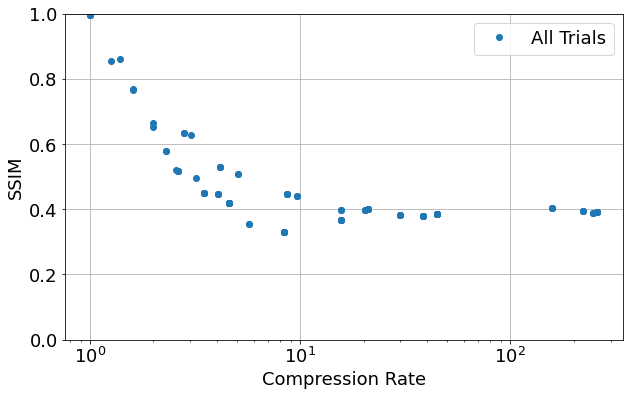

Results for image: image
../images/results/random_sampler_4.2.07_pareto_front.png saved


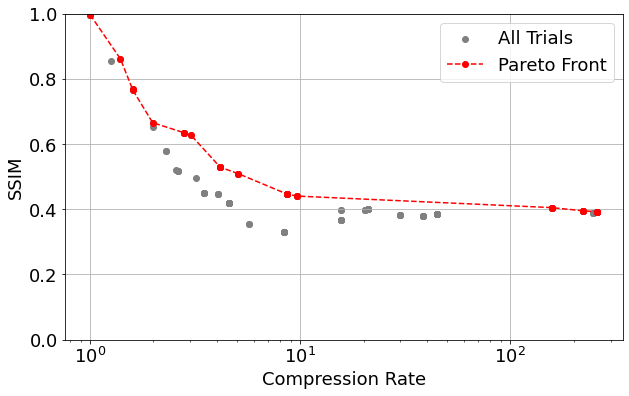

In [15]:
seed = 43
n_trials = 100

# search best hyperparameters of AQMP for each test image
for image_name in test_images:    
    # create study and begin to optimize
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    study_name = f"multiobj_random_sampler_trials:{n_trials}_seed:{seed}_image:{image_name}_time:{current_time}"
    storage_path = "sqlite:///"+study_name+".db" 
    sampler = RandomSampler(seed=seed)  # Make the sampler behave in a deterministic way
    study = optuna.create_study(directions=['maximize', 'maximize'], study_name=study_name, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)
    plot_results(study, plot_name="../images/results/"+"random_sampler_"+image_name, log_xscale=True)    

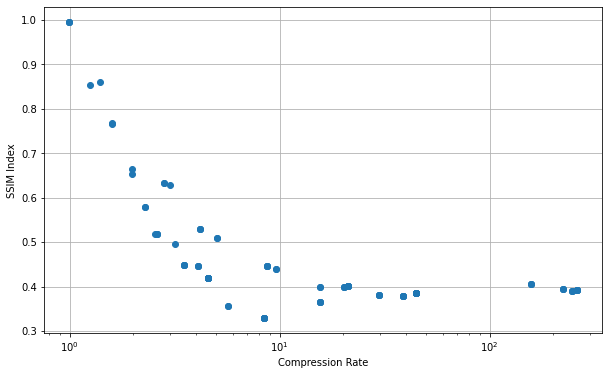

results for image  4.2.07


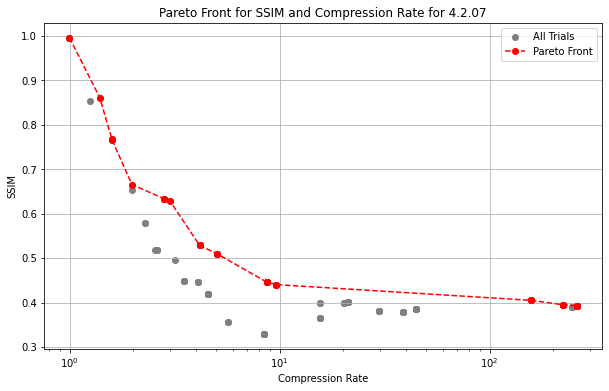

In [18]:
plot_results(study, log_xscale=True)

# 4. MP and Fixed Block Size (no AQ)

[I 2024-12-11 12:19:17,077] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:house_time:2024-12-11_12-19-17


8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2372052
DEFLATE applied. Bytes to write: 2198987
File saved.


[I 2024-12-11 12:19:56,757] Trial 0 finished with values: [0.9820943567045569, 0.9949471559097257] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 39.568145990371704
SSIM Index : 0.9949471559097257

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:20:03,592] Trial 1 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.734928846359253
SSIM Index : 0.49730753986500015

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2589662
DEFLATE applied. Bytes to write: 2404987
File saved.


[I 2024-12-11 12:20:55,442] Trial 2 finished with values: [0.9798964283807592, 0.9953732268635811] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 51.73663640022278
SSIM Index : 0.9953732268635811

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:21:02,501] Trial 3 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.940967559814453
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:21:09,622] Trial 4 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.001929044723511
SSIM Index : 0.49730753986500015

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:22:12,586] Trial 5 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 62.84163856506348
SSIM Index : 0.9429730307527349

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:22:20,638] Trial 6 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.942516565322876
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:22:28,805] Trial 7 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.056420803070068
SSIM Index : 0.49730753986500015

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2088422
DEFLATE applied. Bytes to write: 1926510
File saved.


[I 2024-12-11 12:23:14,681] Trial 8 finished with values: [0.9955242078954448, 0.9939861171234728] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 45.764639139175415
SSIM Index : 0.9939861171234728

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:24:01,200] Trial 9 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 46.41077899932861
SSIM Index : 0.9429730307527349

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:24:17,330] Trial 10 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.017600059509277
SSIM Index : 0.715312251851938

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:24:24,658] Trial 11 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.222836017608643
SSIM Index : 0.49730753986500015

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2625452
DEFLATE applied. Bytes to write: 2439115
File saved.


[I 2024-12-11 12:25:12,725] Trial 12 finished with values: [0.9798211017891957, 0.9954272796952058] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 47.954339265823364
SSIM Index : 0.9954272796952058

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 470417
DEFLATE applied. Bytes to write: 448184
File saved.


[I 2024-12-11 12:25:27,250] Trial 13 finished with values: [1.9588851036944068, 0.7150416866841464] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.414533376693726
SSIM Index : 0.7150416866841464

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:25:33,884] Trial 14 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.5257580280303955
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1508105
DEFLATE applied. Bytes to write: 1411448
File saved.


[I 2024-12-11 12:26:11,041] Trial 15 finished with values: [1.2616643066305557, 0.9406425935716264] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 37.04625129699707
SSIM Index : 0.9406425935716264

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:26:17,872] Trial 16 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.719820976257324
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:26:33,016] Trial 17 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.030827283859253
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:26:39,866] Trial 18 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.739717483520508
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:26:54,891] Trial 19 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.914051532745361
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:27:01,566] Trial 20 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.566522836685181
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:27:46,884] Trial 21 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 45.2090630531311
SSIM Index : 0.9429730307527349

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:28:31,684] Trial 22 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 44.68836045265198
SSIM Index : 0.9429730307527349

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:29:16,999] Trial 23 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 45.202879667282104
SSIM Index : 0.9429730307527349

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:29:23,617] Trial 24 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.508305072784424
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 474747
DEFLATE applied. Bytes to write: 452241
File saved.


[I 2024-12-11 12:29:38,420] Trial 25 finished with values: [1.950466936159179, 0.7150916593007386] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.692845106124878
SSIM Index : 0.7150916593007386

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:29:53,508] Trial 26 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.976948499679565
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 550452
DEFLATE applied. Bytes to write: 468318
File saved.


[I 2024-12-11 12:30:09,963] Trial 27 finished with values: [1.4084174598448738, 0.9180395042700235] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.342807292938232
SSIM Index : 0.9180395042700235

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2859162
DEFLATE applied. Bytes to write: 2668694
File saved.


[I 2024-12-11 12:31:00,839] Trial 28 finished with values: [0.9813676153242381, 0.995617143570818] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 50.7603816986084
SSIM Index : 0.995617143570818

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:31:07,507] Trial 29 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.560323476791382
SSIM Index : 0.5675348915884081

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:31:15,033] Trial 30 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.4182422161102295
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:31:30,447] Trial 31 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.304958820343018
SSIM Index : 0.715312251851938

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:31:45,381] Trial 32 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.82239031791687
SSIM Index : 0.715312251851938

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:32:00,327] Trial 33 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.835474014282227
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:32:07,408] Trial 34 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.971878528594971
SSIM Index : 0.5675348915884081

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:32:13,994] Trial 35 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.4771506786346436
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 496922
DEFLATE applied. Bytes to write: 473743
File saved.


[I 2024-12-11 12:32:28,911] Trial 36 finished with values: [1.91792233196377, 0.7152838314995487] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.80575704574585
SSIM Index : 0.7152838314995487

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:32:36,225] Trial 37 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.207894325256348
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:32:51,295] Trial 38 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.959813356399536
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2699197
DEFLATE applied. Bytes to write: 2510862
File saved.


[I 2024-12-11 12:33:40,323] Trial 39 finished with values: [0.9802606702399695, 0.9955166025260141] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 48.91642475128174
SSIM Index : 0.9955166025260141

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:33:46,949] Trial 40 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.518491268157959
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:34:32,338] Trial 41 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 45.27887582778931
SSIM Index : 0.9429730307527349

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:34:47,964] Trial 42 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.5139479637146
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:34:54,692] Trial 43 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.618474006652832
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:35:10,453] Trial 44 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.65034008026123
SSIM Index : 0.715312251851938

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:35:25,637] Trial 45 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.072060823440552
SSIM Index : 0.715312251851938

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:36:09,892] Trial 46 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 44.14744305610657
SSIM Index : 0.9429730307527349

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:36:25,013] Trial 47 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.010664463043213
SSIM Index : 0.715312251851938

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:36:40,022] Trial 48 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.89624285697937
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2882447
DEFLATE applied. Bytes to write: 2692674
File saved.


[I 2024-12-11 12:37:37,791] Trial 49 finished with values: [0.9814284858751262, 0.9956191905890569] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 57.65148663520813
SSIM Index : 0.9956191905890569

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:37:46,250] Trial 50 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.353388786315918
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:37:53,331] Trial 51 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.976701498031616
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 462472
DEFLATE applied. Bytes to write: 440594
File saved.


[I 2024-12-11 12:38:09,531] Trial 52 finished with values: [1.9713403160255363, 0.7147584776905753] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.087884187698364
SSIM Index : 0.7147584776905753

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 706292
DEFLATE applied. Bytes to write: 616265
File saved.


[I 2024-12-11 12:38:30,987] Trial 53 finished with values: [1.3000036830429869, 0.9418465262117883] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 21.33056640625
SSIM Index : 0.9418465262117883

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 774532
DEFLATE applied. Bytes to write: 680844
File saved.


[I 2024-12-11 12:38:52,090] Trial 54 finished with values: [1.2584359950415218, 0.9497087695734509] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 20.98680353164673
SSIM Index : 0.9497087695734509

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1533055
DEFLATE applied. Bytes to write: 1434639
File saved.


[I 2024-12-11 12:39:37,626] Trial 55 finished with values: [1.2574324713155522, 0.9410088372674349] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 45.410473346710205
SSIM Index : 0.9410088372674349

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 461462
DEFLATE applied. Bytes to write: 439695
File saved.


[I 2024-12-11 12:39:52,607] Trial 56 finished with values: [1.9714250116001306, 0.7147089619014224] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 14.859052658081055
SSIM Index : 0.7147089619014224

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:40:00,114] Trial 57 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.398182153701782
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:40:18,084] Trial 58 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 17.857709884643555
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:40:25,240] Trial 59 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.032535791397095
SSIM Index : 0.5675348915884081

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2128042
DEFLATE applied. Bytes to write: 1964441
File saved.


[I 2024-12-11 12:41:18,739] Trial 60 finished with values: [0.9917137639265607, 0.9941646271005079] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 53.37435603141785
SSIM Index : 0.9941646271005079

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:41:28,034] Trial 61 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 9.184667110443115
SSIM Index : 0.5675348915884081

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:41:36,375] Trial 62 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.221140384674072
SSIM Index : 0.5675348915884081

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2403952
DEFLATE applied. Bytes to write: 2229369
File saved.


[I 2024-12-11 12:42:36,403] Trial 63 finished with values: [0.9815628476084538, 0.9950211979131706] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 59.91015887260437
SSIM Index : 0.9950211979131706

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:42:52,107] Trial 64 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 15.589563608169556
SSIM Index : 0.715312251851938

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1229545
DEFLATE applied. Bytes to write: 1143432
File saved.


[I 2024-12-11 12:43:23,257] Trial 65 finished with values: [1.3189261436311637, 0.9342897175154233] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 31.036296606063843
SSIM Index : 0.9342897175154233

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:43:30,933] Trial 66 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.569506645202637
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:43:47,064] Trial 67 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.018861770629883
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2544197
DEFLATE applied. Bytes to write: 2361727
File saved.


[I 2024-12-11 12:44:38,340] Trial 68 finished with values: [0.9801057296950927, 0.9952976430021422] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 51.153117656707764
SSIM Index : 0.9952976430021422

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:44:45,723] Trial 69 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.272909164428711
SSIM Index : 0.49730753986500015

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2829687
DEFLATE applied. Bytes to write: 2638960
File saved.


[I 2024-12-11 12:45:44,499] Trial 70 finished with values: [0.9812962594657479, 0.9956076381918587] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 58.66543960571289
SSIM Index : 0.9956076381918587

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:46:34,523] Trial 71 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 49.91037702560425
SSIM Index : 0.9429730307527349

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2142527
DEFLATE applied. Bytes to write: 1978475
File saved.


[I 2024-12-11 12:47:21,605] Trial 72 finished with values: [0.9908079582309476, 0.9942281413474382] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 46.96843123435974
SSIM Index : 0.9942281413474382

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:47:28,440] Trial 73 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.72367787361145
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:48:20,491] Trial 74 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 51.937602043151855
SSIM Index : 0.9429730307527349

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:48:38,127] Trial 75 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 17.523085355758667
SSIM Index : 0.715312251851938

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:48:54,664] Trial 76 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.424734830856323
SSIM Index : 0.715312251851938

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:49:01,977] Trial 77 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.205596923828125
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:49:09,354] Trial 78 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.262831926345825
SSIM Index : 0.49730753986500015

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:49:17,492] Trial 79 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 8.018715620040894
SSIM Index : 0.5675348915884081

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:49:37,784] Trial 80 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 20.176451683044434
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2868332
DEFLATE applied. Bytes to write: 2678123
File saved.


[I 2024-12-11 12:50:38,063] Trial 81 finished with values: [0.9814998609655409, 0.9956185870337119] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 60.165541648864746
SSIM Index : 0.9956185870337119

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2548417
DEFLATE applied. Bytes to write: 2365745
File saved.


[I 2024-12-11 12:51:29,184] Trial 82 finished with values: [0.9800219984408872, 0.9953046312491648] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 51.00348734855652
SSIM Index : 0.9953046312491648

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:51:36,968] Trial 83 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.668440580368042
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:52:38,243] Trial 84 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 61.16627550125122
SSIM Index : 0.9429730307527349

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:52:45,387] Trial 85 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.038480758666992
SSIM Index : 0.49730753986500015

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:53:02,169] Trial 86 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 16.665958642959595
SSIM Index : 0.715312251851938

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2845802
DEFLATE applied. Bytes to write: 2655072
File saved.


[I 2024-12-11 12:54:04,564] Trial 87 finished with values: [0.9813445284697508, 0.995615082167971] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 62.27456450462341
SSIM Index : 0.995615082167971

32 32
image name:  house
processed_blocks: 768
bytes_written (without DEFLATE): 507502
DEFLATE applied. Bytes to write: 484458
File saved.


[I 2024-12-11 12:54:23,525] Trial 88 finished with values: [1.9180666385209275, 0.715312251851938] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 18.83748483657837
SSIM Index : 0.715312251851938

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:54:30,992] Trial 89 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.354370832443237
SSIM Index : 0.5675348915884081

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2803612
DEFLATE applied. Bytes to write: 2612995
File saved.


[I 2024-12-11 12:55:23,939] Trial 90 finished with values: [0.9812731759684187, 0.9956006255128566] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 52.83150792121887
SSIM Index : 0.9956006255128566

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 2886132
DEFLATE applied. Bytes to write: 2696458
File saved.


[I 2024-12-11 12:56:23,807] Trial 91 finished with values: [0.9814494774711572, 0.9956196234324559] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 59.752482175827026
SSIM Index : 0.9956196234324559

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:56:31,817] Trial 92 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.902157783508301
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:56:39,568] Trial 93 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.638325214385986
SSIM Index : 0.49730753986500015

128 128
image name:  house
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29922
File saved.


[I 2024-12-11 12:56:46,922] Trial 94 finished with values: [5.22210335840854, 0.49730753986500015] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 7.246189832687378
SSIM Index : 0.49730753986500015

64 64
image name:  house
processed_blocks: 192
bytes_written (without DEFLATE): 125685
DEFLATE applied. Bytes to write: 120014
File saved.


[I 2024-12-11 12:56:53,721] Trial 95 finished with values: [3.546751690821256, 0.5675348915884081] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 6.688530206680298
SSIM Index : 0.5675348915884081

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:57:42,984] Trial 96 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 49.1518828868866
SSIM Index : 0.9429730307527349

16 16
image name:  house
processed_blocks: 3072
bytes_written (without DEFLATE): 1851585
DEFLATE applied. Bytes to write: 1681896
File saved.


[I 2024-12-11 12:58:37,338] Trial 97 finished with values: [1.1803194773124808, 0.9429730307527349] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 54.24224328994751
SSIM Index : 0.9429730307527349

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 734177
DEFLATE applied. Bytes to write: 642837
File saved.


[I 2024-12-11 12:58:58,733] Trial 98 finished with values: [1.2815126989180645, 0.9452387998128543] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 21.278661489486694
SSIM Index : 0.9452387998128543

8 8
image name:  house
processed_blocks: 12288
bytes_written (without DEFLATE): 1448817
DEFLATE applied. Bytes to write: 1324023
File saved.


[I 2024-12-11 12:59:35,592] Trial 99 finished with values: [1.077571043775788, 0.9862144404560107] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/house_reconstructed.png
execution_time 36.74160051345825
SSIM Index : 0.9862144404560107

../images/results/MP_no_AQ_random_sampler_house_compression_vs_ssim.png saved


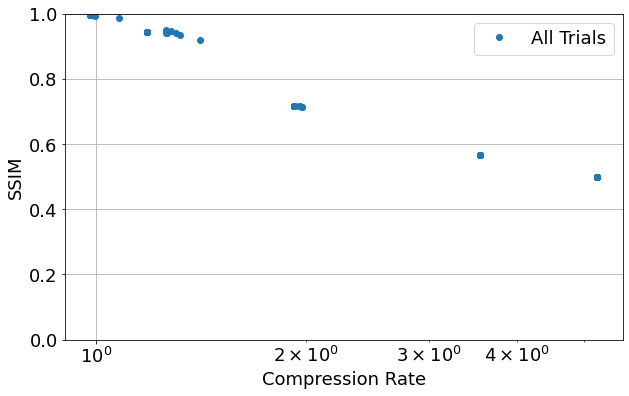

Results for image: image
../images/results/MP_no_AQ_random_sampler_house_pareto_front.png saved


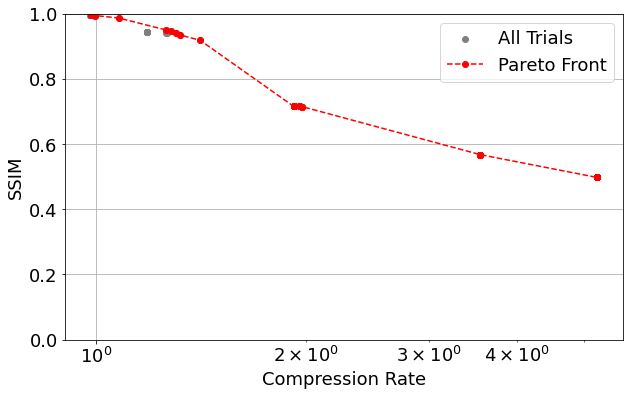

[I 2024-12-11 12:59:36,612] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:4.2.01_time:2024-12-11_12-59-36


8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2267547
DEFLATE applied. Bytes to write: 2090581
File saved.


[I 2024-12-11 13:00:24,714] Trial 0 finished with values: [0.9812240153784255, 0.9911835988957282] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 47.99188947677612
SSIM Index : 0.9911835988957282

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:00:31,668] Trial 1 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.8505518436431885
SSIM Index : 0.6626479796518644

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2516542
DEFLATE applied. Bytes to write: 2326636
File saved.


[I 2024-12-11 13:01:16,466] Trial 2 finished with values: [0.9816750609381872, 0.9921924274746238] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.69017696380615
SSIM Index : 0.9921924274746238

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:01:23,404] Trial 3 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.831157684326172
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:01:30,345] Trial 4 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.836100816726685
SSIM Index : 0.6626479796518644

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:02:15,925] Trial 5 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 45.47439932823181
SSIM Index : 0.9441687865409749

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:02:22,955] Trial 6 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.92289400100708
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:02:29,798] Trial 7 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.713075637817383
SSIM Index : 0.6626479796518644

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 1943487
DEFLATE applied. Bytes to write: 1777164
File saved.


[I 2024-12-11 13:03:07,206] Trial 8 finished with values: [0.9817799579537492, 0.9889973009602707] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 37.2968270778656
SSIM Index : 0.9889973009602707

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:03:50,081] Trial 9 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 42.77060794830322
SSIM Index : 0.9441687865409749

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:04:04,730] Trial 10 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.538896799087524
SSIM Index : 0.8105133925438435

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:04:11,700] Trial 11 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.863192081451416
SSIM Index : 0.6626479796518644

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2555347
DEFLATE applied. Bytes to write: 2364070
File saved.


[I 2024-12-11 13:04:56,382] Trial 12 finished with values: [0.9818970787790221, 0.9923141236485574] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.571913957595825
SSIM Index : 0.9923141236485574

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:05:11,576] Trial 13 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 15.084108352661133
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:05:18,063] Trial 14 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.3770880699157715
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1584100
DEFLATE applied. Bytes to write: 1449498
File saved.


[I 2024-12-11 13:05:55,620] Trial 15 finished with values: [1.2410225159571795, 0.9415620529857934] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 37.45226764678955
SSIM Index : 0.9415620529857934

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:06:02,165] Trial 16 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.433809041976929
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:06:16,606] Trial 17 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.33121132850647
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:06:23,302] Trial 18 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.585916519165039
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:06:38,237] Trial 19 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.825677156448364
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:06:44,949] Trial 20 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.603854417800903
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:07:29,312] Trial 21 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.259145736694336
SSIM Index : 0.9441687865409749

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:08:13,856] Trial 22 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.438029050827026
SSIM Index : 0.9441687865409749

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:09:01,094] Trial 23 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 47.14037251472473
SSIM Index : 0.9441687865409749

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:09:07,480] Trial 24 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.273947238922119
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:09:22,257] Trial 25 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.664335489273071
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:09:37,108] Trial 26 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.738619089126587
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 292812
DEFLATE applied. Bytes to write: 217549
File saved.


[I 2024-12-11 13:09:49,228] Trial 27 finished with values: [2.3926817303674275, 0.8623672064688112] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 12.00498652458191
SSIM Index : 0.8623672064688112

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2829032
DEFLATE applied. Bytes to write: 2631826
File saved.


[I 2024-12-11 13:10:40,800] Trial 28 finished with values: [0.9829230792195967, 0.9927156197551287] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 51.46442103385925
SSIM Index : 0.9927156197551287

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:10:47,457] Trial 29 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.547095775604248
SSIM Index : 0.6910119301865175

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:10:54,347] Trial 30 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.782521963119507
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:11:08,748] Trial 31 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.292584419250488
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:11:23,395] Trial 32 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.536731243133545
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:11:38,658] Trial 33 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 15.143704652786255
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:11:46,278] Trial 34 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.507719278335571
SSIM Index : 0.6910119301865175

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:11:53,163] Trial 35 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.772968292236328
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:12:07,979] Trial 36 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.702162742614746
SSIM Index : 0.8105133925438435

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:12:15,261] Trial 37 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.173184871673584
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:12:30,002] Trial 38 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.629685878753662
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2637832
DEFLATE applied. Bytes to write: 2443804
File saved.


[I 2024-12-11 13:13:17,819] Trial 39 finished with values: [0.9823365308588563, 0.9925126966539711] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 47.70959830284119
SSIM Index : 0.9925126966539711

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:13:24,383] Trial 40 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.454338312149048
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:14:09,348] Trial 41 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.85913848876953
SSIM Index : 0.9441687865409749

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:14:24,289] Trial 42 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.832309246063232
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:14:30,875] Trial 43 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.473254203796387
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:14:45,679] Trial 44 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.693670272827148
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:15:00,429] Trial 45 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.640037536621094
SSIM Index : 0.8105133925438435

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:15:43,529] Trial 46 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 42.993733167648315
SSIM Index : 0.9441687865409749

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:15:58,502] Trial 47 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.862777471542358
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:16:13,377] Trial 48 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.766525030136108
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2859337
DEFLATE applied. Bytes to write: 2662938
File saved.


[I 2024-12-11 13:17:03,528] Trial 49 finished with values: [0.9829132976738401, 0.9927236025048579] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 50.04299068450928
SSIM Index : 0.9927236025048579

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:17:10,735] Trial 50 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.099276065826416
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:17:17,955] Trial 51 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.112043857574463
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507057
DEFLATE applied. Bytes to write: 483888
File saved.


[I 2024-12-11 13:17:32,528] Trial 52 finished with values: [1.9376167846160637, 0.8105105564643443] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.462538480758667
SSIM Index : 0.8105105564643443

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 379637
DEFLATE applied. Bytes to write: 301756
File saved.


[I 2024-12-11 13:17:46,224] Trial 53 finished with values: [1.8359682141363447, 0.8933834324688931] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 13.584854125976562
SSIM Index : 0.8933834324688931

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 426827
DEFLATE applied. Bytes to write: 347483
File saved.


[I 2024-12-11 13:18:00,052] Trial 54 finished with values: [1.6673503494378608, 0.9052516047729036] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 13.71440601348877
SSIM Index : 0.9052516047729036

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1653330
DEFLATE applied. Bytes to write: 1513888
File saved.


[I 2024-12-11 13:18:38,276] Trial 55 finished with values: [1.2382686642010907, 0.9425103283707327] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 38.119627952575684
SSIM Index : 0.9425103283707327

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507027
DEFLATE applied. Bytes to write: 483864
File saved.


[I 2024-12-11 13:18:53,263] Trial 56 finished with values: [1.9375692721155826, 0.8105099861996662] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.877497673034668
SSIM Index : 0.8105099861996662

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:19:00,637] Trial 57 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.267163276672363
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:19:15,140] Trial 58 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.392642498016357
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:19:21,975] Trial 59 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.723657608032227
SSIM Index : 0.6910119301865175

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 1986447
DEFLATE applied. Bytes to write: 1818525
File saved.


[I 2024-12-11 13:19:57,883] Trial 60 finished with values: [0.981302004421152, 0.9894019540235318] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 35.79954123497009
SSIM Index : 0.9894019540235318

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:20:04,613] Trial 61 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.6205174922943115
SSIM Index : 0.6910119301865175

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:20:11,367] Trial 62 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.641218185424805
SSIM Index : 0.6910119301865175

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2305412
DEFLATE applied. Bytes to write: 2126604
File saved.


[I 2024-12-11 13:20:52,011] Trial 63 finished with values: [0.9811387290557941, 0.9913590633923192] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 40.53550624847412
SSIM Index : 0.9913590633923192

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:21:06,635] Trial 64 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.51176142692566
SSIM Index : 0.8105133925438435

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1002080
DEFLATE applied. Bytes to write: 914462
File saved.


[I 2024-12-11 13:21:30,395] Trial 65 finished with values: [1.3242143508339144, 0.9228566117516724] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 23.649510622024536
SSIM Index : 0.9228566117516724

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:21:37,340] Trial 66 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.838052034378052
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:21:52,336] Trial 67 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.885653972625732
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2466122
DEFLATE applied. Bytes to write: 2278657
File saved.


[I 2024-12-11 13:22:35,876] Trial 68 finished with values: [0.9814555815842622, 0.9920150980326712] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 43.43277382850647
SSIM Index : 0.9920150980326712

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:22:42,767] Trial 69 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.782753229141235
SSIM Index : 0.6626479796518644

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2790462
DEFLATE applied. Bytes to write: 2592982
File saved.


[I 2024-12-11 13:23:32,017] Trial 70 finished with values: [0.982932860960039, 0.9927017956133621] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 49.14940881729126
SSIM Index : 0.9927017956133621

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:24:18,717] Trial 71 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 46.59316158294678
SSIM Index : 0.9441687865409749

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2002732
DEFLATE applied. Bytes to write: 1834173
File saved.


[I 2024-12-11 13:24:55,947] Trial 72 finished with values: [0.9813702550039495, 0.9895426446311935] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 37.11999464035034
SSIM Index : 0.9895426446311935

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:25:02,575] Trial 73 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.52138614654541
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:25:46,174] Trial 74 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 43.495115756988525
SSIM Index : 0.9441687865409749

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:26:01,250] Trial 75 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.96582293510437
SSIM Index : 0.8105133925438435

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:26:16,445] Trial 76 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 15.085643291473389
SSIM Index : 0.8105133925438435

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:26:23,857] Trial 77 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.306992530822754
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:26:31,136] Trial 78 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.172454357147217
SSIM Index : 0.6626479796518644

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:26:37,691] Trial 79 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.4476306438446045
SSIM Index : 0.6910119301865175

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:26:52,368] Trial 80 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.568420886993408
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2841102
DEFLATE applied. Bytes to write: 2644121
File saved.


[I 2024-12-11 13:27:42,401] Trial 81 finished with values: [0.9828815089946089, 0.992720223753091] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 49.923195123672485
SSIM Index : 0.992720223753091

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2470757
DEFLATE applied. Bytes to write: 2282952
File saved.


[I 2024-12-11 13:28:27,336] Trial 82 finished with values: [0.9815116614164622, 0.992034199967676] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.82746195793152
SSIM Index : 0.992034199967676

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:28:33,995] Trial 83 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.549259185791016
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:29:17,567] Trial 84 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 43.466289043426514
SSIM Index : 0.9441687865409749

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:29:24,959] Trial 85 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.287207841873169
SSIM Index : 0.6626479796518644

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:29:39,326] Trial 86 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.257691860198975
SSIM Index : 0.8105133925438435

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2810772
DEFLATE applied. Bytes to write: 2613418
File saved.


[I 2024-12-11 13:30:31,341] Trial 87 finished with values: [0.9829695442207167, 0.9927084519553744] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 51.90825915336609
SSIM Index : 0.9927084519553744

32 32
image name:  4.2.01
processed_blocks: 768
bytes_written (without DEFLATE): 507612
DEFLATE applied. Bytes to write: 484407
File saved.


[I 2024-12-11 13:30:46,281] Trial 88 finished with values: [1.9376167846160637, 0.8105133925438435] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 14.828697919845581
SSIM Index : 0.8105133925438435

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:30:53,030] Trial 89 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.637177467346191
SSIM Index : 0.6910119301865175

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2758667
DEFLATE applied. Bytes to write: 2561448
File saved.


[I 2024-12-11 13:31:43,251] Trial 90 finished with values: [0.9828815089946089, 0.9926809433459441] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 50.11215853691101
SSIM Index : 0.9926809433459441

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 2864122
DEFLATE applied. Bytes to write: 2667854
File saved.


[I 2024-12-11 13:32:34,229] Trial 91 finished with values: [0.9829426428951729, 0.9927239579628563] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 50.871758460998535
SSIM Index : 0.9927239579628563

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:32:41,507] Trial 92 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.171457290649414
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:32:48,726] Trial 93 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 7.111700534820557
SSIM Index : 0.6626479796518644

128 128
image name:  4.2.01
processed_blocks: 48
bytes_written (without DEFLATE): 31367
DEFLATE applied. Bytes to write: 29934
File saved.


[I 2024-12-11 13:32:55,819] Trial 94 finished with values: [3.843621399176955, 0.6626479796518644] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.988142728805542
SSIM Index : 0.6626479796518644

64 64
image name:  4.2.01
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 120033
File saved.


[I 2024-12-11 13:33:02,187] Trial 95 finished with values: [2.8969840955586355, 0.6910119301865175] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 6.259435653686523
SSIM Index : 0.6910119301865175

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:33:45,532] Trial 96 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 43.23914337158203
SSIM Index : 0.9441687865409749

16 16
image name:  4.2.01
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
DEFLATE applied. Bytes to write: 1731360
File saved.


[I 2024-12-11 13:34:29,821] Trial 97 finished with values: [1.2282596530498042, 0.9441687865409749] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 44.18575930595398
SSIM Index : 0.9441687865409749

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 398357
DEFLATE applied. Bytes to write: 320010
File saved.


[I 2024-12-11 13:34:43,411] Trial 98 finished with values: [1.7626729961006167, 0.8985407733887317] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 13.476284742355347
SSIM Index : 0.8985407733887317

8 8
image name:  4.2.01
processed_blocks: 12288
bytes_written (without DEFLATE): 1140707
DEFLATE applied. Bytes to write: 1031092
File saved.


[I 2024-12-11 13:35:09,576] Trial 99 finished with values: [1.0379086409633997, 0.9714372199252833] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.01_reconstructed.png
execution_time 26.05131506919861
SSIM Index : 0.9714372199252833

../images/results/MP_no_AQ_random_sampler_4.2.01_compression_vs_ssim.png saved


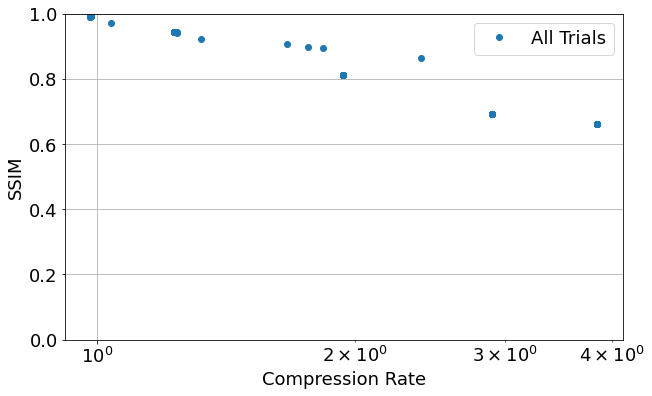

Results for image: image
../images/results/MP_no_AQ_random_sampler_4.2.01_pareto_front.png saved


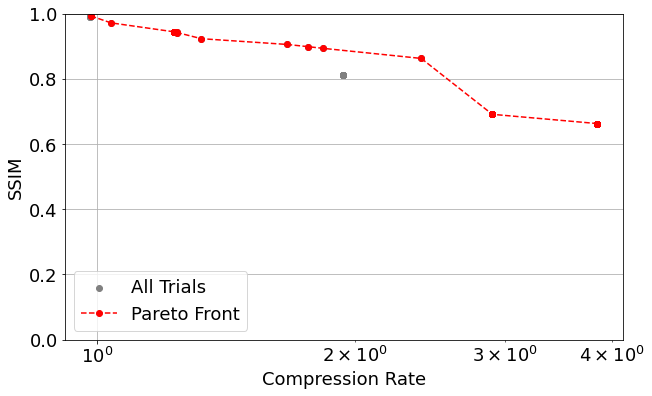

[I 2024-12-11 13:35:10,590] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:4.2.05_time:2024-12-11_13-35-10


8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2163507
DEFLATE applied. Bytes to write: 1993772
File saved.


[I 2024-12-11 13:35:49,856] Trial 0 finished with values: [0.9883720396443212, 0.9931082592922339] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 39.152403831481934
SSIM Index : 0.9931082592922339

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:35:57,284] Trial 1 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.316072702407837
SSIM Index : 0.5862839738572689

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2405527
DEFLATE applied. Bytes to write: 2220149
File saved.


[I 2024-12-11 13:36:40,366] Trial 2 finished with values: [0.9865107584032843, 0.9939355172443672] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.96931862831116
SSIM Index : 0.9939355172443672

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:36:47,763] Trial 3 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.290723562240601
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:36:55,027] Trial 4 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.15752387046814
SSIM Index : 0.5862839738572689

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:37:37,301] Trial 5 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.16386032104492
SSIM Index : 0.9460145548662992

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:37:44,705] Trial 6 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.295332908630371
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:37:52,183] Trial 7 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.368309020996094
SSIM Index : 0.5862839738572689

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 1828352
DEFLATE applied. Bytes to write: 1672919
File saved.


[I 2024-12-11 13:38:26,112] Trial 8 finished with values: [0.9964018206093535, 0.9912043998374638] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 33.81638789176941
SSIM Index : 0.9912043998374638

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:39:08,654] Trial 9 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.43240308761597
SSIM Index : 0.9460145548662992

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:39:23,689] Trial 10 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.922827959060669
SSIM Index : 0.7693380021162861

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:39:31,148] Trial 11 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.353433847427368
SSIM Index : 0.5862839738572689

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2443667
DEFLATE applied. Bytes to write: 2256869
File saved.


[I 2024-12-11 13:40:17,504] Trial 12 finished with values: [0.9865062382874606, 0.994033678108868] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 46.243701696395874
SSIM Index : 0.994033678108868

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 480737
DEFLATE applied. Bytes to write: 458495
File saved.


[I 2024-12-11 13:40:31,810] Trial 13 finished with values: [1.9864924712134633, 0.7692481242634989] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.19289255142212
SSIM Index : 0.7692481242634989

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:40:38,933] Trial 14 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.010600328445435
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1263195
DEFLATE applied. Bytes to write: 1164987
File saved.


[I 2024-12-11 13:41:09,502] Trial 15 finished with values: [1.2960790274471088, 0.9410588994140836] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 30.456895351409912
SSIM Index : 0.9410588994140836

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:41:16,215] Trial 16 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.601446628570557
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:41:31,484] Trial 17 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.152377128601074
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:41:38,333] Trial 18 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.7376086711883545
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:41:53,594] Trial 19 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.14460802078247
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:42:00,744] Trial 20 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.035565137863159
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:42:45,885] Trial 21 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 45.03161978721619
SSIM Index : 0.9460145548662992

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:43:29,308] Trial 22 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 43.31641888618469
SSIM Index : 0.9460145548662992

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:44:12,526] Trial 23 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 43.10984539985657
SSIM Index : 0.9460145548662992

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:44:19,196] Trial 24 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.556870460510254
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 487132
DEFLATE applied. Bytes to write: 464698
File saved.


[I 2024-12-11 13:44:33,983] Trial 25 finished with values: [1.9830527207751538, 0.7692856658102363] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.673134803771973
SSIM Index : 0.7692856658102363

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:44:48,884] Trial 26 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.790164947509766
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 377897
DEFLATE applied. Bytes to write: 300022
File saved.


[I 2024-12-11 13:45:02,517] Trial 27 finished with values: [1.8317664775095925, 0.9028218508614322] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 13.518630027770996
SSIM Index : 0.9028218508614322

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2703822
DEFLATE applied. Bytes to write: 2512125
File saved.


[I 2024-12-11 13:45:50,527] Trial 28 finished with values: [0.9874722235599249, 0.9943694252985154] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 47.89650583267212
SSIM Index : 0.9943694252985154

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:45:57,984] Trial 29 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.341189384460449
SSIM Index : 0.6467224617831863

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:46:04,951] Trial 30 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.860961198806763
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:46:19,702] Trial 31 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.637567043304443
SSIM Index : 0.7693380021162861

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:46:34,674] Trial 32 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.861658334732056
SSIM Index : 0.7693380021162861

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:46:49,589] Trial 33 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.801738023757935
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:46:56,277] Trial 34 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.574526786804199
SSIM Index : 0.6467224617831863

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:47:02,805] Trial 35 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.417385578155518
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 499072
DEFLATE applied. Bytes to write: 475983
File saved.


[I 2024-12-11 13:47:17,887] Trial 36 finished with values: [1.9775429508287063, 0.7693265758949434] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.961626529693604
SSIM Index : 0.7693265758949434

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:47:24,864] Trial 37 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.867372989654541
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:47:39,856] Trial 38 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.878115892410278
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2524187
DEFLATE applied. Bytes to write: 2334387
File saved.


[I 2024-12-11 13:48:26,134] Trial 39 finished with values: [0.9866848143641775, 0.9942046521268787] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 46.1645290851593
SSIM Index : 0.9942046521268787

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:48:32,714] Trial 40 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.464540243148804
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:49:16,494] Trial 41 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 43.67086958885193
SSIM Index : 0.9460145548662992

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:49:31,728] Trial 42 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.120895385742188
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:49:38,349] Trial 43 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.506582975387573
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:49:53,345] Trial 44 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.881141901016235
SSIM Index : 0.7693380021162861

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:50:08,780] Trial 45 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.320972442626953
SSIM Index : 0.7693380021162861

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:50:53,502] Trial 46 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 44.61236238479614
SSIM Index : 0.9460145548662992

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:51:08,300] Trial 47 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.684114217758179
SSIM Index : 0.7693380021162861

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:51:23,607] Trial 48 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.192811012268066
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2731987
DEFLATE applied. Bytes to write: 2541595
File saved.


[I 2024-12-11 13:52:15,805] Trial 49 finished with values: [0.9874790170340405, 0.9943714044278101] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 52.086222410202026
SSIM Index : 0.9943714044278101

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:52:23,392] Trial 50 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.476740121841431
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:52:30,804] Trial 51 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.302130222320557
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 442962
DEFLATE applied. Bytes to write: 421996
File saved.


[I 2024-12-11 13:52:44,530] Trial 52 finished with values: [2.0062244916975716, 0.7688336343132914] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 13.613318920135498
SSIM Index : 0.7688336343132914

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 472607
DEFLATE applied. Bytes to write: 391604
File saved.


[I 2024-12-11 13:52:59,883] Trial 53 finished with values: [1.6153776897452057, 0.9247872219847038] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.23694109916687
SSIM Index : 0.9247872219847038

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 518732
DEFLATE applied. Bytes to write: 435837
File saved.


[I 2024-12-11 13:53:15,357] Trial 54 finished with values: [1.5414144523713216, 0.933050357254662] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.360832691192627
SSIM Index : 0.933050357254662

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1313750
DEFLATE applied. Bytes to write: 1205240
File saved.


[I 2024-12-11 13:53:46,924] Trial 55 finished with values: [1.2823194482495741, 0.9420529604283114] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 31.454468965530396
SSIM Index : 0.9420529604283114

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 440697
DEFLATE applied. Bytes to write: 419847
File saved.


[I 2024-12-11 13:54:01,550] Trial 56 finished with values: [2.0075432993776077, 0.7687703414264733] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.513752937316895
SSIM Index : 0.7687703414264733

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:54:09,251] Trial 57 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.591341018676758
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:54:24,048] Trial 58 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.68682861328125
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:54:30,950] Trial 59 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.790556192398071
SSIM Index : 0.6467224617831863

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 1874517
DEFLATE applied. Bytes to write: 1717473
File saved.


[I 2024-12-11 13:55:06,795] Trial 60 finished with values: [0.9946664141163317, 0.9915594346028088] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 35.73191428184509
SSIM Index : 0.9915594346028088

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:55:13,765] Trial 61 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.858412504196167
SSIM Index : 0.6467224617831863

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 13:55:20,678] Trial 62 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.801233768463135
SSIM Index : 0.6467224617831863

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2200197
DEFLATE applied. Bytes to write: 2027815
File saved.


[I 2024-12-11 13:56:01,662] Trial 63 finished with values: [0.9879751932435316, 0.993253015691978] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 40.87128925323486
SSIM Index : 0.993253015691978

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:56:17,218] Trial 64 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.443567514419556
SSIM Index : 0.7693380021162861

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 900730
DEFLATE applied. Bytes to write: 829651
File saved.


[I 2024-12-11 13:56:40,501] Trial 65 finished with values: [1.498814823581008, 0.9301497807503695] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 23.169395923614502
SSIM Index : 0.9301497807503695

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:56:48,199] Trial 66 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.589229583740234
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 13:57:03,447] Trial 67 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.135433197021484
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2355722
DEFLATE applied. Bytes to write: 2172772
File saved.


[I 2024-12-11 13:57:46,536] Trial 68 finished with values: [0.9865604824113234, 0.9937919279602133] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.974857807159424
SSIM Index : 0.9937919279602133

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 13:57:53,391] Trial 69 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.749640226364136
SSIM Index : 0.5862839738572689

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2669112
DEFLATE applied. Bytes to write: 2477016
File saved.


[I 2024-12-11 13:58:44,443] Trial 70 finished with values: [0.9874744880409109, 0.9943630764355205] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 50.935203552246094
SSIM Index : 0.9943630764355205

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 13:59:26,955] Trial 71 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.401466846466064
SSIM Index : 0.9460145548662992

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 1892122
DEFLATE applied. Bytes to write: 1734573
File saved.


[I 2024-12-11 14:00:02,026] Trial 72 finished with values: [0.9940533353032429, 0.9916844787081707] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 34.95696687698364
SSIM Index : 0.9916844787081707

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 14:00:08,743] Trial 73 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.599502325057983
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 14:00:51,713] Trial 74 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.856537103652954
SSIM Index : 0.9460145548662992

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 14:01:06,550] Trial 75 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.727112770080566
SSIM Index : 0.7693380021162861

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 14:01:21,530] Trial 76 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.867199897766113
SSIM Index : 0.7693380021162861

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:01:29,025] Trial 77 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.388110160827637
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:01:36,395] Trial 78 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.264466285705566
SSIM Index : 0.5862839738572689

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 14:01:43,190] Trial 79 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.684959888458252
SSIM Index : 0.6467224617831863

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 14:01:58,072] Trial 80 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.76849889755249
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2715012
DEFLATE applied. Bytes to write: 2523943
File saved.


[I 2024-12-11 14:02:46,896] Trial 81 finished with values: [0.9875311034411586, 0.9943704049726342] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 48.71088004112244
SSIM Index : 0.9943704049726342

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2360372
DEFLATE applied. Bytes to write: 2177183
File saved.


[I 2024-12-11 14:03:29,824] Trial 82 finished with values: [0.9865717840213165, 0.9938054197876259] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 42.816471099853516
SSIM Index : 0.9938054197876259

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 14:03:36,775] Trial 83 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.84060525894165
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 14:04:21,937] Trial 84 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 45.05352210998535
SSIM Index : 0.9460145548662992

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:04:28,838] Trial 85 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.793020248413086
SSIM Index : 0.5862839738572689

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 14:04:44,577] Trial 86 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.628314018249512
SSIM Index : 0.7693380021162861

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2687632
DEFLATE applied. Bytes to write: 2495690
File saved.


[I 2024-12-11 14:05:33,493] Trial 87 finished with values: [0.9873816528360899, 0.9943655688900707] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 48.80551338195801
SSIM Index : 0.9943655688900707

32 32
image name:  4.2.05
processed_blocks: 768
bytes_written (without DEFLATE): 507392
DEFLATE applied. Bytes to write: 484628
File saved.


[I 2024-12-11 14:05:48,384] Trial 88 finished with values: [1.9748221729978124, 0.7693380021162861] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 14.77851152420044
SSIM Index : 0.7693380021162861

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 14:05:55,317] Trial 89 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.814706325531006
SSIM Index : 0.6467224617831863

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2639457
DEFLATE applied. Bytes to write: 2447598
File saved.


[I 2024-12-11 14:06:45,078] Trial 90 finished with values: [0.9873159994497179, 0.9943488560744909] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 49.647687673568726
SSIM Index : 0.9943488560744909

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 2736892
DEFLATE applied. Bytes to write: 2546731
File saved.


[I 2024-12-11 14:07:34,105] Trial 91 finished with values: [0.9874858106016305, 0.9943710746713043] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 48.91441464424133
SSIM Index : 0.9943710746713043

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:07:41,667] Trial 92 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.456732511520386
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:07:49,112] Trial 93 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.334591627120972
SSIM Index : 0.5862839738572689

128 128
image name:  4.2.05
processed_blocks: 48
bytes_written (without DEFLATE): 31347
DEFLATE applied. Bytes to write: 29911
File saved.


[I 2024-12-11 14:07:56,492] Trial 94 finished with values: [5.693538363898401, 0.5862839738572689] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 7.273563385009766
SSIM Index : 0.5862839738572689

64 64
image name:  4.2.05
processed_blocks: 192
bytes_written (without DEFLATE): 125625
DEFLATE applied. Bytes to write: 120141
File saved.


[I 2024-12-11 14:08:03,195] Trial 95 finished with values: [3.6117863163986814, 0.6467224617831863] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 6.595410346984863
SSIM Index : 0.6467224617831863

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 14:08:50,007] Trial 96 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 46.70340418815613
SSIM Index : 0.9460145548662992

16 16
image name:  4.2.05
processed_blocks: 3072
bytes_written (without DEFLATE): 1824600
DEFLATE applied. Bytes to write: 1618437
File saved.


[I 2024-12-11 14:09:33,421] Trial 97 finished with values: [1.2015469699590935, 0.9460145548662992] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 43.30382180213928
SSIM Index : 0.9460145548662992

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 491002
DEFLATE applied. Bytes to write: 409359
File saved.


[I 2024-12-11 14:09:48,798] Trial 98 finished with values: [1.5825998110912238, 0.928305952871907] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 15.260796785354614
SSIM Index : 0.928305952871907

8 8
image name:  4.2.05
processed_blocks: 12288
bytes_written (without DEFLATE): 1076352
DEFLATE applied. Bytes to write: 972021
File saved.


[I 2024-12-11 14:10:14,515] Trial 99 finished with values: [1.1442723668406338, 0.9765429659340096] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.05_reconstructed.png
execution_time 25.601873636245728
SSIM Index : 0.9765429659340096

../images/results/MP_no_AQ_random_sampler_4.2.05_compression_vs_ssim.png saved


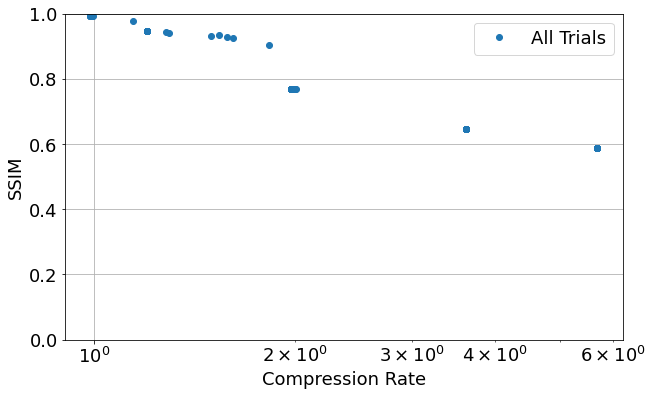

Results for image: image
../images/results/MP_no_AQ_random_sampler_4.2.05_pareto_front.png saved


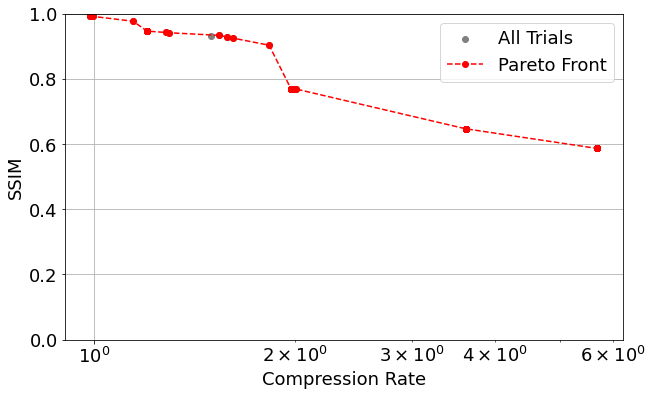

[I 2024-12-11 14:10:15,607] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:4.2.06_time:2024-12-11_14-10-15


8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2775622
DEFLATE applied. Bytes to write: 2581206
File saved.


[I 2024-12-11 14:11:06,578] Trial 0 finished with values: [0.9990625394685114, 0.995138335638906] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 50.85291004180908
SSIM Index : 0.995138335638906

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:11:14,049] Trial 1 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.362031698226929
SSIM Index : 0.3734924603508912

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2971777
DEFLATE applied. Bytes to write: 2772592
File saved.


[I 2024-12-11 14:12:07,721] Trial 2 finished with values: [0.9986894679097458, 0.9956197629575289] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 53.558239459991455
SSIM Index : 0.9956197629575289

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:12:14,669] Trial 3 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.842267274856567
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:12:21,559] Trial 4 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.7846550941467285
SSIM Index : 0.3734924603508912

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:13:07,367] Trial 5 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.69479274749756
SSIM Index : 0.8864268527925364

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:13:14,592] Trial 6 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.119348049163818
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:13:21,479] Trial 7 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.777773141860962
SSIM Index : 0.3734924603508912

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2549652
DEFLATE applied. Bytes to write: 2361109
File saved.


[I 2024-12-11 14:14:06,199] Trial 8 finished with values: [0.9998896192219223, 0.994067309659325] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 44.600616693496704
SSIM Index : 0.994067309659325

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:14:53,742] Trial 9 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 47.432565689086914
SSIM Index : 0.8864268527925364

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:15:08,863] Trial 10 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.009149312973022
SSIM Index : 0.6366678464767697

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:15:16,458] Trial 11 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.485885143280029
SSIM Index : 0.3734924603508912

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3006097
DEFLATE applied. Bytes to write: 2806034
File saved.


[I 2024-12-11 14:16:10,510] Trial 12 finished with values: [0.9986681579504213, 0.9956720613766] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 53.92626142501831
SSIM Index : 0.9956720613766

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:16:29,709] Trial 13 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 19.087364196777344
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:16:36,631] Trial 14 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.811355352401733
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1859650
DEFLATE applied. Bytes to write: 1756764
File saved.


[I 2024-12-11 14:17:20,751] Trial 15 finished with values: [1.268586762317577, 0.8857351909780481] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 44.006051540374756
SSIM Index : 0.8857351909780481

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:17:27,584] Trial 16 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.722641944885254
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:17:42,392] Trial 17 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.69591760635376
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:17:49,232] Trial 18 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.730148553848267
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:18:04,447] Trial 19 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.103388547897339
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:18:11,703] Trial 20 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.142346620559692
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:18:58,099] Trial 21 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.28229379653931
SSIM Index : 0.8864268527925364

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:19:44,209] Trial 22 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.99817895889282
SSIM Index : 0.8864268527925364

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:20:31,218] Trial 23 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.896583795547485
SSIM Index : 0.8864268527925364

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:20:38,067] Trial 24 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.735250234603882
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:20:53,466] Trial 25 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.28670334815979
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:21:08,693] Trial 26 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.114595413208008
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 712197
DEFLATE applied. Bytes to write: 625430
File saved.


[I 2024-12-11 14:21:28,193] Trial 27 finished with values: [1.413254085283919, 0.8715803029137806] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 19.386793613433838
SSIM Index : 0.8715803029137806

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3253757
DEFLATE applied. Bytes to write: 3048750
File saved.


[I 2024-12-11 14:22:26,967] Trial 28 finished with values: [0.9987338665794125, 0.9958618125216631] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 58.65537619590759
SSIM Index : 0.9958618125216631

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:22:33,628] Trial 29 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.550691604614258
SSIM Index : 0.4399838640468852

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:22:40,661] Trial 30 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.928073406219482
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:22:55,338] Trial 31 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.567610263824463
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:23:10,266] Trial 32 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.818382024765015
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:23:25,289] Trial 33 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.91132640838623
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:23:31,921] Trial 34 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.5181334018707275
SSIM Index : 0.4399838640468852

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:23:38,706] Trial 35 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.6718666553497314
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:23:53,881] Trial 36 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.066229104995728
SSIM Index : 0.6366678464767697

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:24:01,105] Trial 37 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.114580869674683
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:24:16,380] Trial 38 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.159913778305054
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3079372
DEFLATE applied. Bytes to write: 2877589
File saved.


[I 2024-12-11 14:25:09,642] Trial 39 finished with values: [0.9987178826035696, 0.9957659838448439] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 53.145750522613525
SSIM Index : 0.9957659838448439

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:25:16,302] Trial 40 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.5490546226501465
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:26:02,289] Trial 41 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.874327421188354
SSIM Index : 0.8864268527925364

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:26:17,620] Trial 42 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.217889785766602
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:26:24,371] Trial 43 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.636536121368408
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:26:39,357] Trial 44 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.87362027168274
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:26:54,696] Trial 45 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.22622013092041
SSIM Index : 0.6366678464767697

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:27:40,399] Trial 46 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.58980178833008
SSIM Index : 0.8864268527925364

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:27:55,728] Trial 47 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.215282917022705
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:28:12,685] Trial 48 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 16.842866897583008
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3282402
DEFLATE applied. Bytes to write: 3077778
File saved.


[I 2024-12-11 14:29:11,688] Trial 49 finished with values: [0.9987161066378354, 0.9958652294761041] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 58.88693690299988
SSIM Index : 0.9958652294761041

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:29:18,741] Trial 50 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.946471929550171
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:29:25,730] Trial 51 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.881916284561157
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 504222
DEFLATE applied. Bytes to write: 481404
File saved.


[I 2024-12-11 14:29:40,362] Trial 52 finished with values: [2.125092229979, 0.6365939312508581] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.520601987838745
SSIM Index : 0.6365939312508581

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 970947
DEFLATE applied. Bytes to write: 868377
File saved.


[I 2024-12-11 14:30:02,235] Trial 53 finished with values: [1.2123455777437675, 0.9161376964761435] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 21.75808596611023
SSIM Index : 0.9161376964761435

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 1080007
DEFLATE applied. Bytes to write: 970471
File saved.


[I 2024-12-11 14:30:25,594] Trial 54 finished with values: [1.159805470371403, 0.9306065063513215] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 23.243694067001343
SSIM Index : 0.9306065063513215

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1869315
DEFLATE applied. Bytes to write: 1765328
File saved.


[I 2024-12-11 14:31:09,871] Trial 55 finished with values: [1.2671499448358952, 0.885908823979559] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 44.164188385009766
SSIM Index : 0.885908823979559

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 504097
DEFLATE applied. Bytes to write: 481295
File saved.


[I 2024-12-11 14:31:24,640] Trial 56 finished with values: [2.1251002709206763, 0.6365877268419683] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.659406185150146
SSIM Index : 0.6365877268419683

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:31:31,718] Trial 57 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.9710376262664795
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:31:46,479] Trial 58 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.651283025741577
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:31:53,194] Trial 59 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.602001428604126
SSIM Index : 0.4399838640468852

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2580707
DEFLATE applied. Bytes to write: 2390949
File saved.


[I 2024-12-11 14:32:39,953] Trial 60 finished with values: [0.9997418895465267, 0.994263330351103] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.64064431190491
SSIM Index : 0.994263330351103

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:32:46,589] Trial 61 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.524428844451904
SSIM Index : 0.4399838640468852

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:32:53,326] Trial 62 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.62302827835083
SSIM Index : 0.4399838640468852

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2802692
DEFLATE applied. Bytes to write: 2607668
File saved.


[I 2024-12-11 14:33:42,523] Trial 63 finished with values: [0.9989985645498966, 0.9952204774051686] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 49.080721616744995
SSIM Index : 0.9952204774051686

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:33:57,547] Trial 64 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.911281824111938
SSIM Index : 0.6366678464767697

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1750250
DEFLATE applied. Bytes to write: 1656927
File saved.


[I 2024-12-11 14:34:43,450] Trial 65 finished with values: [1.2910915761694146, 0.8824921250874228] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.789743423461914
SSIM Index : 0.8824921250874228

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:34:51,167] Trial 66 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.609902858734131
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:35:06,015] Trial 67 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.734697818756104
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2928837
DEFLATE applied. Bytes to write: 2730341
File saved.


[I 2024-12-11 14:35:57,994] Trial 68 finished with values: [0.9987871501941983, 0.9955355699727365] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 51.861806869506836
SSIM Index : 0.9955355699727365

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:36:05,508] Trial 69 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.404419660568237
SSIM Index : 0.3734924603508912

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3217942
DEFLATE applied. Bytes to write: 3013099
File saved.


[I 2024-12-11 14:37:02,408] Trial 70 finished with values: [0.9987267625269851, 0.9958544728262395] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 56.78361392021179
SSIM Index : 0.9958544728262395

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:37:48,116] Trial 71 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.59593939781189
SSIM Index : 0.8864268527925364

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2592712
DEFLATE applied. Bytes to write: 2402733
File saved.


[I 2024-12-11 14:38:34,561] Trial 72 finished with values: [0.9996991806678189, 0.9943360303467529] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.33474898338318
SSIM Index : 0.9943360303467529

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:38:41,090] Trial 73 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.41490626335144
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:39:27,393] Trial 74 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.18925404548645
SSIM Index : 0.8864268527925364

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:39:42,281] Trial 75 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.777751684188843
SSIM Index : 0.6366678464767697

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:39:58,085] Trial 76 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 15.691102504730225
SSIM Index : 0.6366678464767697

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:40:05,176] Trial 77 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.9838197231292725
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:40:12,242] Trial 78 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.960079669952393
SSIM Index : 0.3734924603508912

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:40:19,001] Trial 79 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.645489931106567
SSIM Index : 0.4399838640468852

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:40:35,687] Trial 80 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 16.575167179107666
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3265247
DEFLATE applied. Bytes to write: 3060374
File saved.


[I 2024-12-11 14:41:34,865] Trial 81 finished with values: [0.9986947955416776, 0.9958634831886924] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 59.05894088745117
SSIM Index : 0.9958634831886924

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 2932532
DEFLATE applied. Bytes to write: 2733926
File saved.


[I 2024-12-11 14:42:26,999] Trial 82 finished with values: [0.9987676122086416, 0.9955429525618412] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 52.01573896408081
SSIM Index : 0.9955429525618412

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:42:33,849] Trial 83 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.733631372451782
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:43:21,422] Trial 84 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 47.460227251052856
SSIM Index : 0.8864268527925364

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:43:28,460] Trial 85 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.930244445800781
SSIM Index : 0.3734924603508912

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:43:43,341] Trial 86 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.771425485610962
SSIM Index : 0.6366678464767697

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3237027
DEFLATE applied. Bytes to write: 3032064
File saved.


[I 2024-12-11 14:44:40,995] Trial 87 finished with values: [0.998703675054547, 0.9958579522483245] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 57.53630208969116
SSIM Index : 0.9958579522483245

32 32
image name:  4.2.06
processed_blocks: 768
bytes_written (without DEFLATE): 507672
DEFLATE applied. Bytes to write: 484772
File saved.


[I 2024-12-11 14:44:55,892] Trial 88 finished with values: [2.1254782638313334, 0.6366678464767697] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 14.78522539138794
SSIM Index : 0.6366678464767697

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:45:02,567] Trial 89 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.564877986907959
SSIM Index : 0.4399838640468852

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3189072
DEFLATE applied. Bytes to write: 2984802
File saved.


[I 2024-12-11 14:45:59,148] Trial 90 finished with values: [0.9987161066378354, 0.9958437248975628] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 56.46428728103638
SSIM Index : 0.9958437248975628

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 3287262
DEFLATE applied. Bytes to write: 3082662
File saved.


[I 2024-12-11 14:46:59,551] Trial 91 finished with values: [0.9987338665794125, 0.9958654030982675] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 60.28616690635681
SSIM Index : 0.9958654030982675

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:47:06,954] Trial 92 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.297437906265259
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:47:14,265] Trial 93 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.206200838088989
SSIM Index : 0.3734924603508912

128 128
image name:  4.2.06
processed_blocks: 48
bytes_written (without DEFLATE): 31352
DEFLATE applied. Bytes to write: 29985
File saved.


[I 2024-12-11 14:47:21,529] Trial 94 finished with values: [5.54564843888856, 0.3734924603508912] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 7.160563945770264
SSIM Index : 0.3734924603508912

64 64
image name:  4.2.06
processed_blocks: 192
bytes_written (without DEFLATE): 125695
DEFLATE applied. Bytes to write: 119999
File saved.


[I 2024-12-11 14:47:28,184] Trial 95 finished with values: [3.6530681271220615, 0.4399838640468852] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 6.548078775405884
SSIM Index : 0.4399838640468852

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:48:13,882] Trial 96 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 45.58665466308594
SSIM Index : 0.8864268527925364

16 16
image name:  4.2.06
processed_blocks: 3072
bytes_written (without DEFLATE): 1924350
DEFLATE applied. Bytes to write: 1814717
File saved.


[I 2024-12-11 14:49:00,295] Trial 97 finished with values: [1.2633873438564998, 0.8864268527925364] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 46.300753116607666
SSIM Index : 0.8864268527925364

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 1016042
DEFLATE applied. Bytes to write: 910542
File saved.


[I 2024-12-11 14:49:22,284] Trial 98 finished with values: [1.1889997988800796, 0.9224315761367388] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 21.87361478805542
SSIM Index : 0.9224315761367388

8 8
image name:  4.2.06
processed_blocks: 12288
bytes_written (without DEFLATE): 1932947
DEFLATE applied. Bytes to write: 1775479
File saved.


[I 2024-12-11 14:49:57,974] Trial 99 finished with values: [1.0184733508268307, 0.9846737045669632] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.06_reconstructed.png
execution_time 35.573352575302124
SSIM Index : 0.9846737045669632

../images/results/MP_no_AQ_random_sampler_4.2.06_compression_vs_ssim.png saved


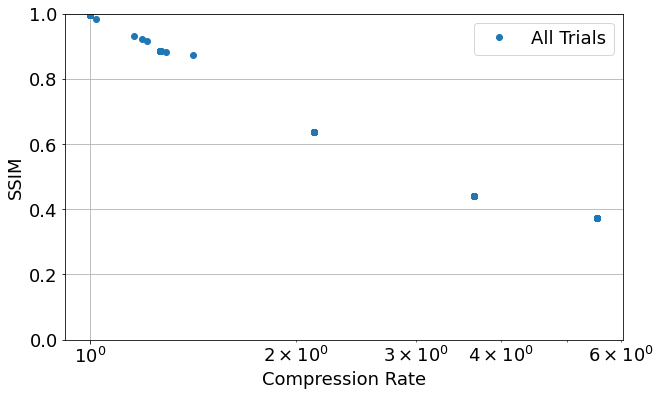

Results for image: image
../images/results/MP_no_AQ_random_sampler_4.2.06_pareto_front.png saved


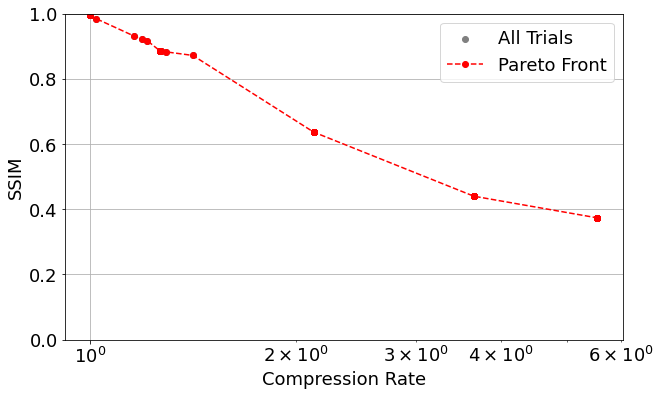

[I 2024-12-11 14:49:58,973] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:4.2.03_time:2024-12-11_14-49-58


8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3127752
DEFLATE applied. Bytes to write: 2914847
File saved.


[I 2024-12-11 14:50:55,001] Trial 0 finished with values: [0.9996366520168972, 0.9979270101343284] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 55.91381645202637
SSIM Index : 0.9979270101343284

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:51:02,363] Trial 1 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.25883936882019
SSIM Index : 0.21044176185774047

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3300987
DEFLATE applied. Bytes to write: 3085446
File saved.


[I 2024-12-11 14:52:00,542] Trial 2 finished with values: [0.9996098063407259, 0.9981468426911994] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 58.06769061088562
SSIM Index : 0.9981468426911994

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:52:07,914] Trial 3 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.266433477401733
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:52:15,342] Trial 4 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.32657790184021
SSIM Index : 0.21044176185774047

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 14:53:03,349] Trial 5 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.89423704147339
SSIM Index : 0.8832513293618657

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:53:10,950] Trial 6 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.496798515319824
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:53:18,385] Trial 7 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.331908226013184
SSIM Index : 0.21044176185774047

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 2944677
DEFLATE applied. Bytes to write: 2736795
File saved.


[I 2024-12-11 14:54:10,434] Trial 8 finished with values: [0.9997029828109201, 0.9974388731530636] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 51.93864583969116
SSIM Index : 0.9974388731530636

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 14:54:58,025] Trial 9 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.48081588745117
SSIM Index : 0.8832513293618657

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 14:55:13,523] Trial 10 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.389057159423828
SSIM Index : 0.5299292936152326

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 14:55:21,238] Trial 11 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.597924709320068
SSIM Index : 0.21044176185774047

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3332742
DEFLATE applied. Bytes to write: 3116782
File saved.


[I 2024-12-11 14:56:19,762] Trial 12 finished with values: [0.9995782250382678, 0.9981745604596587] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 58.41312885284424
SSIM Index : 0.9981745604596587

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 14:56:35,141] Trial 13 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.268956422805786
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 14:56:42,020] Trial 14 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.771787405014038
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 14:57:29,583] Trial 15 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.45314884185791
SSIM Index : 0.8832513293618657

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 14:57:36,203] Trial 16 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.51391863822937
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 14:57:51,172] Trial 17 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.860238552093506
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 14:57:58,194] Trial 18 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.9113404750823975
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 14:58:13,881] Trial 19 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.563598871231079
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 14:58:20,409] Trial 20 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.415810585021973
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 14:59:08,173] Trial 21 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.65432906150818
SSIM Index : 0.8832513293618657

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 14:59:56,583] Trial 22 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.2984459400177
SSIM Index : 0.8832513293618657

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:00:44,218] Trial 23 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.52593779563904
SSIM Index : 0.8832513293618657

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:00:50,877] Trial 24 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.5510382652282715
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:01:05,762] Trial 25 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.777359247207642
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:01:20,727] Trial 26 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.856156826019287
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 1144022
DEFLATE applied. Bytes to write: 1032464
File saved.


[I 2024-12-11 15:01:44,619] Trial 27 finished with values: [1.115549451808705, 0.9285950610186661] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 23.784490823745728
SSIM Index : 0.9285950610186661

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3569752
DEFLATE applied. Bytes to write: 3349337
File saved.


[I 2024-12-11 15:02:47,955] Trial 28 finished with values: [0.9996255977403165, 0.9982634768216174] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 63.229217290878296
SSIM Index : 0.9982634768216174

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:02:54,582] Trial 29 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.520271301269531
SSIM Index : 0.2942763826515455

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:03:01,703] Trial 30 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.014910459518433
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:03:16,670] Trial 31 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.861145496368408
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:03:31,924] Trial 32 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.14453911781311
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:03:46,967] Trial 33 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.934048414230347
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:03:53,782] Trial 34 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.705160617828369
SSIM Index : 0.2942763826515455

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:04:00,549] Trial 35 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.6582300662994385
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:04:15,550] Trial 36 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.892298936843872
SSIM Index : 0.5299292936152326

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:04:22,560] Trial 37 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.90496301651001
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:04:38,926] Trial 38 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 16.26190757751465
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3399927
DEFLATE applied. Bytes to write: 3182633
File saved.


[I 2024-12-11 15:05:38,475] Trial 39 finished with values: [0.9996650784222034, 0.9982203515676199] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 59.42772150039673
SSIM Index : 0.9982203515676199

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:05:45,326] Trial 40 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.743512868881226
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:06:34,985] Trial 41 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 49.54912614822388
SSIM Index : 0.8832513293618657

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:06:50,724] Trial 42 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.626280546188354
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:06:57,504] Trial 43 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.672138452529907
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:07:12,824] Trial 44 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.212801218032837
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:07:28,339] Trial 45 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.40483832359314
SSIM Index : 0.5299292936152326

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:08:17,237] Trial 46 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.7900972366333
SSIM Index : 0.8832513293618657

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:08:32,446] Trial 47 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.100407361984253
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:08:48,618] Trial 48 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 16.061120748519897
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3597112
DEFLATE applied. Bytes to write: 3376837
File saved.


[I 2024-12-11 15:09:50,545] Trial 49 finished with values: [0.9996319144398543, 0.9982646848170685] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 61.814942359924316
SSIM Index : 0.9982646848170685

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:09:57,709] Trial 50 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.055379390716553
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:10:04,660] Trial 51 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.8478844165802
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:10:19,627] Trial 52 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.858183860778809
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 1474107
DEFLATE applied. Bytes to write: 1339724
File saved.


[I 2024-12-11 15:10:50,171] Trial 53 finished with values: [1.0509120320469278, 0.9591647017830428] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 30.43483829498291
SSIM Index : 0.9591647017830428

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 1598007
DEFLATE applied. Bytes to write: 1455730
File saved.


[I 2024-12-11 15:11:22,002] Trial 54 finished with values: [1.0364085740070723, 0.9671887343492619] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 31.719778537750244
SSIM Index : 0.9671887343492619

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:12:10,491] Trial 55 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.37694334983826
SSIM Index : 0.8832513293618657

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:12:25,519] Trial 56 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.918814659118652
SSIM Index : 0.5299292936152326

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:12:33,018] Trial 57 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.3946990966796875
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:12:47,892] Trial 58 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.766388416290283
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:12:54,446] Trial 59 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.445558071136475
SSIM Index : 0.2942763826515455

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 2970322
DEFLATE applied. Bytes to write: 2761425
File saved.


[I 2024-12-11 15:13:46,640] Trial 60 finished with values: [0.9996271769077169, 0.9975321520522997] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 52.08191704750061
SSIM Index : 0.9975321520522997

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:13:53,235] Trial 61 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.486233949661255
SSIM Index : 0.2942763826515455

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:13:59,866] Trial 62 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.522012233734131
SSIM Index : 0.2942763826515455

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3150147
DEFLATE applied. Bytes to write: 2936990
File saved.


[I 2024-12-11 15:14:54,871] Trial 63 finished with values: [0.999654023516922, 0.9979642032269194] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 54.89386439323425
SSIM Index : 0.9979642032269194

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:15:09,779] Trial 64 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.79955768585205
SSIM Index : 0.5299292936152326

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1979190
DEFLATE applied. Bytes to write: 1874782
File saved.


[I 2024-12-11 15:15:56,919] Trial 65 finished with values: [1.211123381955224, 0.883239973641882] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.02982473373413
SSIM Index : 0.883239973641882

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:16:04,126] Trial 66 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.101534366607666
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:16:19,846] Trial 67 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.608177661895752
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3261327
DEFLATE applied. Bytes to write: 3046513
File saved.


[I 2024-12-11 15:17:19,233] Trial 68 finished with values: [0.999654023516922, 0.9981091822421589] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 59.27620005607605
SSIM Index : 0.9981091822421589

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:17:26,710] Trial 69 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.373136758804321
SSIM Index : 0.21044176185774047

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3533912
DEFLATE applied. Bytes to write: 3313762
File saved.


[I 2024-12-11 15:18:29,275] Trial 70 finished with values: [0.9996145437082159, 0.9982600866129987] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 62.453890800476074
SSIM Index : 0.9982600866129987

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:19:18,203] Trial 71 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.81711959838867
SSIM Index : 0.8832513293618657

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 2980097
DEFLATE applied. Bytes to write: 2770837
File saved.


[I 2024-12-11 15:20:11,598] Trial 72 finished with values: [0.9996255977403165, 0.9975659737478635] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 53.283921003341675
SSIM Index : 0.9975659737478635

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:20:18,408] Trial 73 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.704262018203735
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:21:06,219] Trial 74 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.700023889541626
SSIM Index : 0.8832513293618657

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:21:21,193] Trial 75 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.866158723831177
SSIM Index : 0.5299292936152326

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:21:36,287] Trial 76 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.985633134841919
SSIM Index : 0.5299292936152326

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:21:43,757] Trial 77 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.3676629066467285
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:21:51,727] Trial 78 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.865335941314697
SSIM Index : 0.21044176185774047

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:21:58,632] Trial 79 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.799691438674927
SSIM Index : 0.2942763826515455

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:22:13,790] Trial 80 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 15.04940938949585
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3580867
DEFLATE applied. Bytes to write: 3360438
File saved.


[I 2024-12-11 15:23:17,498] Trial 81 finished with values: [0.9996334936272124, 0.9982641334398558] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 63.59319233894348
SSIM Index : 0.9982641334398558

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3264902
DEFLATE applied. Bytes to write: 3050106
File saved.


[I 2024-12-11 15:24:14,944] Trial 82 finished with values: [0.9996492857752206, 0.9981125133510101] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 57.33279252052307
SSIM Index : 0.9981125133510101

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:24:21,539] Trial 83 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.489086151123047
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:25:09,580] Trial 84 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 47.93083596229553
SSIM Index : 0.8832513293618657

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:25:17,056] Trial 85 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 7.372794151306152
SSIM Index : 0.21044176185774047

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:25:31,661] Trial 86 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 14.495682001113892
SSIM Index : 0.5299292936152326

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3552782
DEFLATE applied. Bytes to write: 3332376
File saved.


[I 2024-12-11 15:26:34,146] Trial 87 finished with values: [0.9996287560801065, 0.9982624878245158] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 62.37411618232727
SSIM Index : 0.9982624878245158

32 32
image name:  4.2.03
processed_blocks: 768
bytes_written (without DEFLATE): 507572
DEFLATE applied. Bytes to write: 482953
File saved.


[I 2024-12-11 15:26:52,924] Trial 88 finished with values: [2.318517080034149, 0.5299292936152326] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 18.671249389648438
SSIM Index : 0.5299292936152326

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:26:59,758] Trial 89 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.726969957351685
SSIM Index : 0.2942763826515455

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3504272
DEFLATE applied. Bytes to write: 3284651
File saved.


[I 2024-12-11 15:28:00,818] Trial 90 finished with values: [0.9996287560801065, 0.998254786048426] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 60.9509916305542
SSIM Index : 0.998254786048426

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 3601582
DEFLATE applied. Bytes to write: 3381345
File saved.


[I 2024-12-11 15:29:06,395] Trial 91 finished with values: [0.9996334936272124, 0.998264749310246] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 65.46488761901855
SSIM Index : 0.998264749310246

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:29:13,347] Trial 92 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.848243236541748
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:29:20,242] Trial 93 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.792130470275879
SSIM Index : 0.21044176185774047

128 128
image name:  4.2.03
processed_blocks: 48
bytes_written (without DEFLATE): 31357
DEFLATE applied. Bytes to write: 29896
File saved.


[I 2024-12-11 15:29:27,198] Trial 94 finished with values: [5.6101782072878805, 0.21044176185774047] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.849155426025391
SSIM Index : 0.21044176185774047

64 64
image name:  4.2.03
processed_blocks: 192
bytes_written (without DEFLATE): 125620
DEFLATE applied. Bytes to write: 119803
File saved.


[I 2024-12-11 15:29:33,801] Trial 95 finished with values: [4.209835803816164, 0.2942763826515455] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 6.495750427246094
SSIM Index : 0.2942763826515455

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:30:22,338] Trial 96 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.425193309783936
SSIM Index : 0.8832513293618657

16 16
image name:  4.2.03
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
DEFLATE applied. Bytes to write: 1875723
File saved.


[I 2024-12-11 15:31:10,532] Trial 97 finished with values: [1.211151199624848, 0.8832513293618657] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 48.083580017089844
SSIM Index : 0.8832513293618657

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 1525787
DEFLATE applied. Bytes to write: 1388100
File saved.


[I 2024-12-11 15:31:40,341] Trial 98 finished with values: [1.0440438359419084, 0.9626925329269437] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 29.69783854484558
SSIM Index : 0.9626925329269437

8 8
image name:  4.2.03
processed_blocks: 12288
bytes_written (without DEFLATE): 2426352
DEFLATE applied. Bytes to write: 2241027
File saved.


[I 2024-12-11 15:32:23,860] Trial 99 finished with values: [1.001234192837884, 0.9934005070031059] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.03_reconstructed.png
execution_time 43.408639430999756
SSIM Index : 0.9934005070031059

../images/results/MP_no_AQ_random_sampler_4.2.03_compression_vs_ssim.png saved


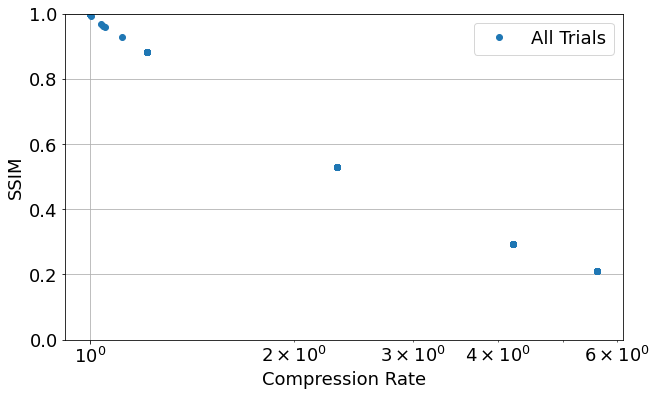

Results for image: image
../images/results/MP_no_AQ_random_sampler_4.2.03_pareto_front.png saved


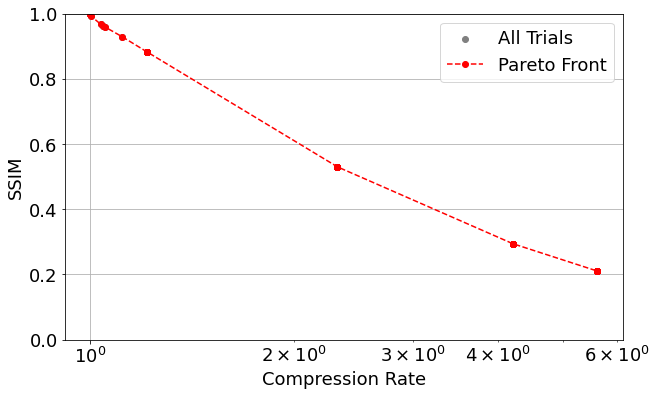

[I 2024-12-11 15:32:24,869] A new study created in memory with name: MP_no_AQ_multiobj_random_sampler_trials:100_seed:43_image:4.2.07_time:2024-12-11_15-32-24


8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2699157
DEFLATE applied. Bytes to write: 2507660
File saved.


[I 2024-12-11 15:33:12,864] Trial 0 finished with values: [0.9995185633466228, 0.9935992202653257] and parameters: {'min_sparcity': 0.12390402072588116, 'max_error': 4.512313192130652, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 47.886317014694214
SSIM Index : 0.9935992202653257

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:33:20,263] Trial 1 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.2481837237656953, 'max_error': 0.09179823579122504, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.295257091522217
SSIM Index : 0.41839355308777626

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2911802
DEFLATE applied. Bytes to write: 2714535
File saved.


[I 2024-12-11 15:34:10,911] Trial 2 finished with values: [0.9995456197746274, 0.9942193684945547] and parameters: {'min_sparcity': 0.6694293109670455, 'max_error': 1.7659291428062145, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 50.5408616065979
SSIM Index : 0.9942193684945547

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:34:18,366] Trial 3 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.7364108133174802, 'max_error': 0.23426106351002185, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.353130578994751
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:34:25,619] Trial 4 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.26187691460128054, 'max_error': 0.0021943688007952746, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.150866985321045
SSIM Index : 0.41839355308777626

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:35:13,098] Trial 5 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.2288187059255276, 'max_error': 0.2691142458928118, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 47.37101650238037
SSIM Index : 0.8823050844806314

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:35:21,264] Trial 6 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.08589607299648278, 'max_error': 114.64316449339596, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.03592848777771
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:35:28,850] Trial 7 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.9717504405210341, 'max_error': 0.20523975444033044, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.482812404632568
SSIM Index : 0.41839355308777626

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2460582
DEFLATE applied. Bytes to write: 2277046
File saved.


[I 2024-12-11 15:36:14,299] Trial 8 finished with values: [0.9995127657311897, 0.9922053364749072] and parameters: {'min_sparcity': 0.45130077723132167, 'max_error': 10.431527572803107, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.341636657714844
SSIM Index : 0.9922053364749072

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:37:29,705] Trial 9 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.898127594181719, 'max_error': 0.06137916897470555, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 75.25224256515503
SSIM Index : 0.8823050844806314

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:38:00,125] Trial 10 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.015078253573812381, 'max_error': 1.8164150502902998, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 30.3094162940979
SSIM Index : 0.6655212207167308

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:38:08,314] Trial 11 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.6400099407958074, 'max_error': 739.9882171284974, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.063089370727539
SSIM Index : 0.41839355308777626

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2948387
DEFLATE applied. Bytes to write: 2750343
File saved.


[I 2024-12-11 15:39:11,594] Trial 12 finished with values: [0.9995398218453144, 0.9942906914656177] and parameters: {'min_sparcity': 0.911051545022355, 'max_error': 1.4175357699432367, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 63.176029205322266
SSIM Index : 0.9942906914656177

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:39:26,874] Trial 13 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.189105449305322, 'max_error': 522.6865513664582, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.17577338218689
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:39:33,437] Trial 14 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.8663669494011099, 'max_error': 10.791049304872342, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.456899881362915
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1924880
DEFLATE applied. Bytes to write: 1820328
File saved.


[I 2024-12-11 15:40:23,025] Trial 15 finished with values: [1.284824519762497, 0.8822991521498998] and parameters: {'min_sparcity': 0.2828031888824626, 'max_error': 240.1505681565605, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 49.48696827888489
SSIM Index : 0.8822991521498998

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:40:30,006] Trial 16 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.41036119064465354, 'max_error': 915.0292022480866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.876594066619873
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:40:45,687] Trial 17 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.45061079836478585, 'max_error': 2.3119530833360113, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.573858737945557
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:40:52,839] Trial 18 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.7297181120483086, 'max_error': 0.24841700153855414, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.039904832839966
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:41:08,117] Trial 19 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.707668451801736, 'max_error': 4.543172507033174, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.171632528305054
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:41:15,281] Trial 20 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.21402103240416875, 'max_error': 0.015666387332157278, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.056991815567017
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:42:19,461] Trial 21 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.29742944999304904, 'max_error': 8.625354766768064, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 64.07810759544373
SSIM Index : 0.8823050844806314

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:43:25,173] Trial 22 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.15303359463860045, 'max_error': 0.2653016810748074, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 65.58888173103333
SSIM Index : 0.8823050844806314

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:44:12,594] Trial 23 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.2509640361181526, 'max_error': 3.3777247486710733, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 47.31255292892456
SSIM Index : 0.8823050844806314

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:44:19,523] Trial 24 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.7502929056749345, 'max_error': 20.935333670118613, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.8226635456085205
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:44:35,362] Trial 25 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.11171535078747956, 'max_error': 459.0442683151148, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.735104322433472
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:44:51,408] Trial 26 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9006768831737386, 'max_error': 0.015541012387669917, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.939830780029297
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 491622
DEFLATE applied. Bytes to write: 415869
File saved.


[I 2024-12-11 15:45:07,950] Trial 27 finished with values: [1.6873321082471366, 0.8164247721681872] and parameters: {'min_sparcity': 0.9657544958604907, 'max_error': 982.1763565881988, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 16.430097818374634
SSIM Index : 0.8164247721681872

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3215887
DEFLATE applied. Bytes to write: 3012921
File saved.


[I 2024-12-11 15:46:11,423] Trial 28 finished with values: [0.999566879424259, 0.994528103789758] and parameters: {'min_sparcity': 0.48649030012076344, 'max_error': 0.05604490509028382, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 63.352622270584106
SSIM Index : 0.994528103789758

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:46:21,304] Trial 29 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.5739281549536284, 'max_error': 0.0010727529270470305, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 9.7673499584198
SSIM Index : 0.49599456726194374

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:46:29,113] Trial 30 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8714796622642436, 'max_error': 200.26672226380816, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.694260597229004
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:46:52,427] Trial 31 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.7424651816054394, 'max_error': 0.012831509366158275, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 23.181683778762817
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:47:15,210] Trial 32 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.8870405005923947, 'max_error': 0.03390608777797147, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 22.664299964904785
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:47:36,749] Trial 33 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.6207676060626862, 'max_error': 0.004169798466345512, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 21.429001092910767
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:47:44,980] Trial 34 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.05425735841138945, 'max_error': 0.0740908907126442, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.121428966522217
SSIM Index : 0.49599456726194374

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:47:53,792] Trial 35 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.718344095662784, 'max_error': 445.99035068783866, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 8.687724113464355
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:48:15,248] Trial 36 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.22307622983731434, 'max_error': 269.04633711756304, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 21.348071813583374
SSIM Index : 0.6655212207167308

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:48:22,463] Trial 37 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8464489087010877, 'max_error': 342.71799044521475, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.114367246627808
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:48:39,539] Trial 38 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.40025601798012905, 'max_error': 3.88265515392085, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 16.95198965072632
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3026652
DEFLATE applied. Bytes to write: 2826792
File saved.


[I 2024-12-11 15:49:50,544] Trial 39 finished with values: [0.9995610812483081, 0.9944053834586182] and parameters: {'min_sparcity': 0.6972056643894814, 'max_error': 0.8093175117580228, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 70.9001350402832
SSIM Index : 0.9944053834586182

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:49:58,354] Trial 40 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.6479267916476755, 'max_error': 0.01691364835189656, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.699396848678589
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:50:58,924] Trial 41 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.11456103433855681, 'max_error': 0.0011062593703934163, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 60.455610275268555
SSIM Index : 0.8823050844806314

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:51:18,898] Trial 42 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9695629487927453, 'max_error': 16.064016317026674, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 19.86763596534729
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:51:25,764] Trial 43 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.12954464881062958, 'max_error': 0.0023024025951609898, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.760354280471802
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:51:43,453] Trial 44 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9063964744703389, 'max_error': 0.0012478302441657247, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 17.582910537719727
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:52:02,119] Trial 45 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.731318009706466, 'max_error': 0.05664808925505294, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 18.543823719024658
SSIM Index : 0.6655212207167308

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 15:52:59,778] Trial 46 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.8167033673881114, 'max_error': 3.784093694743141, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 57.55518913269043
SSIM Index : 0.8823050844806314

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:53:20,804] Trial 47 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.08678222744002122, 'max_error': 0.834520591850747, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 20.918023109436035
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:53:37,647] Trial 48 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.1897194091620571, 'max_error': 0.0026352122869867556, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 16.73667073249817
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3246852
DEFLATE applied. Bytes to write: 3044160
File saved.


[I 2024-12-11 15:54:48,930] Trial 49 finished with values: [0.9995958713130508, 0.9945292109267424] and parameters: {'min_sparcity': 0.3385332174829653, 'max_error': 0.019363636533108193, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 71.16941523551941
SSIM Index : 0.9945292109267424

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:54:56,637] Trial 50 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8395512233830198, 'max_error': 0.13510605790097835, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.602811574935913
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:55:03,729] Trial 51 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.03570264653962555, 'max_error': 0.0010314245467589256, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.989679336547852
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:55:20,899] Trial 52 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.6771939184975456, 'max_error': 930.8666702523619, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 17.059380292892456
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 713027
DEFLATE applied. Bytes to write: 626175
File saved.


[I 2024-12-11 15:55:39,925] Trial 53 finished with values: [1.320249669907574, 0.8751160398017991] and parameters: {'min_sparcity': 0.16754612158844154, 'max_error': 517.2474004231686, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 18.918628454208374
SSIM Index : 0.8751160398017991

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 821662
DEFLATE applied. Bytes to write: 728348
File saved.


[I 2024-12-11 15:55:59,302] Trial 54 finished with values: [1.2221949022509817, 0.8958690885038267] and parameters: {'min_sparcity': 0.375592453972623, 'max_error': 404.9113058527544, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 19.270543098449707
SSIM Index : 0.8958690885038267

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1925520
DEFLATE applied. Bytes to write: 1820946
File saved.


[I 2024-12-11 15:56:52,550] Trial 55 finished with values: [1.284840486345154, 0.8823024127845555] and parameters: {'min_sparcity': 0.45942249346774333, 'max_error': 210.73833767142509, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 53.14640545845032
SSIM Index : 0.8823024127845555

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:57:10,095] Trial 56 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.963031358338554, 'max_error': 964.3520368066368, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 17.43961453437805
SSIM Index : 0.6655212207167308

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 15:57:17,564] Trial 57 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.32807867254967304, 'max_error': 692.841651905502, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.3681323528289795
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:57:32,863] Trial 58 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.45076096913092145, 'max_error': 0.0018555564568242143, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 15.195020198822021
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:57:39,539] Trial 59 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.7130730517990856, 'max_error': 5.707264048309493, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.570051908493042
SSIM Index : 0.49599456726194374

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2492372
DEFLATE applied. Bytes to write: 2307218
File saved.


[I 2024-12-11 15:58:26,531] Trial 60 finished with values: [0.9995475524326791, 0.9924700088739278] and parameters: {'min_sparcity': 0.9721996712482255, 'max_error': 9.371895670532844, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 46.88612174987793
SSIM Index : 0.9924700088739278

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:58:33,314] Trial 61 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.5938337001075316, 'max_error': 0.01859884771270904, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.678199529647827
SSIM Index : 0.49599456726194374

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 15:58:39,945] Trial 62 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.35680292240557393, 'max_error': 1.0342341308419865, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.5255913734436035
SSIM Index : 0.49599456726194374

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2728897
DEFLATE applied. Bytes to write: 2536522
File saved.


[I 2024-12-11 15:59:29,916] Trial 63 finished with values: [0.9995552831396237, 0.993707710031415] and parameters: {'min_sparcity': 0.17991139915875912, 'max_error': 4.039770065784967, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 49.86302614212036
SSIM Index : 0.993707710031415

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 15:59:44,811] Trial 64 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.8283126173321356, 'max_error': 0.09913106476555739, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.79066014289856
SSIM Index : 0.6655212207167308

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1833835
DEFLATE applied. Bytes to write: 1732953
File saved.


[I 2024-12-11 16:00:30,031] Trial 65 finished with values: [1.285786415687523, 0.8808381418785022] and parameters: {'min_sparcity': 0.8324034985959148, 'max_error': 652.2324060338925, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.11971640586853
SSIM Index : 0.8808381418785022

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:00:37,533] Trial 66 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.0974900814155888, 'max_error': 603.8578865480883, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.401958465576172
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:00:52,382] Trial 67 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9198863161854353, 'max_error': 126.74012768450979, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.744296550750732
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2865807
DEFLATE applied. Bytes to write: 2669822
File saved.


[I 2024-12-11 16:01:45,191] Trial 68 finished with values: [0.9995726776674775, 0.9941074588496113] and parameters: {'min_sparcity': 0.4739303925463088, 'max_error': 2.25796308059517, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 52.70366334915161
SSIM Index : 0.9941074588496113

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:01:52,559] Trial 69 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.8997497204480387, 'max_error': 4.907759189635353, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.270706653594971
SSIM Index : 0.41839355308777626

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3177317
DEFLATE applied. Bytes to write: 2974440
File saved.


[I 2024-12-11 16:02:46,457] Trial 70 finished with values: [0.9995572158350445, 0.9945204240814216] and parameters: {'min_sparcity': 0.6956506335105708, 'max_error': 0.13440304583216858, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 53.791117906570435
SSIM Index : 0.9945204240814216

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 16:03:32,308] Trial 71 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.05570637713148509, 'max_error': 0.09135624281468929, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.74699330329895
SSIM Index : 0.8823050844806314

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2504707
DEFLATE applied. Bytes to write: 2318929
File saved.


[I 2024-12-11 16:04:17,810] Trial 72 finished with values: [0.9995204959000465, 0.9925645114474703] and parameters: {'min_sparcity': 0.4845933379908769, 'max_error': 8.99225779128126, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.39807462692261
SSIM Index : 0.9925645114474703

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 16:04:24,437] Trial 73 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.3034811557330782, 'max_error': 0.016616471803143705, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.524965763092041
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 16:05:12,804] Trial 74 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.5813848057348171, 'max_error': 12.3257347789436, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 48.266658306121826
SSIM Index : 0.8823050844806314

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:05:27,596] Trial 75 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.03204705085683329, 'max_error': 0.0017133458756788478, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.684916973114014
SSIM Index : 0.6655212207167308

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:05:42,421] Trial 76 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.8788339965851846, 'max_error': 1.7176833870578099, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.719772100448608
SSIM Index : 0.6655212207167308

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:05:49,835] Trial 77 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.5487840129517959, 'max_error': 1.2546247963871944, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.307618856430054
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:05:57,360] Trial 78 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.41609245458084126, 'max_error': 82.62868504315763, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.420764923095703
SSIM Index : 0.41839355308777626

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 16:06:03,869] Trial 79 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.5982391817235303, 'max_error': 0.015506010453418602, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.406953811645508
SSIM Index : 0.49599456726194374

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:06:18,361] Trial 80 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.015376993331335003, 'max_error': 0.0020724213665986356, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.3854501247406
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3228377
DEFLATE applied. Bytes to write: 3025336
File saved.


[I 2024-12-11 16:07:17,647] Trial 81 finished with values: [0.9995707449122637, 0.9945283045770408] and parameters: {'min_sparcity': 0.2594537143597178, 'max_error': 0.03846197881355776, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 59.181220054626465
SSIM Index : 0.9945283045770408

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 2869857
DEFLATE applied. Bytes to write: 2673727
File saved.


[I 2024-12-11 16:08:07,481] Trial 82 finished with values: [0.9995282261884736, 0.994117335320012] and parameters: {'min_sparcity': 0.8978526581369589, 'max_error': 2.2115216888717564, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 49.726391553878784
SSIM Index : 0.994117335320012

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 16:08:14,031] Trial 83 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.5769278337725201, 'max_error': 16.522078512698698, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.448100566864014
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 16:08:59,971] Trial 84 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.45157183505956505, 'max_error': 0.35515253079820397, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.83864736557007
SSIM Index : 0.8823050844806314

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:09:06,844] Trial 85 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.9449753470139227, 'max_error': 54.54405822358017, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.771850824356079
SSIM Index : 0.41839355308777626

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:09:21,275] Trial 86 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.9088286076592599, 'max_error': 0.27833717046502754, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.326372861862183
SSIM Index : 0.6655212207167308

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3197847
DEFLATE applied. Bytes to write: 2994951
File saved.


[I 2024-12-11 16:10:18,525] Trial 87 finished with values: [0.9995572158350445, 0.9945249599444433] and parameters: {'min_sparcity': 0.6273297257699469, 'max_error': 0.0882525356130524, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 57.14254927635193
SSIM Index : 0.9945249599444433

32 32
image name:  4.2.07
processed_blocks: 768
bytes_written (without DEFLATE): 507712
DEFLATE applied. Bytes to write: 484833
File saved.


[I 2024-12-11 16:10:33,072] Trial 88 finished with values: [1.9831398605154331, 0.6655212207167308] and parameters: {'min_sparcity': 0.1727729888673415, 'max_error': 2.176755212087479, 'exponent_min_n': 5}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 14.441203594207764
SSIM Index : 0.6655212207167308

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 16:10:39,626] Trial 89 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.9720915986114103, 'max_error': 1.5475524739220925, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.448486804962158
SSIM Index : 0.49599456726194374

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3145237
DEFLATE applied. Bytes to write: 2942833
File saved.


[I 2024-12-11 16:11:34,371] Trial 90 finished with values: [0.999576543200328, 0.9945044080983054] and parameters: {'min_sparcity': 0.27855188622095867, 'max_error': 0.22795016817658695, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 54.64006161689758
SSIM Index : 0.9945044080983054

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 3251727
DEFLATE applied. Bytes to write: 3049034
File saved.


[I 2024-12-11 16:12:30,883] Trial 91 finished with values: [0.999599737025292, 0.9945294975316598] and parameters: {'min_sparcity': 0.44941018803601174, 'max_error': 0.015591019910958317, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 56.40667796134949
SSIM Index : 0.9945294975316598

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:12:38,071] Trial 92 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.7953813517908709, 'max_error': 0.006964401036713826, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.0906312465667725
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:12:45,420] Trial 93 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.19071012165698883, 'max_error': 73.35236062709926, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 7.25006890296936
SSIM Index : 0.41839355308777626

128 128
image name:  4.2.07
processed_blocks: 48
bytes_written (without DEFLATE): 31362
DEFLATE applied. Bytes to write: 29882
File saved.


[I 2024-12-11 16:12:52,496] Trial 94 finished with values: [4.55786457414918, 0.41839355308777626] and parameters: {'min_sparcity': 0.018777250633454888, 'max_error': 5.066481457100245, 'exponent_min_n': 7}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.975448846817017
SSIM Index : 0.41839355308777626

64 64
image name:  4.2.07
processed_blocks: 192
bytes_written (without DEFLATE): 125640
DEFLATE applied. Bytes to write: 119847
File saved.


[I 2024-12-11 16:12:58,895] Trial 95 finished with values: [3.1871724682178573, 0.49599456726194374] and parameters: {'min_sparcity': 0.9286834330389546, 'max_error': 3.150817068133919, 'exponent_min_n': 6}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 6.29733681678772
SSIM Index : 0.49599456726194374

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 16:13:44,060] Trial 96 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.5096322257454908, 'max_error': 2.9660341646867434, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 45.06496572494507
SSIM Index : 0.8823050844806314

16 16
image name:  4.2.07
processed_blocks: 3072
bytes_written (without DEFLATE): 1926775
DEFLATE applied. Bytes to write: 1822100
File saved.


[I 2024-12-11 16:14:30,895] Trial 97 finished with values: [1.284805360387117, 0.8823050844806314] and parameters: {'min_sparcity': 0.4338715692199968, 'max_error': 7.954160941717795, 'exponent_min_n': 4}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 46.73390483856201
SSIM Index : 0.8823050844806314

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 757022
DEFLATE applied. Bytes to write: 667637
File saved.


[I 2024-12-11 16:14:49,599] Trial 98 finished with values: [1.2767171801989587, 0.8839890312361117] and parameters: {'min_sparcity': 0.44411826826922934, 'max_error': 467.1061311197995, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 18.598151206970215
SSIM Index : 0.8839890312361117

8 8
image name:  4.2.07
processed_blocks: 12288
bytes_written (without DEFLATE): 1793077
DEFLATE applied. Bytes to write: 1647595
File saved.


[I 2024-12-11 16:15:24,799] Trial 99 finished with values: [1.0043382810071495, 0.9795418967753791] and parameters: {'min_sparcity': 0.4066190204389426, 'max_error': 58.74452016819859, 'exponent_min_n': 3}.


Output file saved to: ../compressions/4.2.07_reconstructed.png
execution_time 35.091864347457886
SSIM Index : 0.9795418967753791

../images/results/MP_no_AQ_random_sampler_4.2.07_compression_vs_ssim.png saved


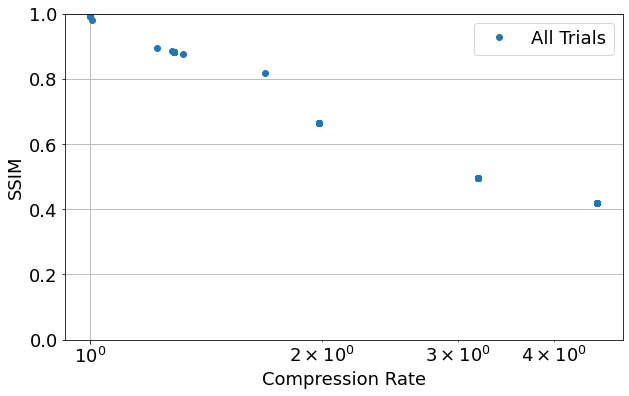

Results for image: image
../images/results/MP_no_AQ_random_sampler_4.2.07_pareto_front.png saved


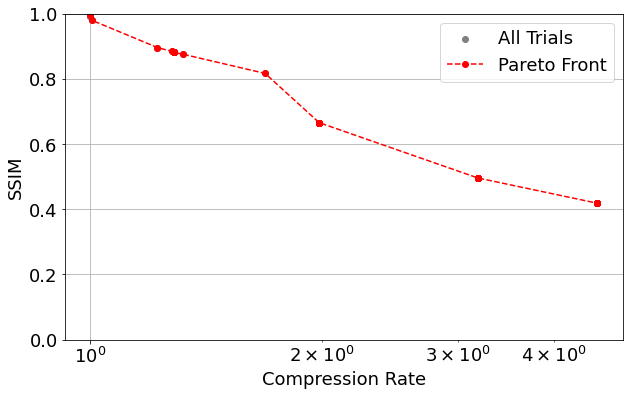

In [18]:
def objective(trial):
    min_sparcity = trial.suggest_float('min_sparcity', 0.01, 1)
    max_error = trial.suggest_float('max_error', 0.001, 1000, log = True)
    exponent_min_n = trial.suggest_int('exponent_min_n', 3, 7)

    exponent_a_cols = 8 # trial.suggest_int("exponent_a_cols", 1, 8)
    exponent_max_n = exponent_min_n # trial.suggest_int('exponent_max_n', exponent_min_n, 7)
    a_cols = 2**exponent_a_cols
    min_n = 2**exponent_min_n
    max_n = 2**exponent_max_n
    print(max_n, min_n)
    assert max_n >= min_n

    print("image name: ", image_name)
    folder_path = "../images/Color/512x512/"
    input_image_path = folder_path+image_name+".png"
    output_image_path = "../compressions/"+image_name+"_reconstructed.png"
    fif_image_path ="../compressions/"+image_name+".fif"

    # ENCODE
    start_time = time.time()    
    newCodec = ImageCompressor(min_sparcity = min_sparcity,
                               min_n = min_n,
                               max_n = max_n,
                               max_error = max_error,
                               a_cols = a_cols,
                               apply_deflate=True
                              )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        newCodec.encode(input_file=input_image_path, output_file=fif_image_path)

    # DECODE
    newCodec.decode(input_file=fif_image_path, output_file=output_image_path)
    end_time = time.time()
    execution_time = end_time - start_time
    print("execution_time", execution_time)

    # CALCULATE SSIM
    ssim_index = calculate_ssim(input_image_path, output_image_path)
    print(f"SSIM Index : {ssim_index}\n")

    # COMPRESSION RATE
    image_size = os.path.getsize(input_image_path)
    compressed_image_size = os.path.getsize(output_image_path)
    compression_rate = image_size / compressed_image_size

    # Store additional information in trial attributes
    trial.set_user_attr("execution_time", execution_time)
    trial.set_user_attr("ssim", ssim_index)
    trial.set_user_attr("compression_rate", compression_rate)

    return compression_rate, ssim_index

seed = 43
n_trials = 100
for image_name in test_images:
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    study_name = f"MP_no_AQ_multiobj_random_sampler_trials:{n_trials}_seed:{seed}_image:{image_name}_time:{current_time}"
    storage_path = "sqlite:///"+study_name+".db" 
    sampler = RandomSampler(seed=seed)  # Make the sampler behave in a deterministic way
    study = optuna.create_study(directions=['maximize', 'maximize'], study_name=study_name, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)
    plot_results(study, plot_name="../images/results/"+"MP_no_AQ_random_sampler_"+image_name, log_xscale=True)    

comparisons

- fixed size block
- aqmp with random search (100 iterations)
- aqmp with TPE search (100 iterations)
- quadtree standard
- jpeg



- [x] guardar todas las imagenes
- [X] poner DEFLATE = True
- [x] agregar guardado de imagenes, dpi 300

# 5. Compress with Quadtrees and no MP

This library implements an image compression algorithm that is based on quadtrees with no MP:

- https://github.com/Inspiaaa/QuadTreeImageCompression

In [7]:
sys.path.append('/home/fcerino/Documents/proyectos/AQMP')
from quad_tree_compression import compress_image_file, reconstruct_image_from_file, compress_image_data

5


File Size Ratio (input/output): 198.73


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10


File Size Ratio (input/output): 186.18


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
100


File Size Ratio (input/output): 112.05
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
1000


File Size Ratio (input/output): 26.83
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
5000


File Size Ratio (input/output): 8.06
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10000


File Size Ratio (input/output): 4.57
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
20000


File Size Ratio (input/output): 2.66
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
../images/results/quadtree_no_MP_house_compression_vs_ssim.png saved
5


File Size Ratio (input/output): 198.73


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10


File Size Ratio (input/output): 186.18


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
100


File Size Ratio (input/output): 112.05
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
1000


File Size Ratio (input/output): 26.83
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
5000


File Size Ratio (input/output): 8.06
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10000


File Size Ratio (input/output): 4.57
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
20000


File Size Ratio (input/output): 2.66
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
../images/results/quadtree_no_MP_4.2.01_compression_vs_ssim.png saved
5


File Size Ratio (input/output): 198.73


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10


File Size Ratio (input/output): 186.18


SSIM: <function structural_similarity at 0x7fbf0c0aa670>
100


File Size Ratio (input/output): 112.05
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
1000


File Size Ratio (input/output): 26.83
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
5000


File Size Ratio (input/output): 8.06
SSIM: <function structural_similarity at 0x7fbf0c0aa670>
10000


KeyboardInterrupt: 

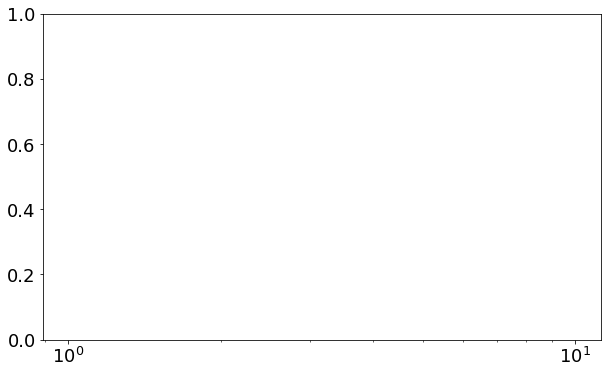

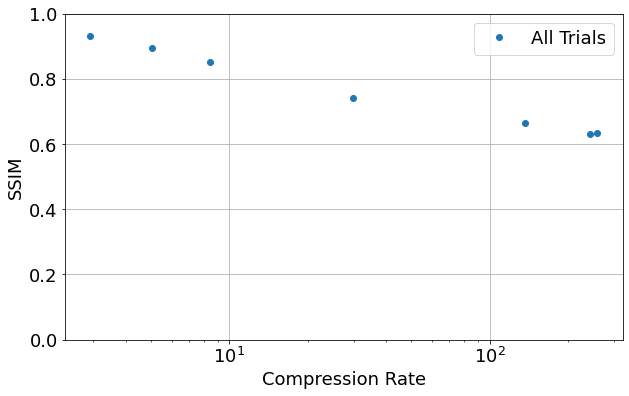

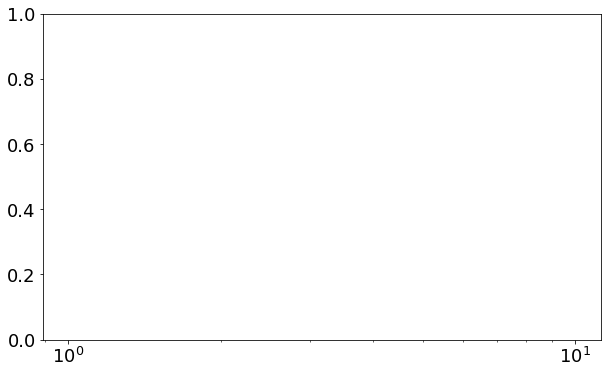

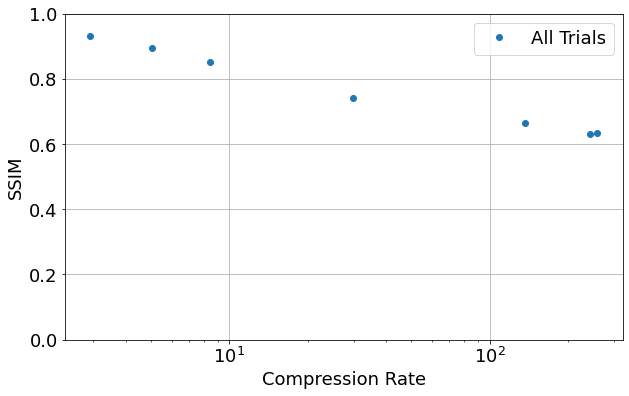

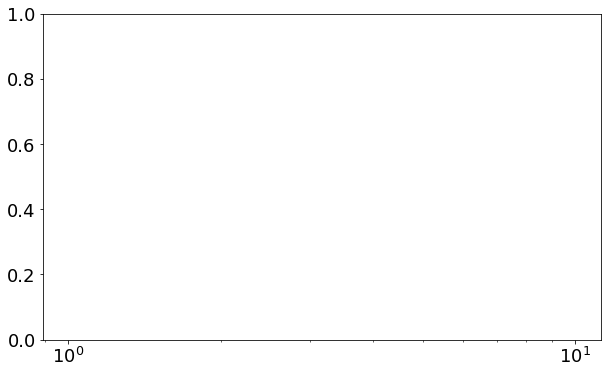

In [31]:
folder_path = "../images/Color/512x512/"
input_image = folder_path+f"{image_name}.png"
output_image = f"../compressions/{image_name}.qid"
set_iterations = [5, 10, 100, 1000, 5000, 10_000, 20_000]
for image_name in test_images:
    plt.figure(figsize=(10, 6))  # Adjust the size (width, height in inches)
    plt.xscale("log")
    ssim_values = []
    size_ratio_values = []
    for iterations in set_iterations:
        print(iterations)
        # Compress the image and encode is a binary file (any file extension can be chosen)
        compress_image_file(input_image, output_image, iterations=iterations)

        # Reconstruct the image from the binary file. (Returns a PIL.Image object)
        image = reconstruct_image_from_file(output_image)

        # image.show()

        # Load the image and convert it to a numpy array
        image = Image.open(input_image)
        image_data = np.array(image)

        # Compress the image
        compressed_data = compress_image_data(image_data, iterations=iterations)

        # Show the simplified image
        compressed_image = Image.fromarray(compressed_data)
        #compressed_image.show()

        # Save the image as a PNG file
        compressed_image.save(output_image, "PNG")

        # Get file sizes
        size1 = os.path.getsize(input_image)
        size2 = os.path.getsize(output_image)

        # Calculate file size ratio
        size_ratio = size1 / size2
        size_ratio_values.append(size_ratio)
        print(f"File Size Ratio (input/output): {size_ratio:.2f}")

        # Open the images and calculate ssim
        ssim_value = calculate_ssim(input_image, output_image)

        ssim_values.append(ssim_value)
        print(f"SSIM: {ssim}")

    # Plot compression rate vs SSIM
    plot_compression_vs_ssim(compression_rates,
                             ssim_values,
                             plot_name="../images/results/"+"quadtree_no_MP_"+image_name,
                             log_xscale=True
                        )

# 6. Compress with JPEG

../images/results/JPEG_house_compression_vs_ssim.png saved
../images/results/JPEG_4.2.01_compression_vs_ssim.png saved
../images/results/JPEG_4.2.05_compression_vs_ssim.png saved
../images/results/JPEG_4.2.06_compression_vs_ssim.png saved
../images/results/JPEG_4.2.03_compression_vs_ssim.png saved
../images/results/JPEG_4.2.07_compression_vs_ssim.png saved


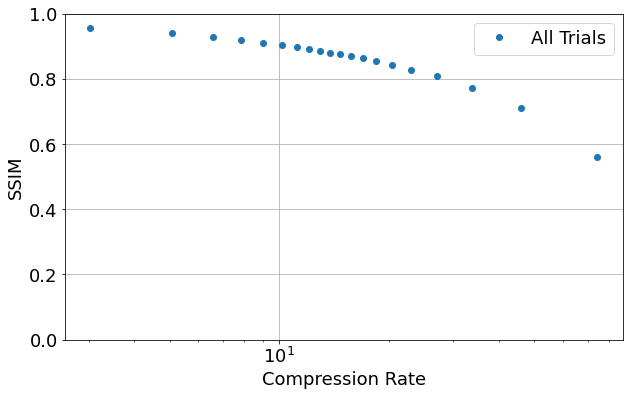

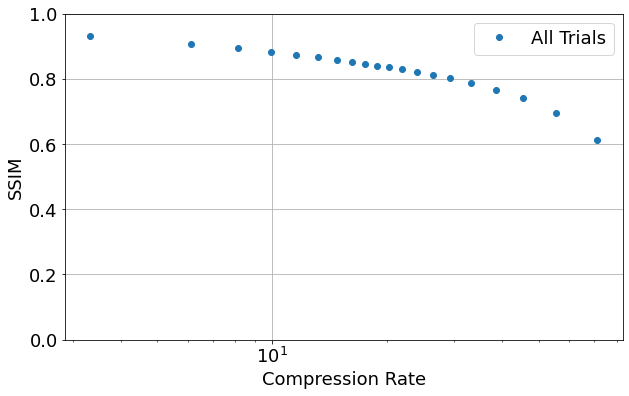

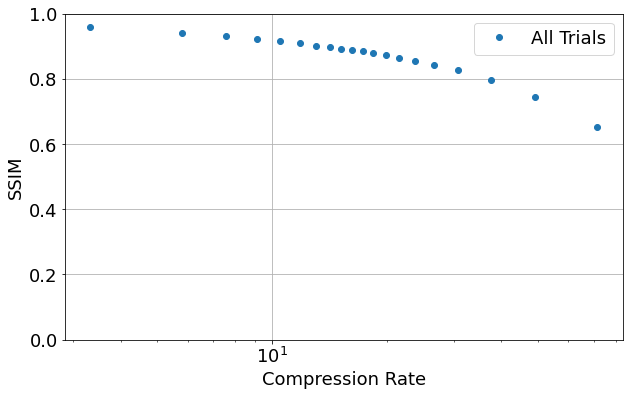

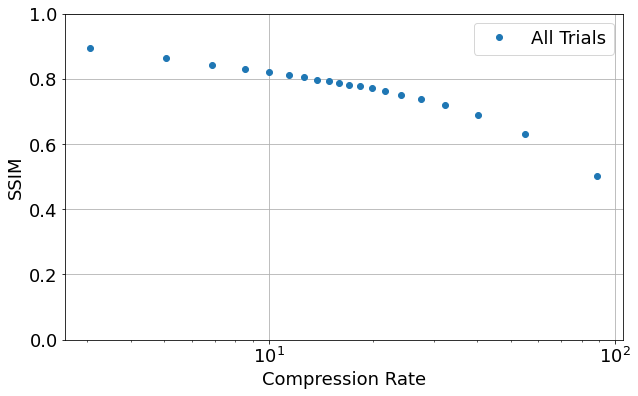

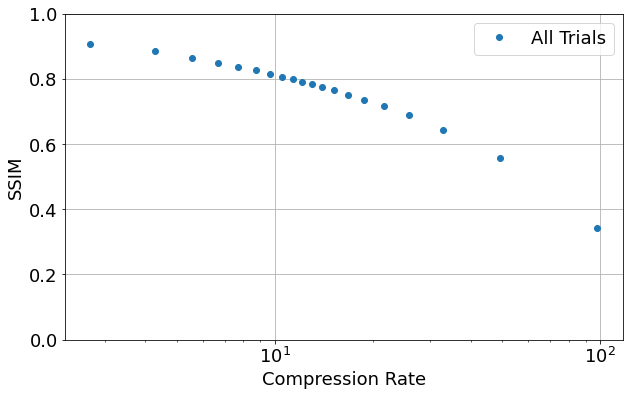

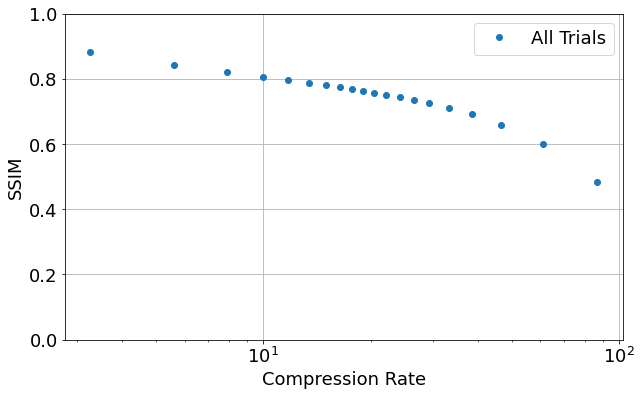

In [37]:
for image_name in test_images:
    image_path = f"../images/Color/512x512/{image_name}.png" # Replace with your image path    
    output_path = "../compressions/compressed_image_jpeg_"+image_name
    compression_ssim_path = "../images/results/"+"JPEG_"+image_name
    
    qualities = range(2, 101, 5) # Range of qualities for JPEG compression
    ssim_values = []
    compression_rates = []
    for quality in qualities:
        ssim_val, comp_rate = jpeg_compress_and_evaluate(image_path, output_path, quality)
        ssim_values.append(ssim_val)
        compression_rates.append(comp_rate)

    plot_compression_vs_ssim(compression_rates,
                             ssim_values,
                             plot_name=compression_ssim_path,
                             log_xscale=True
                        )